Deep Learning Final Project
=============

# §2 Training and Prediction Using the MNIST Style Greyscale Data
------------

[SVHN](http://ufldl.stanford.edu/housenumbers/) is a real-world image dataset for developing machine learning and object recognition algorithms with minimal requirement on data preprocessing and formatting. It can be seen as similar in flavor to MNIST (e.g., the images are of small cropped digits), but incorporates an order of magnitude more labelled data (over 600,000 digit images) and comes from a significantly harder, unsolved, real world problem (recognizing digits and numbers in natural scene images). SVHN is obtained from house numbers in Google Street View images.

In a previous iPython Notebooks (0_SVHNDownloadExtract.ipynb and 1_SVHNExploreProcess32x32.ipynb), we downloaded the MNIST like 32 x 32 image dataset and then processed it in preparation for model training. Here we develop our digit recognition model and test it's performance.

## 2.1 Import Modules

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
import pylab as pl
import numpy as np
import time
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
from sklearn.metrics import accuracy_score
import tensorflow as tf
from six.moves import cPickle as pickle
import pandas as pd
import seaborn as sns

%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## 2.2 Reload the extra data we generated in `1_SVHNExploreProcess32x32.ipynb`
Supposedly, the extra data examples are 'somewhat less difficult' we'll start with those and see how we do

In [2]:
# Stick all the data into train_dataset and train_labels

with open('data/32x32/greyscale/gs_extra1.pickle', 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['data']
    train_labels = save['labels']
    del save  # hint to help gc free up memory
    print('extra set 1: ', train_dataset.shape, train_labels.shape)
print('Training set:', train_dataset.shape, train_labels.shape)
print('')

with open('data/32x32/greyscale/gs_extra2.pickle', 'rb') as f:
    save = pickle.load(f)
    extra_dataset = save['data']
    extra_labels = save['labels']
    del save  # hint to help gc free up memory
    print('extra set 2: ', extra_dataset.shape, extra_labels.shape)
train_dataset = np.append(train_dataset, extra_dataset, axis=0)
train_labels = np.append(train_labels, extra_labels, axis=0)
print('Training set:', train_dataset.shape, train_labels.shape)
print('')

with open('data/32x32/greyscale/gs_extra3.pickle', 'rb') as f:
    save = pickle.load(f)
    extra_dataset = save['data']
    extra_labels = save['labels']
    del save  # hint to help gc free up memory
    print('extra set 3: ', extra_dataset.shape, extra_labels.shape)
train_dataset = np.append(train_dataset, extra_dataset, axis=0)
train_labels  = np.append(train_labels, extra_labels, axis=0)
print('Training set:', train_dataset.shape, train_labels.shape)

del extra_dataset, extra_labels

extra set 1:  (177043, 32, 32) (177043,)
Training set: (177043, 32, 32) (177043,)

extra set 2:  (177043, 32, 32) (177043,)
Training set: (354086, 32, 32) (354086,)

extra set 3:  (177043, 32, 32) (177043,)
Training set: (531129, 32, 32) (531129,)


In [3]:
# Use about 5% of the data for validation, another 5% for testing and the rest for training

split_index = train_labels.shape[0]/20
test_dataset,  test_labels  = train_dataset[             :  split_index,:,:], train_labels[             :  split_index]
valid_dataset, valid_labels = train_dataset[  split_index:2*split_index,:,:], train_labels[  split_index:2*split_index]
train_dataset, train_labels = train_dataset[2*split_index:             ,:,:], train_labels[2*split_index:             ]

print('Training set:'  , train_dataset.shape, train_labels.shape)
print('Validation set:', valid_dataset.shape, valid_labels.shape)
print('Testing set:'   , test_dataset.shape , test_labels.shape)

Training set: (478017, 32, 32) (478017,)
Validation set: (26556, 32, 32) (26556,)
Testing set: (26556, 32, 32) (26556,)


In [4]:
# Let's record the indices corresponding to each label and take a quick look at the data again

num_labels = 10

train_indices = [0]*num_labels
valid_indices = [0]*num_labels
test_indices  = [0]*num_labels

np.random.seed(133)

train_indices_by_class = []
valid_indices_by_class = []
test_indices_by_class  = []
for i in xrange(10):
    train_indices_by_class.append(np.where(train_labels==i)[0])
    valid_indices_by_class.append(np.where(valid_labels==i)[0])
    test_indices_by_class.append( np.where( test_labels==i)[0])

print('train indices:', train_indices_by_class[0])
print('valid indices:', valid_indices_by_class[0])
print('test indices: ',  test_indices_by_class[0])

train indices: [     0      4     17 ..., 477990 477999 478010]
valid indices: [   11    15    18 ..., 26518 26537 26541]
test indices:  [    0     2     9 ..., 26518 26533 26544]


training data examples


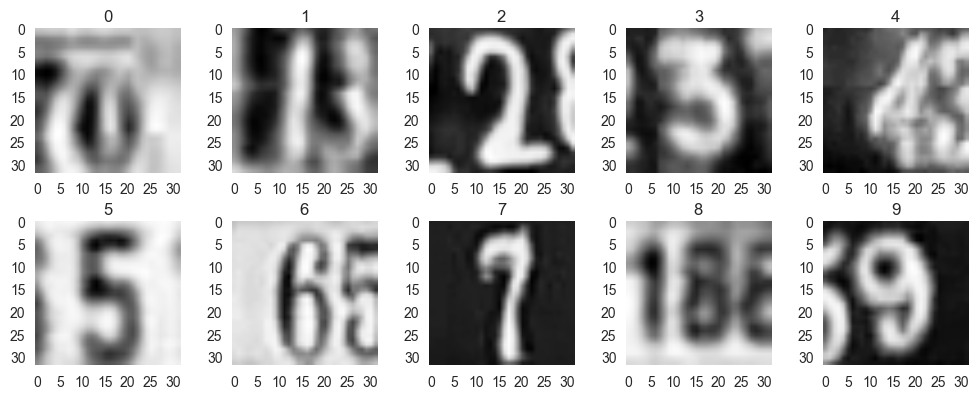

In [5]:
sns.set_style("dark")

print('training data examples')
fig = plt.figure(figsize=(10,4))
for i in range(10):
    ax = fig.add_subplot(2,5,i+1)
    index = np.random.choice(train_indices_by_class[i])
    train_indices[i] = index
    plt.imshow(train_dataset[index])
    ax.set_title(train_labels[index])
plt.tight_layout()
fig = plt.gcf()

validation data examples


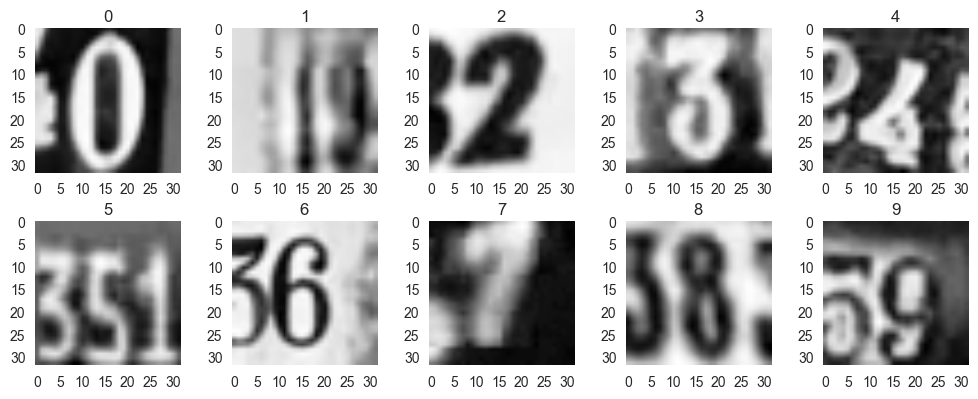

In [6]:
print('validation data examples')
fig = plt.figure(figsize=(10,4))
for i in range(10):
    ax = fig.add_subplot(2,5,i+1)
    index = np.random.choice(valid_indices_by_class[i])
    valid_indices[i] = index
    plt.imshow(valid_dataset[index])
    ax.set_title(valid_labels[index])
plt.tight_layout()
fig = plt.gcf()

testing data examples


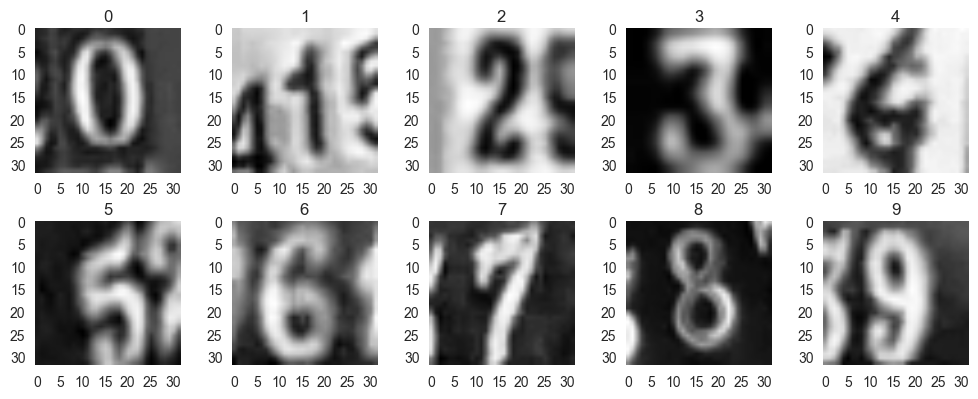

In [7]:
print('testing data examples')
fig = plt.figure(figsize=(10,4))
for i in range(10):
    ax = fig.add_subplot(2,5,i+1)
    index = np.random.choice(test_indices_by_class[i])
    test_indices[i] = index
    plt.imshow(test_dataset[index])
    ax.set_title(test_labels[index])
plt.tight_layout()
fig = plt.gcf()

,train data,valid data,test data
0,0.085886,0.084425,0.084840
1,0.170339,0.172127,0.171863
2,0.140792,0.140496,0.139592
3,0.114301,0.117224,0.113496
4,0.095279,0.094743,0.096852
5,0.100837,0.098885,0.100241
6,0.078311,0.079379,0.076819
7,0.082884,0.082543,0.082241
8,0.066537,0.067103,0.066652
9,0.064832,0.063074,0.067405


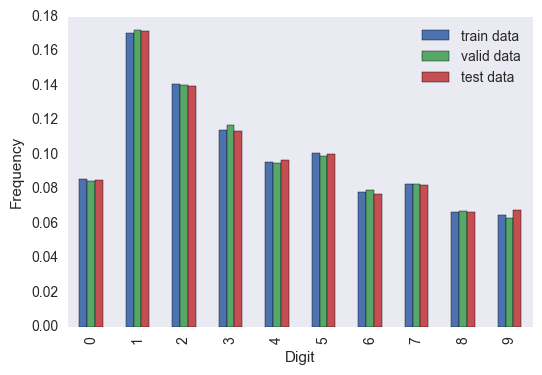

In [8]:
class_dist = np.zeros((num_labels,3))

class_dist[:,0] = np.bincount(train_labels)
class_dist[:,1] = np.bincount(valid_labels)
class_dist[:,2] = np.bincount( test_labels)
    
class_dist = np.divide(class_dist,np.sum(class_dist, axis=0))

class_dist_df = pd.DataFrame(
    index = np.arange(10),
    columns = ['train data', 'valid data', 'test data'],
    data = class_dist)
display(class_dist_df)

class_dist_df.plot(kind='bar').set(xlabel="Digit", ylabel="Frequency")
savefig('Figures/extra_only_digit_frequency.pdf')

So a prediction strategy where we always predict the digit 1 will lead to approximately 17% accuracy.

## 2.3 Train and Predict Using 'sklearn.linear_model.LogisticRegression()'

Let's get an idea of what an off-the-shelf classifier can give us on this data. We train a simple model ([sklearn.linear_model.LogisticRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)) using 50, 100, 1K, 2.5K, 5K, 10K and 20K training samples.

In [9]:
# Reshape our data (i.e. flatten the 32 x 32 images) so we can use SKLearn

n_samples = [50, 100, 1000, 2500, 5000, 10000, 20000]
n_samples_max = n_samples[-1]
n_features = train_dataset.shape[1] * train_dataset.shape[2]

X_train = np.reshape(train_dataset[:n_samples_max], (n_samples_max,      n_features) )
X_valid = np.reshape(valid_dataset                , (len(valid_dataset), n_features) )
X_test  = np.reshape( test_dataset                , (len(test_dataset) , n_features) )

In [10]:
logistic_classifier = linear_model.LogisticRegression()

acc_train = []
acc_valid = []
acc_test  = []

t1 = time.time()
for n in n_samples:
        
    logistic_classifier.fit(X_train[:n], train_labels[:n])
    
    y_pred = logistic_classifier.predict(X_train[:n])
    acc_train.append(accuracy_score(y_pred, train_labels[:n]))

    y_pred = logistic_classifier.predict(X_valid)
    acc_valid.append(accuracy_score(y_pred, valid_labels))

    y_pred  = logistic_classifier.predict(X_test)
    acc_test.append(accuracy_score(y_pred, test_labels))
    
    t2 = time.time()
    print(n, 'samples training and prediction complete, time taken =', t2-t1)
    t1 = t2

50 samples training and prediction complete, time taken = 0.236680030823
100 samples training and prediction complete, time taken = 0.316629886627
1000 samples training and prediction complete, time taken = 7.43443012238
2500 samples training and prediction complete, time taken = 29.4060230255
5000 samples training and prediction complete, time taken = 90.1040399075
10000 samples training and prediction complete, time taken = 267.012845993
20000 samples training and prediction complete, time taken = 609.61720705


,Train accuracy,Validation accuracy,Test accuracy
50,1.0000,0.165462,0.158608
100,1.0000,0.168211,0.166516
1000,0.8280,0.165273,0.164596
2500,0.6224,0.180223,0.178754
5000,0.4900,0.188733,0.190428
10000,0.3945,0.206997,0.208465
20000,0.3379,0.224733,0.225486


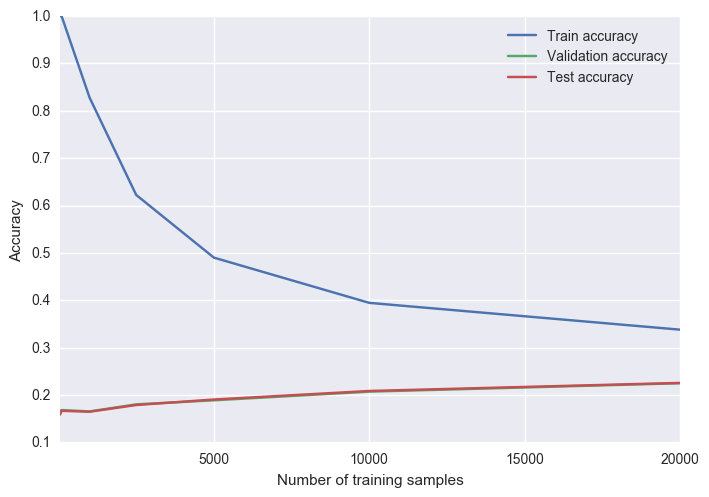

In [11]:
sns.set()

results = np.zeros((len(n_samples), 3))
results[:,0] = acc_train
results[:,1] = acc_valid
results[:,2] = acc_test
results_df = pd.DataFrame(
    index = n_samples,
    columns = ['Train accuracy', 'Validation accuracy', 'Test accuracy'],
    data = results)

display(results_df)
results_df.plot().set(xlabel='Number of training samples', ylabel='Accuracy')
savefig('Figures/SKLearnLogisticRegression.pdf')

The Sci-Kit Learn Logistic Regression classifier out of the box gives us 23% accuracy which, though an improvement on our strategy of always predicting the digit 1, is pretty poor. Looking at the trend of the graph above, adding more training examples doesn't look like it will help break the 30% mark. It looks like our model needs improving. The range of images which can represent a given digit is high so we need to increase the number of parameters in our model.

We will use neural newtorks, gradually increasing the complexity of our model.

## 2.4 Train and Predict using Neural Networks in Tensorflow

Reformat into a shape that's more adapted to the models we're going to train in Tensorflow:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [12]:
image_size = 32

def reformat(dataset, labels):
    dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
    labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
    return dataset, labels

train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset,   test_labels = reformat(test_dataset, test_labels)

print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (478017, 1024) (478017, 10)
Validation set (26556, 1024) (26556, 10)
Test set (26556, 1024) (26556, 10)


In [13]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1)) / predictions.shape[0])

### 2.4.1 Two-Layer (One Hidden) Neural Network

... with a decaying learning rate.

As a first step we optimise the validation accuracy learning rate. We calculate the validation accuracy for a range of values we optimise the initial learning rate and learning rate decay separately.

Initialized
step 0 calculated, time = 4.82526493073
step 500 calculated, time = 20.2450709343
step 1000 calculated, time = 33.6895170212
step 1500 calculated, time = 47.4046788216
step 2000 calculated, time = 64.1612360477
step 2500 calculated, time = 77.8873848915
step 3000 calculated, time = 91.9060950279
step 3500 calculated, time = 105.699756861
step 4000 calculated, time = 118.886620998
step 4500 calculated, time = 132.533041954
step 5000 calculated, time = 146.364449024
step 5500 calculated, time = 158.992329836
step 6000 calculated, time = 171.469923973
step 6500 calculated, time = 183.965519905
step 7000 calculated, time = 196.894741058
step 7500 calculated, time = 210.003823042
step 8000 calculated, time = 222.720458031
step 8500 calculated, time = 235.869477034
step 9000 calculated, time = 248.26370883
step 9500 calculated, time = 261.097633839
step 10000 calculated, time = 274.399829865


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,712.075,7.03125,15.3148,15.2207
500,48.5518,67.9688,69.826,69.7093
1000,32.5068,78.125,82.4409,82.5087
1500,10.077,82.8125,85.1107,85.2463
2000,12.6458,88.2812,86.0935,85.7396
2500,6.54916,83.5938,87.9048,87.8709
3000,6.64653,87.5,88.1194,88.3341
3500,5.98456,88.2812,88.9629,88.9027
4000,3.69483,86.7188,88.9968,89.0759
4500,3.09585,88.2812,89.6332,89.347


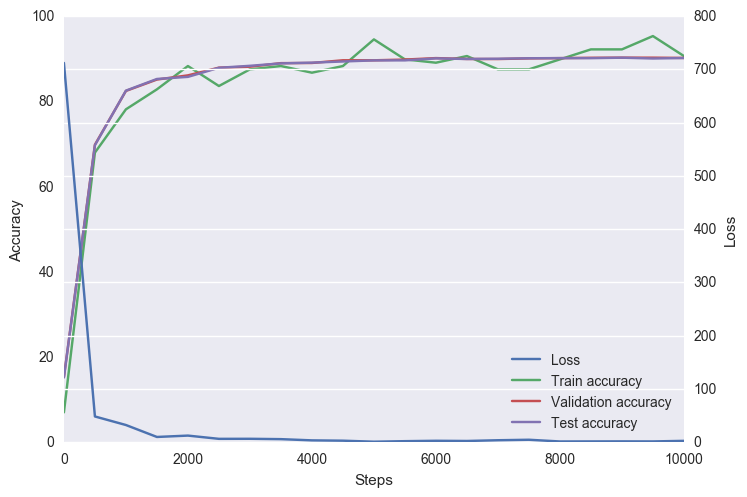

In [14]:
# Here we use the optimised initial learning rate and 

batch_size = 128
num_hnodes = 1024

initial_learning_rate = 0.12# 0.095 this value has been optimised
decay_steps = 1000
decay_rate = 0.6# 0.55 this value has been optimised

num_steps = 10001# 3001
step_steps = 500

results_df = pd.DataFrame(
    index = np.arange(0, num_steps, step_steps),
    columns = ['Loss', 'Train accuracy', 'Validation accuracy', 'Test accuracy'])

graph = tf.Graph()
with graph.as_default():

    # Input data.
    # For the training data, we use a placeholder that will be fed at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    h_weights = tf.Variable(tf.truncated_normal([image_size * image_size, num_hnodes]))
    h_biases = tf.Variable(tf.zeros([num_hnodes]))
    weights = tf.Variable(tf.truncated_normal([num_hnodes, num_labels]))
    biases = tf.Variable(tf.zeros([num_labels]))

    # Training computation.
    h_layer = tf.nn.relu(tf.matmul(tf_train_dataset, h_weights) + h_biases)
    logits = tf.matmul(h_layer, weights) + biases
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))

    # Optimizer.
    global_step = tf.Variable(0)  # count the number of steps taken.
    # decayed_learning_rate = learning_rate * decay_rate ^ (global_step / decay_steps)
    learning_rate = tf.train.exponential_decay( initial_learning_rate,
                                                global_step,
                                                decay_steps,
                                                decay_rate,
                                                staircase=True )
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(tf.matmul(tf.nn.relu(
                                     tf.matmul(tf_valid_dataset, h_weights) + h_biases),
                                                                   weights) +   biases)
    test_prediction = tf.nn.softmax(tf.matmul(tf.nn.relu(
                                    tf.matmul(tf_test_dataset, h_weights) + h_biases),
                                                                 weights) +   biases)

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized")
    t1 = time.time()
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % step_steps == 0):
            results_df['Loss'               ][step] = l
            results_df['Train accuracy'     ][step] = accuracy(predictions,             batch_labels)
            results_df['Validation accuracy'][step] = accuracy(valid_prediction.eval(), valid_labels)
            results_df['Test accuracy'      ][step] = accuracy(test_prediction.eval(),  test_labels)
            t2 = time.time()
            print('step', step, 'calculated, time =', t2-t1)                

display(results_df)

sns.set()

plt.figure()
ax = results_df.plot(secondary_y=['Loss'], mark_right=False)
ax.set(xlabel='Steps', ylabel='Accuracy')
ax.right_ax.set_ylabel('Loss')
savefig('Figures/two_layerNN.pdf')

In [39]:
# Find a good learning rate

batch_size = 128
num_hnodes = 1024

initial_learning_rate = 0.095
decay_steps = 1000
decay_rate = 0.55

num_steps = 10001
step_steps = 500

results_df = pd.DataFrame(
    index = np.arange(0, num_steps, step_steps),
    columns = ['Loss', 'Train accuracy', 'Validation accuracy', 'Test accuracy'])

initial_learning_rates = np.arange(0.01, 0.1, 0.01)
decay_rates            = np.arange(0.10, 1.0, 0.10)
lr_results_df = pd.DataFrame( index   = initial_learning_rates,
                              columns = decay_rates)

lr_index = dr_index = 0
for initial_learning_rate in initial_learning_rates:
    for decay_rate in decay_rates:
    
        graph = tf.Graph()
        with graph.as_default():

            # Input data.
            # For the training data, we use a placeholder that will be fed at run time with a training minibatch.
            tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
            tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
            tf_valid_dataset = tf.constant(valid_dataset)
            tf_test_dataset = tf.constant(test_dataset)

            # Variables.
            h_weights = tf.Variable(tf.truncated_normal([image_size * image_size, num_hnodes]))
            h_biases = tf.Variable(tf.zeros([num_hnodes]))
            weights = tf.Variable(tf.truncated_normal([num_hnodes, num_labels]))
            biases = tf.Variable(tf.zeros([num_labels]))

            # Training computation.
            h_layer = tf.nn.relu(tf.matmul(tf_train_dataset, h_weights) + h_biases)
            logits = tf.matmul(h_layer, weights) + biases
            loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))

            # Optimizer.
            global_step = tf.Variable(0)  # count the number of steps taken.
            # decayed_learning_rate = learning_rate * decay_rate ^ (global_step / decay_steps)
            learning_rate = tf.train.exponential_decay( initial_learning_rate,
                                                        global_step,
                                                        decay_steps,
                                                        decay_rate,
                                                        staircase=True )
            optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)

            # Predictions for the training, validation, and test data.
            train_prediction = tf.nn.softmax(logits)
            valid_prediction = tf.nn.softmax(tf.matmul(tf.nn.relu(
                                             tf.matmul(tf_valid_dataset, h_weights) + h_biases),
                                                                           weights) +   biases)
            test_prediction = tf.nn.softmax(tf.matmul(tf.nn.relu(
                                            tf.matmul(tf_test_dataset, h_weights) + h_biases),
                                                                         weights) +   biases)

        with tf.Session(graph=graph) as session:
            tf.initialize_all_variables().run()
            print("Initialized")
            t1 = time.time()
            for step in range(num_steps):
                # Pick an offset within the training data, which has been randomized.
                # Note: we could use better randomization across epochs.
                offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
                # Generate a minibatch.
                batch_data = train_dataset[offset:(offset + batch_size), :]
                batch_labels = train_labels[offset:(offset + batch_size), :]
                # Prepare a dictionary telling the session where to feed the minibatch.
                # The key of the dictionary is the placeholder node of the graph to be fed,
                # and the value is the numpy array to feed to it.
                feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
                _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
                if (step % step_steps == 0):
                    train_acc = accuracy(predictions,             batch_labels)
                    valid_acc = accuracy(valid_prediction.eval(), valid_labels)
                    test_acc  = accuracy(test_prediction.eval(),  test_labels)
                    results_df['Loss'               ][step] = l
                    results_df['Train accuracy'     ][step] = train_acc
                    results_df['Validation accuracy'][step] = valid_acc
                    results_df['Test accuracy'      ][step] = test_acc
                    t2 = time.time()
                    print('step', step, 'calculated, time =', t2-t1)
                if step == num_steps-1:
                    print('initial learning rate =', initial_learning_rate, 'decay rate =', decay_rate)
                    display(results_df)
                    lr_results_df[decay_rate][initial_learning_rate] = valid_acc
        dr_index +=1
    lr_index += 1

display(lr_results_df)

# Save our results to another DataFrame incase we want to plot them later
lr_results1_df = lr_results_df

Initialized
step 0 calculated, time = 3.54539299011
step 500 calculated, time = 18.2260351181
step 1000 calculated, time = 30.609719038
step 1500 calculated, time = 43.6408030987
step 2000 calculated, time = 56.2314200401
step 2500 calculated, time = 68.6361041069
step 3000 calculated, time = 81.0295231342
step 3500 calculated, time = 93.4779260159
step 4000 calculated, time = 105.822267056
step 4500 calculated, time = 118.202648163
step 5000 calculated, time = 130.546650171
step 5500 calculated, time = 143.450265169
step 6000 calculated, time = 155.97618103
step 6500 calculated, time = 168.877185106
step 7000 calculated, time = 181.392998219
step 7500 calculated, time = 194.481626034
step 8000 calculated, time = 207.575560093
step 8500 calculated, time = 220.36691618
step 9000 calculated, time = 232.87621212
step 9500 calculated, time = 245.589468002
step 10000 calculated, time = 258.18535614
initial learning rate = 0.01 decay rate = 0.1


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,787.086,6.25,9.23332,9.31993
500,65.0876,56.25,58.6647,57.9982
1000,62.9522,64.8438,68.5043,68.7302
1500,50.6571,64.0625,71.739,71.9122
2000,31.1788,78.9062,72.044,72.1607
2500,32.9268,70.3125,72.1457,72.3
3000,30.4372,75,72.2699,72.4356
3500,31.6643,70.3125,72.3038,72.4544
4000,34.1261,71.0938,72.3,72.4507
4500,31.8803,71.0938,72.2963,72.4507


Initialized
step 0 calculated, time = 3.15903496742
step 500 calculated, time = 15.4639949799
step 1000 calculated, time = 28.504379034
step 1500 calculated, time = 41.3529348373
step 2000 calculated, time = 54.0758349895
step 2500 calculated, time = 66.9814069271
step 3000 calculated, time = 79.4298198223
step 3500 calculated, time = 91.8559339046
step 4000 calculated, time = 104.240056992
step 4500 calculated, time = 117.271857977
step 5000 calculated, time = 129.794029951
step 5500 calculated, time = 142.618554831
step 6000 calculated, time = 154.946177006
step 6500 calculated, time = 167.786139011
step 7000 calculated, time = 180.532861948
step 7500 calculated, time = 193.509584904
step 8000 calculated, time = 206.577189922
step 8500 calculated, time = 218.931836843
step 9000 calculated, time = 232.207114935
step 9500 calculated, time = 244.564867973
step 10000 calculated, time = 256.868256807
initial learning rate = 0.01 decay rate = 0.2


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,745.345,15.625,9.91113,9.72662
500,52.1184,62.5,58.7024,59.1881
1000,57.156,64.8438,68.316,68.6512
1500,37.9642,71.875,72.108,72.2172
2000,36.5065,73.4375,72.5335,72.5938
2500,24.8477,81.25,73.1812,73.3281
3000,29.1953,81.25,73.2415,73.3582
3500,54.9938,66.4062,73.2942,73.4712
4000,29.702,73.4375,73.3657,73.4561
4500,24.9717,69.5312,73.377,73.4373


Initialized
step 0 calculated, time = 3.23400998116
step 500 calculated, time = 15.6415159702
step 1000 calculated, time = 27.8677370548
step 1500 calculated, time = 40.7889790535
step 2000 calculated, time = 53.2621791363
step 2500 calculated, time = 65.6486899853
step 3000 calculated, time = 78.5707170963
step 3500 calculated, time = 91.3286089897
step 4000 calculated, time = 104.229563951
step 4500 calculated, time = 117.275761127
step 5000 calculated, time = 130.108937025
step 5500 calculated, time = 142.89786315
step 6000 calculated, time = 155.594578028
step 6500 calculated, time = 168.470229149
step 7000 calculated, time = 181.472536087
step 7500 calculated, time = 194.216128111
step 8000 calculated, time = 207.172676086
step 8500 calculated, time = 220.159780979
step 9000 calculated, time = 232.716913939
step 9500 calculated, time = 245.472064018
step 10000 calculated, time = 258.020880938
initial learning rate = 0.01 decay rate = 0.3


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,714.489,10.9375,12.2646,12.1178
500,63.5816,60.9375,59.5233,59.4291
1000,64.2506,64.0625,68.1466,68.7265
1500,46.6993,71.0938,71.6975,72.0289
2000,29.2205,77.3438,72.7519,72.7557
2500,33.7598,74.2188,73.1172,73.2452
3000,33.0937,76.5625,73.4147,73.6594
3500,44.7976,71.0938,73.682,73.9193
4000,23.4132,77.3438,73.6105,73.9908
4500,25.9697,73.4375,73.6632,74.0887


Initialized
step 0 calculated, time = 3.20349383354
step 500 calculated, time = 15.868721962
step 1000 calculated, time = 28.2997479439
step 1500 calculated, time = 40.6407198906
step 2000 calculated, time = 53.4794299603
step 2500 calculated, time = 66.0479619503
step 3000 calculated, time = 78.5372238159
step 3500 calculated, time = 91.2327408791
step 4000 calculated, time = 104.179527998
step 4500 calculated, time = 117.030925989
step 5000 calculated, time = 129.447557926
step 5500 calculated, time = 144.817250967
step 6000 calculated, time = 160.552290916
step 6500 calculated, time = 173.457214832
step 7000 calculated, time = 186.261361837
step 7500 calculated, time = 198.540757895
step 8000 calculated, time = 210.875531912
step 8500 calculated, time = 223.274209976
step 9000 calculated, time = 236.196812868
step 9500 calculated, time = 248.562620878
step 10000 calculated, time = 261.009030819
initial learning rate = 0.01 decay rate = 0.4


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,765.548,10.9375,9.42537,9.47432
500,75.6526,54.6875,60.1785,60.0994
1000,58.9231,64.8438,68.9599,69.167
1500,30.0325,75,71.6411,71.7465
2000,25.9993,79.6875,72.6352,72.9138
2500,28.1569,71.875,73.8816,74.2506
3000,27.0846,75.7812,74.1414,74.5745
3500,42.0773,68.75,74.6197,74.887
4000,27.8389,79.6875,74.7778,74.9925
4500,21.0939,78.9062,74.7515,75.0301


Initialized
step 0 calculated, time = 3.2369120121
step 500 calculated, time = 15.7592720985
step 1000 calculated, time = 28.2908821106
step 1500 calculated, time = 40.7013189793
step 2000 calculated, time = 53.2858269215
step 2500 calculated, time = 65.7683489323
step 3000 calculated, time = 78.1162879467
step 3500 calculated, time = 90.4648470879
step 4000 calculated, time = 102.785043955
step 4500 calculated, time = 115.437365055
step 5000 calculated, time = 129.419284105
step 5500 calculated, time = 143.574033022
step 6000 calculated, time = 156.253436089
step 6500 calculated, time = 168.726893902
step 7000 calculated, time = 181.117996931
step 7500 calculated, time = 193.566911936
step 8000 calculated, time = 206.441453934
step 8500 calculated, time = 219.051733017
step 9000 calculated, time = 232.200335979
step 9500 calculated, time = 245.012135983
step 10000 calculated, time = 257.602884054
initial learning rate = 0.01 decay rate = 0.5


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,572.784,10.1562,10.8864,10.5889
500,63.3707,57.8125,59.2446,59.0111
1000,48.2849,67.1875,68.7867,68.7227
1500,34.5444,74.2188,71.8745,71.8557
2000,28.0999,75.7812,74.2657,74.1603
2500,25.9777,79.6875,75.0527,75.0038
3000,18.9507,78.125,75.2711,75.0339
3500,44.0629,72.6562,75.7155,75.6891
4000,24.4167,79.6875,76.1071,76.2012
4500,25.5518,74.2188,76.2916,76.2276


Initialized
step 0 calculated, time = 3.65440487862
step 500 calculated, time = 16.0022108555
step 1000 calculated, time = 28.2712440491
step 1500 calculated, time = 40.6399388313
step 2000 calculated, time = 53.1946458817
step 2500 calculated, time = 65.6251578331
step 3000 calculated, time = 78.2248048782
step 3500 calculated, time = 90.8014750481
step 4000 calculated, time = 103.125327826
step 4500 calculated, time = 115.512217045
step 5000 calculated, time = 127.795984983
step 5500 calculated, time = 140.075254917
step 6000 calculated, time = 152.37579298
step 6500 calculated, time = 164.908931971
step 7000 calculated, time = 177.190640926
step 7500 calculated, time = 189.599937916
step 8000 calculated, time = 202.105449915
step 8500 calculated, time = 214.401275873
step 9000 calculated, time = 226.726707935
step 9500 calculated, time = 238.981261015
step 10000 calculated, time = 251.302322865
initial learning rate = 0.01 decay rate = 0.6


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,637.662,9.375,11.3383,11.0107
500,74.9297,59.375,60.1408,60.4007
1000,57.4088,64.8438,68.124,68.3348
1500,40.0958,71.0938,71.4264,71.9687
2000,20.4097,79.6875,73.6406,74.0699
2500,25.1747,71.875,74.5782,74.8343
3000,15.4499,79.6875,75.4105,75.9715
3500,36.4345,73.4375,76.318,77.0108
4000,25.0238,75.7812,76.7171,77.2707
4500,25.6065,75.7812,77.041,77.474


Initialized
step 0 calculated, time = 3.20378708839
step 500 calculated, time = 15.5984940529
step 1000 calculated, time = 28.0665690899
step 1500 calculated, time = 40.5813598633
step 2000 calculated, time = 53.5721418858
step 2500 calculated, time = 66.6968998909
step 3000 calculated, time = 79.4210929871
step 3500 calculated, time = 92.0390160084
step 4000 calculated, time = 104.80041194
step 4500 calculated, time = 117.288948059
step 5000 calculated, time = 129.718513966
step 5500 calculated, time = 142.932415962
step 6000 calculated, time = 156.082599878
step 6500 calculated, time = 169.531482935
step 7000 calculated, time = 182.89655304
step 7500 calculated, time = 196.609602928
step 8000 calculated, time = 210.615045071
step 8500 calculated, time = 223.502191067
step 9000 calculated, time = 236.299970865
step 9500 calculated, time = 249.807170868
step 10000 calculated, time = 262.729588032
initial learning rate = 0.01 decay rate = 0.7


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,792.734,10.9375,11.3232,10.9994
500,81.0519,56.25,58.4011,58.3446
1000,52.4438,64.0625,69.1219,69.4306
1500,34.4163,70.3125,72.2436,72.6013
2000,28.8866,82.0312,73.8477,74.5067
2500,25.9629,75.7812,75.1092,75.5159
3000,12.0557,85.1562,75.531,76.1109
3500,40.4547,71.0938,76.8866,77.4251
4000,26.4571,77.3438,77.4062,77.8807
4500,21.5593,81.25,77.361,77.7602


Initialized
step 0 calculated, time = 3.41890311241
step 500 calculated, time = 17.5631341934
step 1000 calculated, time = 31.2477002144
step 1500 calculated, time = 48.1089570522
step 2000 calculated, time = 60.8226370811
step 2500 calculated, time = 73.2440021038
step 3000 calculated, time = 85.535449028
step 3500 calculated, time = 98.0185751915
step 4000 calculated, time = 110.318908215
step 4500 calculated, time = 123.4171381
step 5000 calculated, time = 136.021257162
step 5500 calculated, time = 149.04145813
step 6000 calculated, time = 161.938176155
step 6500 calculated, time = 174.891077042
step 7000 calculated, time = 187.804321051
step 7500 calculated, time = 200.102939129
step 8000 calculated, time = 212.42884922
step 8500 calculated, time = 225.158008099
step 9000 calculated, time = 237.491450071
step 9500 calculated, time = 250.024286032
step 10000 calculated, time = 263.889481068
initial learning rate = 0.01 decay rate = 0.8


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,712.244,9.375,13.4508,13.4056
500,66.7829,60.9375,57.8928,57.3128
1000,50.4312,68.75,67.0244,66.7269
1500,39.055,73.4375,72.1419,72.2134
2000,26.3077,80.4688,74.5971,74.567
2500,23.7136,77.3438,76.0468,75.6515
3000,17.1216,82.8125,76.5891,76.5251
3500,30.7737,74.2188,78.0426,78.0765
4000,17.219,78.125,78.9275,78.6338
4500,20.6553,78.125,78.6903,78.743


Initialized
step 0 calculated, time = 3.28095579147
step 500 calculated, time = 17.5900537968
step 1000 calculated, time = 30.9126908779
step 1500 calculated, time = 43.8920648098
step 2000 calculated, time = 56.7209398746
step 2500 calculated, time = 69.5885219574
step 3000 calculated, time = 82.0125789642
step 3500 calculated, time = 94.9506800175
step 4000 calculated, time = 107.752144814
step 4500 calculated, time = 120.651458979
step 5000 calculated, time = 133.397604942
step 5500 calculated, time = 145.949766874
step 6000 calculated, time = 158.947253942
step 6500 calculated, time = 173.365268946
step 7000 calculated, time = 186.614240885
step 7500 calculated, time = 199.450402021
step 8000 calculated, time = 214.657150984
step 8500 calculated, time = 227.025856018
step 9000 calculated, time = 240.085562944
step 9500 calculated, time = 253.177143812
step 10000 calculated, time = 266.383773804
initial learning rate = 0.01 decay rate = 0.9


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,1109.78,11.7188,10.0467,9.7831
500,57.5952,57.8125,59.3839,59.1881
1000,49.0301,71.875,67.2353,67.1901
1500,35.0231,71.875,72.2398,72.4657
2000,27.6245,82.0312,73.9117,74.1942
2500,21.505,78.9062,76.2464,76.3782
3000,16.2183,82.8125,76.7661,76.8866
3500,32.981,74.2188,78.0238,78.3552
4000,23.7548,82.0312,78.728,78.92
4500,11.6235,85.1562,79.643,79.8012


Initialized
step 0 calculated, time = 3.27382421494
step 500 calculated, time = 15.7026891708
step 1000 calculated, time = 28.7471821308
step 1500 calculated, time = 41.6517791748
step 2000 calculated, time = 54.8378582001
step 2500 calculated, time = 67.7657601833
step 3000 calculated, time = 80.7438452244
step 3500 calculated, time = 93.7227602005
step 4000 calculated, time = 106.451856136
step 4500 calculated, time = 118.779046059
step 5000 calculated, time = 131.247920036
step 5500 calculated, time = 143.970427036
step 6000 calculated, time = 156.737223148
step 6500 calculated, time = 169.814470053
step 7000 calculated, time = 184.65113616
step 7500 calculated, time = 198.383125067
step 8000 calculated, time = 211.460783005
step 8500 calculated, time = 224.634110212
step 9000 calculated, time = 239.095659018
step 9500 calculated, time = 254.128804207
step 10000 calculated, time = 267.96770215
initial learning rate = 0.02 decay rate = 0.1


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,616.698,7.8125,13.2964,13.6843
500,56.8297,67.9688,67.9169,68.0148
1000,41.1922,67.1875,74.1226,74.1452
1500,26.6329,77.3438,78.8748,79.1723
2000,29.8084,79.6875,79.0706,79.3493
2500,21.2445,75,79.1685,79.6468
3000,21.164,82.8125,79.2213,79.6468
3500,34.362,76.5625,79.2288,79.6844
4000,24.2057,82.8125,79.2363,79.6995
4500,14.718,81.25,79.2363,79.692


Initialized
step 0 calculated, time = 3.17975592613
step 500 calculated, time = 15.5849909782
step 1000 calculated, time = 28.022685051
step 1500 calculated, time = 41.2083878517
step 2000 calculated, time = 53.5748579502
step 2500 calculated, time = 66.07396698
step 3000 calculated, time = 78.5341570377
step 3500 calculated, time = 90.8396010399
step 4000 calculated, time = 103.780503988
step 4500 calculated, time = 116.509325027
step 5000 calculated, time = 129.202569962
step 5500 calculated, time = 141.980988026
step 6000 calculated, time = 154.708420038
step 6500 calculated, time = 167.623818874
step 7000 calculated, time = 180.396567822
step 7500 calculated, time = 193.481441975
step 8000 calculated, time = 206.01680994
step 8500 calculated, time = 218.947129011
step 9000 calculated, time = 231.913848877
step 9500 calculated, time = 244.820924997
step 10000 calculated, time = 259.699265003
initial learning rate = 0.02 decay rate = 0.2


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,629.758,10.9375,10.5362,10.5325
500,52.4935,69.5312,68.6587,69.0051
1000,36.3577,75,75.7042,76.1862
1500,25.9076,78.9062,78.3288,78.9765
2000,24.5172,80.4688,78.7958,79.4886
2500,18.1512,82.8125,78.984,79.8388
3000,18.776,83.5938,79.1271,79.9179
3500,27.5246,75,79.21,79.9405
4000,13.7505,83.5938,79.2552,79.82
4500,14.4937,83.5938,79.3154,79.933


Initialized
step 0 calculated, time = 3.22441887856
step 500 calculated, time = 16.8783209324
step 1000 calculated, time = 30.5222828388
step 1500 calculated, time = 45.894356966
step 2000 calculated, time = 60.0938940048
step 2500 calculated, time = 73.542953968
step 3000 calculated, time = 86.5940380096
step 3500 calculated, time = 99.0242860317
step 4000 calculated, time = 112.016709805
step 4500 calculated, time = 124.809204817
step 5000 calculated, time = 138.019304037
step 5500 calculated, time = 150.81566
step 6000 calculated, time = 163.250801802
step 6500 calculated, time = 175.96099782
step 7000 calculated, time = 189.381711006
step 7500 calculated, time = 201.882603884
step 8000 calculated, time = 214.875063896
step 8500 calculated, time = 228.306226015
step 9000 calculated, time = 243.142490864
step 9500 calculated, time = 256.860679865
step 10000 calculated, time = 269.656154871
initial learning rate = 0.02 decay rate = 0.3


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,626.167,14.8438,10.5965,10.2011
500,47.0875,69.5312,68.7453,68.365
1000,33.0839,75.7812,76.3481,76.2276
1500,32.3215,75.7812,78.743,78.6075
2000,30.4617,80.4688,79.338,79.3794
2500,15.8771,78.9062,79.9669,79.8049
3000,21.9298,85.1562,80.2945,80.2606
3500,30.1568,75,80.4526,80.3698
4000,16.7124,78.9062,80.5468,80.4941
4500,17.1322,82.8125,80.5731,80.4639


Initialized
step 0 calculated, time = 3.32238316536
step 500 calculated, time = 15.8586621284
step 1000 calculated, time = 28.3862202168
step 1500 calculated, time = 41.1422472
step 2000 calculated, time = 55.205302
step 2500 calculated, time = 68.0837202072
step 3000 calculated, time = 80.9762132168
step 3500 calculated, time = 93.863615036
step 4000 calculated, time = 106.829005003
step 4500 calculated, time = 120.53134799
step 5000 calculated, time = 133.508187056
step 5500 calculated, time = 148.87917614
step 6000 calculated, time = 161.474584103
step 6500 calculated, time = 174.084744215
step 7000 calculated, time = 187.727699995
step 7500 calculated, time = 200.710493088
step 8000 calculated, time = 213.197756052
step 8500 calculated, time = 226.398831129
step 9000 calculated, time = 240.179374218
step 9500 calculated, time = 253.096212149
step 10000 calculated, time = 265.957093
initial learning rate = 0.02 decay rate = 0.4


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,601.488,13.2812,13.6203,13.7483
500,58.7876,70.3125,67.6307,67.7286
1000,43.7258,72.6562,75.7983,75.6703
1500,29.5548,73.4375,78.133,78.2912
2000,28.2186,83.5938,79.3568,79.6694
2500,19.1637,78.9062,79.9518,80.1853
3000,10.5735,87.5,80.4602,80.6635
3500,22.6925,77.3438,80.4865,80.8894
4000,20.0881,78.9062,80.5543,80.848
4500,14.8181,85.1562,80.7501,81.0062


Initialized
step 0 calculated, time = 3.28961801529
step 500 calculated, time = 16.9489920139
step 1000 calculated, time = 33.1162610054
step 1500 calculated, time = 46.8957469463
step 2000 calculated, time = 62.3830749989
step 2500 calculated, time = 76.2243180275
step 3000 calculated, time = 89.1351320744
step 3500 calculated, time = 104.280323982
step 4000 calculated, time = 118.818970919
step 4500 calculated, time = 132.205487967
step 5000 calculated, time = 145.378335953
step 5500 calculated, time = 158.419706106
step 6000 calculated, time = 171.641024113
step 6500 calculated, time = 185.038465977
step 7000 calculated, time = 197.7326231
step 7500 calculated, time = 210.30735898
step 8000 calculated, time = 223.059384108
step 8500 calculated, time = 237.075051069
step 9000 calculated, time = 252.575660944
step 9500 calculated, time = 265.46065402
step 10000 calculated, time = 278.021981001
initial learning rate = 0.02 decay rate = 0.5


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,738.526,10.1562,9.78687,10.1973
500,41.5376,71.0938,69.9842,69.8825
1000,36.8796,75,74.823,74.8531
1500,31.0789,73.4375,77.9372,77.715
2000,23.2645,83.5938,79.0593,79.4246
2500,17.1256,79.6875,80.3698,80.1589
3000,16.9662,84.375,80.7012,80.592
3500,28.4767,75.7812,81.3263,81.1794
4000,19.7319,79.6875,81.6501,81.3865
4500,11.3349,83.5938,81.7894,81.6388


Initialized
step 0 calculated, time = 3.28201794624
step 500 calculated, time = 17.5674369335
step 1000 calculated, time = 32.0250120163
step 1500 calculated, time = 45.6607098579
step 2000 calculated, time = 59.226706028
step 2500 calculated, time = 71.9289190769
step 3000 calculated, time = 84.6209449768
step 3500 calculated, time = 97.5451588631
step 4000 calculated, time = 110.227824926
step 4500 calculated, time = 122.805222034
step 5000 calculated, time = 135.53512907
step 5500 calculated, time = 148.367748976
step 6000 calculated, time = 160.593333006
step 6500 calculated, time = 173.260248899
step 7000 calculated, time = 186.024275064
step 7500 calculated, time = 198.707126856
step 8000 calculated, time = 212.316226959
step 8500 calculated, time = 225.507070065
step 9000 calculated, time = 238.091942072
step 9500 calculated, time = 250.806388855
step 10000 calculated, time = 263.230880976
initial learning rate = 0.02 decay rate = 0.6


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,705.903,13.2812,10.4609,10.7283
500,53.2095,65.625,67.0282,66.9717
1000,41.9117,73.4375,75.433,75.5121
1500,24.6185,78.125,77.8732,77.8732
2000,27.2763,81.25,79.1497,79.3606
2500,14.6047,81.25,80.6409,80.7689
3000,12.2664,84.375,80.9572,81.2246
3500,25.4961,78.125,81.7254,82.0643
4000,17.1696,81.25,81.9288,82.0342
4500,9.42784,85.1562,82.2978,82.3392


Initialized
step 0 calculated, time = 3.22460889816
step 500 calculated, time = 16.0402460098
step 1000 calculated, time = 28.8821489811
step 1500 calculated, time = 42.2210099697
step 2000 calculated, time = 56.2750370502
step 2500 calculated, time = 68.8837058544
step 3000 calculated, time = 81.2945418358
step 3500 calculated, time = 93.9833509922
step 4000 calculated, time = 106.701653957
step 4500 calculated, time = 119.386949062
step 5000 calculated, time = 132.420826912
step 5500 calculated, time = 145.266891956
step 6000 calculated, time = 157.945730925
step 6500 calculated, time = 170.675657034
step 7000 calculated, time = 183.436517
step 7500 calculated, time = 196.251459837
step 8000 calculated, time = 208.990779877
step 8500 calculated, time = 221.782763958
step 9000 calculated, time = 234.660167933
step 9500 calculated, time = 247.382986069
step 10000 calculated, time = 260.128973961
initial learning rate = 0.02 decay rate = 0.7


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,663.258,7.03125,12.9538,13.2512
500,43.2965,68.75,68.4102,68.5532
1000,36.1208,74.2188,75.9226,76.3067
1500,22.6302,77.3438,78.502,78.7619
2000,19.6697,86.7188,78.9727,79.0593
2500,22.5128,80.4688,80.7576,80.848
3000,13.0013,83.5938,81.7631,82.1133
3500,21.4201,76.5625,82.0493,82.3806
4000,14.4047,83.5938,82.1773,82.7195
4500,10.5972,86.7188,82.4258,82.712


Initialized
step 0 calculated, time = 3.22112894058
step 500 calculated, time = 16.3675940037
step 1000 calculated, time = 29.986768961
step 1500 calculated, time = 42.8660299778
step 2000 calculated, time = 55.5250968933
step 2500 calculated, time = 68.1787650585
step 3000 calculated, time = 80.9420340061
step 3500 calculated, time = 93.9175019264
step 4000 calculated, time = 106.650784969
step 4500 calculated, time = 119.132927895
step 5000 calculated, time = 132.146152973
step 5500 calculated, time = 144.902801991
step 6000 calculated, time = 157.697525024
step 6500 calculated, time = 171.338546991
step 7000 calculated, time = 184.170366049
step 7500 calculated, time = 196.938740015
step 8000 calculated, time = 209.758025885
step 8500 calculated, time = 222.643913031
step 9000 calculated, time = 237.584287882
step 9500 calculated, time = 254.080518961
step 10000 calculated, time = 267.363739014
initial learning rate = 0.02 decay rate = 0.8


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,773.362,7.8125,10.4722,10.5852
500,53.1435,63.2812,67.7813,67.7662
1000,37.4987,72.6562,75.192,75.5498
1500,30.0209,67.1875,77.4251,77.5832
2000,19.0504,82.8125,79.0142,79.5225
2500,16.6786,84.375,80.912,81.074
3000,10.7351,83.5938,80.912,81.5898
3500,21.9132,78.9062,82.3656,83.0471
4000,13.5151,82.8125,82.5426,83.0471
4500,13.7428,82.8125,82.3995,82.9229


Initialized
step 0 calculated, time = 3.348913908
step 500 calculated, time = 16.4396219254
step 1000 calculated, time = 29.4561469555
step 1500 calculated, time = 42.1872079372
step 2000 calculated, time = 54.7719008923
step 2500 calculated, time = 67.7053439617
step 3000 calculated, time = 80.524766922
step 3500 calculated, time = 93.3512370586
step 4000 calculated, time = 105.848700047
step 4500 calculated, time = 118.382171869
step 5000 calculated, time = 131.445775986
step 5500 calculated, time = 144.168612957
step 6000 calculated, time = 157.074189901
step 6500 calculated, time = 172.235517025
step 7000 calculated, time = 185.734783888
step 7500 calculated, time = 198.467542887
step 8000 calculated, time = 211.238199949
step 8500 calculated, time = 224.817466021
step 9000 calculated, time = 237.385504961
step 9500 calculated, time = 250.368371964
step 10000 calculated, time = 263.406966925
initial learning rate = 0.02 decay rate = 0.9


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,939.408,8.59375,9.35758,9.17683
500,42.8874,68.75,68.5608,68.365
1000,42.523,77.3438,75.049,74.8983
1500,29.5369,75.7812,78.0276,78.6564
2000,20.0663,85.9375,80.6635,80.7388
2500,24.9725,77.3438,80.0836,80.2643
3000,15.9805,84.375,81.0175,81.3827
3500,23.616,78.9062,82.471,82.7308
4000,12.9314,82.8125,83.1676,83.5291
4500,13.3448,82.8125,83.6421,84.0074


Initialized
step 0 calculated, time = 3.31755495071
step 500 calculated, time = 16.4844329357
step 1000 calculated, time = 29.5723860264
step 1500 calculated, time = 42.2445580959
step 2000 calculated, time = 55.0208890438
step 2500 calculated, time = 67.9831440449
step 3000 calculated, time = 80.9969980717
step 3500 calculated, time = 93.8354201317
step 4000 calculated, time = 106.585807085
step 4500 calculated, time = 119.503252029
step 5000 calculated, time = 132.431230068
step 5500 calculated, time = 144.936737061
step 6000 calculated, time = 157.936576128
step 6500 calculated, time = 170.545376062
step 7000 calculated, time = 182.877500057
step 7500 calculated, time = 195.590728998
step 8000 calculated, time = 208.228120089
step 8500 calculated, time = 221.3896451
step 9000 calculated, time = 234.003824949
step 9500 calculated, time = 246.519772053
step 10000 calculated, time = 259.48178792
initial learning rate = 0.03 decay rate = 0.1


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,752.044,16.4062,12.9613,13.0027
500,41.37,76.5625,72.6502,72.6352
1000,41.1293,75.7812,76.2954,76.1673
1500,18.7818,80.4688,81.5221,81.9325
2000,20.0332,86.7188,81.8647,82.0756
2500,14.9633,83.5938,82.1246,82.4183
3000,11.2567,87.5,82.1848,82.5237
3500,28.7625,75,82.1923,82.5087
4000,13.2841,85.9375,82.1773,82.5162
4500,8.13541,89.0625,82.1811,82.5237


Initialized
step 0 calculated, time = 3.43500804901
step 500 calculated, time = 16.0663039684
step 1000 calculated, time = 28.9710111618
step 1500 calculated, time = 41.7675631046
step 2000 calculated, time = 54.6613099575
step 2500 calculated, time = 67.5466110706
step 3000 calculated, time = 80.1490581036
step 3500 calculated, time = 92.8142280579
step 4000 calculated, time = 105.559718132
step 4500 calculated, time = 118.854473114
step 5000 calculated, time = 131.541690111
step 5500 calculated, time = 144.22409606
step 6000 calculated, time = 156.86344409
step 6500 calculated, time = 169.556427956
step 7000 calculated, time = 182.504042149
step 7500 calculated, time = 195.198517084
step 8000 calculated, time = 207.861078978
step 8500 calculated, time = 220.498996019
step 9000 calculated, time = 234.548382044
step 9500 calculated, time = 247.582015991
step 10000 calculated, time = 260.507851124
initial learning rate = 0.03 decay rate = 0.2


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,848.335,12.5,12.9123,12.4831
500,47.028,71.0938,69.9541,69.6566
1000,29.9436,81.25,77.5606,77.4326
1500,19.0201,76.5625,81.62,81.861
2000,23.3098,83.5938,81.443,81.9062
2500,12.4927,85.1562,82.5651,82.9718
3000,12.7297,89.0625,82.6518,83.0961
3500,26.4075,79.6875,82.7346,83.0246
4000,16.6458,84.375,82.7497,83.0471
4500,15.9094,86.7188,82.7723,83.0848


Initialized
step 0 calculated, time = 3.29141378403
step 500 calculated, time = 16.2726778984
step 1000 calculated, time = 29.0253958702
step 1500 calculated, time = 42.7662069798
step 2000 calculated, time = 55.4966638088
step 2500 calculated, time = 68.7335197926
step 3000 calculated, time = 81.6695327759
step 3500 calculated, time = 94.7159249783
step 4000 calculated, time = 107.668119907
step 4500 calculated, time = 120.408571005
step 5000 calculated, time = 133.426105976
step 5500 calculated, time = 146.408679008
step 6000 calculated, time = 159.107097864
step 6500 calculated, time = 171.953547001
step 7000 calculated, time = 184.68064785
step 7500 calculated, time = 197.366225958
step 8000 calculated, time = 210.482539892
step 8500 calculated, time = 223.082698822
step 9000 calculated, time = 235.596123934
step 9500 calculated, time = 248.358204842
step 10000 calculated, time = 261.579391003
initial learning rate = 0.03 decay rate = 0.3


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,645.401,13.2812,11.0822,10.845
500,31.6081,71.875,71.4001,71.4001
1000,40.0044,77.3438,78.679,78.8146
1500,14.5732,82.8125,80.8292,81.0175
2000,24.44,83.5938,81.7066,81.9852
2500,17.8707,79.6875,82.7271,83.0133
3000,15.2265,82.8125,82.7421,83.1036
3500,25.6059,78.125,83.081,83.2731
4000,13.1524,82.8125,83.0735,83.2656
4500,12.7596,85.1562,83.0886,83.3107


Initialized
step 0 calculated, time = 3.29405808449
step 500 calculated, time = 15.9392681122
step 1000 calculated, time = 29.0938880444
step 1500 calculated, time = 41.8600449562
step 2000 calculated, time = 54.9274508953
step 2500 calculated, time = 67.9418349266
step 3000 calculated, time = 80.608299017
step 3500 calculated, time = 93.5412299633
step 4000 calculated, time = 106.189696074
step 4500 calculated, time = 119.290574074
step 5000 calculated, time = 131.795320034
step 5500 calculated, time = 144.672241926
step 6000 calculated, time = 157.463881969
step 6500 calculated, time = 170.067452908
step 7000 calculated, time = 182.372984886
step 7500 calculated, time = 194.987926006
step 8000 calculated, time = 207.771646976
step 8500 calculated, time = 220.403744936
step 9000 calculated, time = 233.131596088
step 9500 calculated, time = 246.297337055
step 10000 calculated, time = 258.897587061
initial learning rate = 0.03 decay rate = 0.4


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,635.99,12.5,12.5207,12.9876
500,43.5438,68.75,70.3269,70.244
1000,34.2456,75.7812,78.4644,78.5472
1500,16.2433,82.8125,80.9798,81.3413
2000,16.0612,84.375,82.4559,82.7007
2500,14.4742,82.0312,83.0321,83.1714
3000,15.985,86.7188,83.2241,83.3973
3500,16.6959,81.25,83.8831,83.8455
4000,15.2177,84.375,83.7777,84.0375
4500,11.4454,86.7188,83.8756,84.0149


Initialized
step 0 calculated, time = 3.2329928875
step 500 calculated, time = 15.9877099991
step 1000 calculated, time = 28.7153599262
step 1500 calculated, time = 41.5645689964
step 2000 calculated, time = 54.5662047863
step 2500 calculated, time = 71.7353029251
step 3000 calculated, time = 87.4436178207
step 3500 calculated, time = 99.837720871
step 4000 calculated, time = 112.242683887
step 4500 calculated, time = 125.176296949
step 5000 calculated, time = 137.601779938
step 5500 calculated, time = 149.963957787
step 6000 calculated, time = 162.482620001
step 6500 calculated, time = 174.73108983
step 7000 calculated, time = 187.072263002
step 7500 calculated, time = 199.364264965
step 8000 calculated, time = 212.092935801
step 8500 calculated, time = 224.575523853
step 9000 calculated, time = 237.978041887
step 9500 calculated, time = 251.10823679
step 10000 calculated, time = 264.121524811
initial learning rate = 0.03 decay rate = 0.5


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,746.963,7.8125,13.0592,13.3868
500,40.3979,71.875,70.47,70.5302
1000,31.0662,79.6875,78.7656,78.5058
1500,24.3863,81.25,80.9459,80.9459
2000,24.4682,86.7188,81.7216,81.9739
2500,15.7441,84.375,83.0396,83.2693
3000,9.98445,90.625,83.1451,83.3258
3500,21.9789,76.5625,83.917,84.1279
4000,8.71022,86.7188,83.8643,84.0262
4500,9.62891,85.9375,84.1091,84.2032


Initialized
step 0 calculated, time = 3.37490820885
step 500 calculated, time = 16.3268182278
step 1000 calculated, time = 29.1479201317
step 1500 calculated, time = 41.5390501022
step 2000 calculated, time = 54.0236651897
step 2500 calculated, time = 67.10237813
step 3000 calculated, time = 79.6472480297
step 3500 calculated, time = 92.3861620426
step 4000 calculated, time = 104.904422045
step 4500 calculated, time = 118.202758074
step 5000 calculated, time = 131.541220188
step 5500 calculated, time = 144.876216173
step 6000 calculated, time = 157.840833187
step 6500 calculated, time = 170.654386044
step 7000 calculated, time = 183.563529015
step 7500 calculated, time = 196.730237007
step 8000 calculated, time = 209.595694065
step 8500 calculated, time = 222.323968172
step 9000 calculated, time = 235.238075018
step 9500 calculated, time = 247.952021122
step 10000 calculated, time = 260.918083191
initial learning rate = 0.03 decay rate = 0.6


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,844.075,9.375,10.3366,10.491
500,32.6194,73.4375,70.1461,70.116
1000,35.2162,73.4375,77.5757,77.8581
1500,22.7495,76.5625,80.0949,80.5468
2000,28.202,83.5938,81.3752,81.9137
2500,12.5067,84.375,82.825,83.2768
3000,14.1549,85.1562,82.8965,83.1262
3500,22.0857,78.9062,83.9886,84.2559
4000,6.01167,84.375,83.804,84.3877
4500,12.7965,85.9375,84.1015,84.5609


Initialized
step 0 calculated, time = 3.30344891548
step 500 calculated, time = 16.2776708603
step 1000 calculated, time = 29.1924278736
step 1500 calculated, time = 41.6655569077
step 2000 calculated, time = 54.7647857666
step 2500 calculated, time = 67.6618278027
step 3000 calculated, time = 80.4741339684
step 3500 calculated, time = 93.6803209782
step 4000 calculated, time = 106.942228794
step 4500 calculated, time = 119.705846786
step 5000 calculated, time = 132.254062891
step 5500 calculated, time = 145.436455965
step 6000 calculated, time = 158.474890947
step 6500 calculated, time = 171.426898956
step 7000 calculated, time = 184.100154877
step 7500 calculated, time = 196.37752986
step 8000 calculated, time = 209.205800772
step 8500 calculated, time = 221.649595976
step 9000 calculated, time = 234.704305887
step 9500 calculated, time = 247.360488892
step 10000 calculated, time = 260.575027943
initial learning rate = 0.03 decay rate = 0.7


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,635.401,10.1562,12.9839,12.9048
500,43.1597,71.875,72.2059,72.3113
1000,33.7286,80.4688,78.1782,78.0765
1500,19.7985,80.4688,81.0664,80.9045
2000,18.8783,85.1562,82.1246,82.166
2500,14.0552,80.4688,83.1149,83.2693
3000,16.1931,86.7188,83.4877,83.6572
3500,18.5031,85.9375,84.0036,84.5459
4000,10.4051,85.9375,84.3613,84.6626
4500,10.4758,87.5,84.8584,85.0731


Initialized
step 0 calculated, time = 3.34165477753
step 500 calculated, time = 16.3147778511
step 1000 calculated, time = 29.1508829594
step 1500 calculated, time = 41.7982997894
step 2000 calculated, time = 54.4735169411
step 2500 calculated, time = 67.1980469227
step 3000 calculated, time = 79.9363110065
step 3500 calculated, time = 93.7796418667
step 4000 calculated, time = 108.175686836
step 4500 calculated, time = 121.313356876
step 5000 calculated, time = 134.293560982
step 5500 calculated, time = 146.938941956
step 6000 calculated, time = 159.646633863
step 6500 calculated, time = 172.513656855
step 7000 calculated, time = 186.584528923
step 7500 calculated, time = 200.026304007
step 8000 calculated, time = 213.00493598
step 8500 calculated, time = 226.02401495
step 9000 calculated, time = 238.941210985
step 9500 calculated, time = 251.733495951
step 10000 calculated, time = 264.372595787
initial learning rate = 0.03 decay rate = 0.8


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,853.286,8.59375,10.6831,10.3555
500,38.8098,80.4688,73.0343,72.6427
1000,31.2829,79.6875,77.2293,77.0636
1500,22.6128,76.5625,79.948,79.9141
2000,24.146,83.5938,80.5995,80.6597
2500,12.456,78.125,82.4032,82.8626
3000,12.5573,85.1562,82.7007,83.0697
3500,17.5444,79.6875,84.4367,84.7191
4000,9.69855,85.1562,84.6061,84.64
4500,7.74998,88.2812,84.6814,84.753


Initialized
step 0 calculated, time = 3.36039018631
step 500 calculated, time = 15.9249000549
step 1000 calculated, time = 28.6193311214
step 1500 calculated, time = 41.4465889931
step 2000 calculated, time = 54.2759330273
step 2500 calculated, time = 67.2449800968
step 3000 calculated, time = 80.1910390854
step 3500 calculated, time = 92.9541881084
step 4000 calculated, time = 105.699964046
step 4500 calculated, time = 118.439653158
step 5000 calculated, time = 131.223796129
step 5500 calculated, time = 143.989670038
step 6000 calculated, time = 156.710774183
step 6500 calculated, time = 169.47747016
step 7000 calculated, time = 182.275866032
step 7500 calculated, time = 195.009140015
step 8000 calculated, time = 207.821009159
step 8500 calculated, time = 220.572580099
step 9000 calculated, time = 233.44036603
step 9500 calculated, time = 246.300956964
step 10000 calculated, time = 259.091921091
initial learning rate = 0.03 decay rate = 0.9


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,745.62,10.9375,12.7918,12.2044
500,40.8679,73.4375,72.718,72.4733
1000,27.6007,81.25,75.4556,75.1205
1500,17.2584,82.8125,80.3133,80.302
2000,21.6074,84.375,81.9777,81.7405
2500,11.3414,80.4688,83.002,82.3128
3000,8.67169,88.2812,83.7551,83.6383
3500,16.1934,81.25,84.8848,84.9337
4000,10.7988,85.9375,84.9337,84.9751
4500,11.3142,82.8125,85.3291,85.1559


Initialized
step 0 calculated, time = 3.1246471405
step 500 calculated, time = 15.8815281391
step 1000 calculated, time = 28.598541975
step 1500 calculated, time = 41.3679480553
step 2000 calculated, time = 54.1252789497
step 2500 calculated, time = 66.7955110073
step 3000 calculated, time = 79.6806800365
step 3500 calculated, time = 92.6535770893
step 4000 calculated, time = 105.78430295
step 4500 calculated, time = 118.615363121
step 5000 calculated, time = 131.760913134
step 5500 calculated, time = 144.263117075
step 6000 calculated, time = 157.051294088
step 6500 calculated, time = 169.891764164
step 7000 calculated, time = 182.377845049
step 7500 calculated, time = 195.144998074
step 8000 calculated, time = 207.957736015
step 8500 calculated, time = 220.708953142
step 9000 calculated, time = 233.503806114
step 9500 calculated, time = 246.52086997
step 10000 calculated, time = 259.527574062
initial learning rate = 0.04 decay rate = 0.1


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,861.011,9.375,13.8613,14.0496
500,47.6614,71.0938,72.831,72.8235
1000,30.4136,79.6875,78.423,78.3138
1500,19.5312,81.25,83.8756,84.1279
2000,15.9723,89.8438,83.9471,84.2371
2500,14.3117,86.7188,84.1957,84.463
3000,9.70886,89.8438,84.3011,84.5534
3500,20.5238,84.375,84.3086,84.5722
4000,14.2971,83.5938,84.3275,84.6475
4500,10.6506,88.2812,84.3237,84.6475


Initialized
step 0 calculated, time = 3.17759180069
step 500 calculated, time = 16.7500019073
step 1000 calculated, time = 29.8112158775
step 1500 calculated, time = 42.7465138435
step 2000 calculated, time = 55.5478060246
step 2500 calculated, time = 68.3197088242
step 3000 calculated, time = 81.2582879066
step 3500 calculated, time = 93.9362578392
step 4000 calculated, time = 106.464258909
step 4500 calculated, time = 119.206671953
step 5000 calculated, time = 132.050595999
step 5500 calculated, time = 145.797883987
step 6000 calculated, time = 158.518939972
step 6500 calculated, time = 171.405671835
step 7000 calculated, time = 184.133587837
step 7500 calculated, time = 196.875259876
step 8000 calculated, time = 209.90218091
step 8500 calculated, time = 222.718206882
step 9000 calculated, time = 235.421809912
step 9500 calculated, time = 248.157607794
step 10000 calculated, time = 260.880705833
initial learning rate = 0.04 decay rate = 0.2


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,961.002,5.46875,13.4659,13.1684
500,55.1462,71.0938,72.2624,72.4582
1000,22.648,82.8125,80.3284,80.2643
1500,13.9848,84.375,83.4086,83.676
2000,18.8471,82.8125,83.804,84.1505
2500,11.6126,89.0625,84.3425,84.9337
3000,13.8905,86.7188,84.5798,85.0392
3500,20.8367,82.8125,84.6438,84.9714
4000,12.0268,87.5,84.5647,84.9827
4500,11.5481,88.2812,84.6061,85.0053


Initialized
step 0 calculated, time = 3.18957400322
step 500 calculated, time = 16.2882361412
step 1000 calculated, time = 29.2491769791
step 1500 calculated, time = 41.747300148
step 2000 calculated, time = 54.284758091
step 2500 calculated, time = 68.2351579666
step 3000 calculated, time = 81.6351110935
step 3500 calculated, time = 94.8803989887
step 4000 calculated, time = 107.489228964
step 4500 calculated, time = 120.469057083
step 5000 calculated, time = 133.482311964
step 5500 calculated, time = 146.149451971
step 6000 calculated, time = 159.343677044
step 6500 calculated, time = 172.051769972
step 7000 calculated, time = 186.214182138
step 7500 calculated, time = 200.55353713
step 8000 calculated, time = 213.199834108
step 8500 calculated, time = 226.020493984
step 9000 calculated, time = 238.701303959
step 9500 calculated, time = 252.084707022
step 10000 calculated, time = 265.722728014
initial learning rate = 0.04 decay rate = 0.3


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,576.956,7.8125,12.0048,11.6772
500,35.0853,78.9062,73.3168,73.4825
1000,32.855,80.4688,79.5865,79.5639
1500,17.1519,83.5938,82.6555,82.9191
2000,15.8158,86.7188,83.7363,83.8191
2500,13.3444,85.9375,84.4931,84.448
3000,10.7215,89.8438,84.5308,84.8019
3500,17.7023,79.6875,84.9563,85.0618
4000,11.9595,87.5,84.7304,84.8622
4500,8.84097,85.9375,84.9337,85.0392


Initialized
step 0 calculated, time = 3.34280610085
step 500 calculated, time = 16.2674880028
step 1000 calculated, time = 28.9616820812
step 1500 calculated, time = 41.6596820354
step 2000 calculated, time = 54.3947861195
step 2500 calculated, time = 67.1088659763
step 3000 calculated, time = 79.7156870365
step 3500 calculated, time = 92.9712679386
step 4000 calculated, time = 105.693005085
step 4500 calculated, time = 118.381236076
step 5000 calculated, time = 131.056998014
step 5500 calculated, time = 143.798471928
step 6000 calculated, time = 160.467881918
step 6500 calculated, time = 177.560020924
step 7000 calculated, time = 192.476135969
step 7500 calculated, time = 207.489986897
step 8000 calculated, time = 220.822237015
step 8500 calculated, time = 240.652709007
step 9000 calculated, time = 253.021064997
step 9500 calculated, time = 265.365973949
step 10000 calculated, time = 278.684979916
initial learning rate = 0.04 decay rate = 0.4


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,666.641,8.59375,14.3696,14.1512
500,40.1597,74.2188,72.6352,72.7444
1000,34.5291,78.9062,79.9631,80.2907
1500,19.5439,79.6875,82.9455,82.9944
2000,10.1403,88.2812,83.5555,83.7024
2500,9.83642,85.1562,84.7982,85.0542
3000,8.57476,89.8438,85.0881,85.4157
3500,15.6981,81.25,85.3856,85.7772
4000,9.79957,85.9375,85.3028,85.5664
4500,6.66828,91.4062,85.4986,85.8375


Initialized
step 0 calculated, time = 3.74114489555
step 500 calculated, time = 19.0841059685
step 1000 calculated, time = 31.9912819862
step 1500 calculated, time = 44.7739229202
step 2000 calculated, time = 57.5834560394
step 2500 calculated, time = 70.3458969593
step 3000 calculated, time = 83.4490818977
step 3500 calculated, time = 96.3227350712
step 4000 calculated, time = 108.968461037
step 4500 calculated, time = 122.301100016
step 5000 calculated, time = 135.046808004
step 5500 calculated, time = 147.762112856
step 6000 calculated, time = 160.521965981
step 6500 calculated, time = 173.315618992
step 7000 calculated, time = 186.086163998
step 7500 calculated, time = 199.287844896
step 8000 calculated, time = 211.874168873
step 8500 calculated, time = 224.524540901
step 9000 calculated, time = 237.367423058
step 9500 calculated, time = 250.268578053
step 10000 calculated, time = 263.101083994
initial learning rate = 0.04 decay rate = 0.5


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,823.838,5.46875,14.0232,14.0232
500,40.1877,70.3125,72.221,71.916
1000,24.8831,80.4688,77.7564,77.7225
1500,15.1469,79.6875,82.4371,82.6555
2000,22.5346,82.8125,83.6271,83.7927
2500,8.95538,85.1562,84.6438,84.7831
3000,7.55172,90.625,84.4818,84.8509
3500,17.4786,82.8125,85.5965,85.7057
4000,10.679,85.9375,85.4383,85.6906
4500,7.0255,85.1562,85.8525,85.9806


Initialized
step 0 calculated, time = 3.22418022156
step 500 calculated, time = 16.2286970615
step 1000 calculated, time = 28.5672211647
step 1500 calculated, time = 41.3348920345
step 2000 calculated, time = 54.2287621498
step 2500 calculated, time = 67.1086192131
step 3000 calculated, time = 79.6284410954
step 3500 calculated, time = 92.4909780025
step 4000 calculated, time = 104.999069214
step 4500 calculated, time = 117.90332818
step 5000 calculated, time = 130.831662178
step 5500 calculated, time = 143.663257122
step 6000 calculated, time = 156.296963215
step 6500 calculated, time = 168.817542076
step 7000 calculated, time = 181.653887033
step 7500 calculated, time = 194.446020126
step 8000 calculated, time = 207.368555069
step 8500 calculated, time = 219.905100107
step 9000 calculated, time = 232.477334023
step 9500 calculated, time = 244.899387121
step 10000 calculated, time = 257.721359015
initial learning rate = 0.04 decay rate = 0.6


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,788.206,5.46875,11.3308,11.3496
500,33.3015,76.5625,70.4097,70.1687
1000,27.2173,81.25,79.2213,79.1384
1500,16.8399,80.4688,82.4974,82.7195
2000,16.5127,87.5,82.8287,82.953
2500,7.50752,85.9375,84.6362,84.5609
3000,9.79766,89.8438,84.03,84.0224
3500,18.0031,81.25,85.5362,85.7697
4000,7.1465,88.2812,85.3743,85.3216
4500,7.22808,92.1875,86.0333,86.0145


Initialized
step 0 calculated, time = 3.19055581093
step 500 calculated, time = 15.646463871
step 1000 calculated, time = 28.8626430035
step 1500 calculated, time = 41.3234219551
step 2000 calculated, time = 53.9445128441
step 2500 calculated, time = 66.3895258904
step 3000 calculated, time = 78.9549438953
step 3500 calculated, time = 91.5229868889
step 4000 calculated, time = 106.849164009
step 4500 calculated, time = 119.330426931
step 5000 calculated, time = 131.976109982
step 5500 calculated, time = 144.665608883
step 6000 calculated, time = 157.416128874
step 6500 calculated, time = 170.115957975
step 7000 calculated, time = 182.937932014
step 7500 calculated, time = 196.325440884
step 8000 calculated, time = 209.134807825
step 8500 calculated, time = 222.633628845
step 9000 calculated, time = 235.459625006
step 9500 calculated, time = 248.105448008
step 10000 calculated, time = 260.952874899
initial learning rate = 0.04 decay rate = 0.7


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,592.062,10.9375,12.4906,12.355
500,51.4378,69.5312,71.7277,71.931
1000,33.7811,78.9062,78.2497,78.5171
1500,18.2989,78.125,81.748,82.0304
2000,18.4814,85.9375,82.2225,82.2978
2500,12.2299,82.0312,84.1693,84.5496
3000,9.00069,88.2812,84.5308,84.6777
3500,14.3405,82.8125,85.5099,85.9241
4000,8.58989,85.1562,85.3781,85.9429
4500,9.4877,86.7188,85.9919,86.5153


Initialized
step 0 calculated, time = 3.2177028656
step 500 calculated, time = 16.3868789673
step 1000 calculated, time = 29.3812048435
step 1500 calculated, time = 41.9651789665
step 2000 calculated, time = 54.6573328972
step 2500 calculated, time = 67.7062399387
step 3000 calculated, time = 80.442335844
step 3500 calculated, time = 93.1427447796
step 4000 calculated, time = 106.574648857
step 4500 calculated, time = 119.681806803
step 5000 calculated, time = 132.901903868
step 5500 calculated, time = 145.215698004
step 6000 calculated, time = 157.885069847
step 6500 calculated, time = 170.628428936
step 7000 calculated, time = 183.295869827
step 7500 calculated, time = 196.263957977
step 8000 calculated, time = 209.509133816
step 8500 calculated, time = 223.611874819
step 9000 calculated, time = 236.863061905
step 9500 calculated, time = 249.566854
step 10000 calculated, time = 262.267615795
initial learning rate = 0.04 decay rate = 0.8


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,722.681,8.59375,16.1621,16.0227
500,41.5017,69.5312,74.8757,74.277
1000,34.9363,76.5625,78.615,78.0276
1500,22.8868,80.4688,79.5903,79.4095
2000,15.9779,86.7188,82.84,82.6405
2500,11.3093,84.375,84.9864,84.9714
3000,8.19308,89.8438,84.5835,84.6099
3500,13.2864,83.5938,85.5551,85.5099
4000,7.95907,85.9375,85.6567,85.54
4500,7.15949,89.0625,86.263,86.3797


Initialized
step 0 calculated, time = 3.2192299366
step 500 calculated, time = 15.7034580708
step 1000 calculated, time = 28.6593680382
step 1500 calculated, time = 41.3597860336
step 2000 calculated, time = 54.1589319706
step 2500 calculated, time = 66.9581210613
step 3000 calculated, time = 79.9171230793
step 3500 calculated, time = 92.7018799782
step 4000 calculated, time = 105.494580984
step 4500 calculated, time = 118.692317963
step 5000 calculated, time = 131.291213036
step 5500 calculated, time = 143.745119095
step 6000 calculated, time = 156.651948929
step 6500 calculated, time = 169.538515091
step 7000 calculated, time = 182.567266941
step 7500 calculated, time = 195.53569603
step 8000 calculated, time = 208.500317097
step 8500 calculated, time = 221.590152025
step 9000 calculated, time = 233.945990086
step 9500 calculated, time = 246.734831095
step 10000 calculated, time = 259.725553989
initial learning rate = 0.04 decay rate = 0.9


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,933.789,10.1562,9.18813,9.28604
500,41.9676,73.4375,72.8574,72.9703
1000,27.3916,82.8125,78.8522,78.7807
1500,22.2378,81.25,78.0087,78.1066
2000,20.0504,86.7188,83.0848,83.1074
2500,9.63082,83.5938,84.271,84.2672
3000,13.6093,85.9375,82.1133,82.3354
3500,18.4013,82.8125,85.1484,85.1446
4000,6.29643,89.0625,85.5325,85.8902
4500,11.6531,84.375,85.9542,86.4852


Initialized
step 0 calculated, time = 3.24641895294
step 500 calculated, time = 15.9968919754
step 1000 calculated, time = 28.5426249504
step 1500 calculated, time = 41.3309528828
step 2000 calculated, time = 54.1868228912
step 2500 calculated, time = 67.0914039612
step 3000 calculated, time = 80.2343628407
step 3500 calculated, time = 92.9190938473
step 4000 calculated, time = 105.722417831
step 4500 calculated, time = 118.492641926
step 5000 calculated, time = 131.434524059
step 5500 calculated, time = 144.484578848
step 6000 calculated, time = 157.79459095
step 6500 calculated, time = 170.618702888
step 7000 calculated, time = 183.683456898
step 7500 calculated, time = 196.373064041
step 8000 calculated, time = 208.898985863
step 8500 calculated, time = 221.709471941
step 9000 calculated, time = 234.530288935
step 9500 calculated, time = 247.351274967
step 10000 calculated, time = 260.172849894
initial learning rate = 0.05 decay rate = 0.1


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,751.651,8.59375,11.3308,10.9617
500,37.6624,73.4375,70.1913,70.6733
1000,24.6676,76.5625,79.0292,78.9426
1500,15.0137,88.2812,84.7793,85.1823
2000,14.0077,86.7188,84.994,85.4383
2500,10.0145,84.375,85.1672,85.6793
3000,12.0205,90.625,85.3065,85.7396
3500,17.0984,81.25,85.299,85.7998
4000,10.3956,89.8438,85.2726,85.8149
4500,7.92027,85.9375,85.2651,85.8111


Initialized
step 0 calculated, time = 3.42448401451
step 500 calculated, time = 16.5094928741
step 1000 calculated, time = 29.47783494
step 1500 calculated, time = 42.5636539459
step 2000 calculated, time = 56.6119689941
step 2500 calculated, time = 73.6210370064
step 3000 calculated, time = 90.2639708519
step 3500 calculated, time = 104.525225878
step 4000 calculated, time = 119.599418879
step 4500 calculated, time = 134.412853003
step 5000 calculated, time = 147.621697903
step 5500 calculated, time = 161.018983841
step 6000 calculated, time = 174.420811892
step 6500 calculated, time = 186.954246998
step 7000 calculated, time = 199.827203989
step 7500 calculated, time = 212.577427864
step 8000 calculated, time = 225.60026288
step 8500 calculated, time = 238.460220814
step 9000 calculated, time = 251.965123892
step 9500 calculated, time = 265.12508297
step 10000 calculated, time = 277.983039856
initial learning rate = 0.05 decay rate = 0.2


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,760.579,12.5,11.7073,11.9521
500,42.0176,75,73.5276,73.6594
1000,31.831,85.9375,78.1481,78.2912
1500,11.8228,83.5938,84.527,84.93
2000,15.3747,87.5,84.8885,84.8697
2500,8.99878,82.8125,85.7207,85.7923
3000,14.4484,89.0625,85.7885,85.9919
3500,15.1098,82.8125,85.8789,86.0333
4000,10.7997,85.9375,85.9015,86.0935
4500,9.1541,86.7188,85.8902,86.1124


Initialized
step 0 calculated, time = 3.43780493736
step 500 calculated, time = 16.3053281307
step 1000 calculated, time = 29.155600071
step 1500 calculated, time = 41.9903230667
step 2000 calculated, time = 55.3623161316
step 2500 calculated, time = 68.3769350052
step 3000 calculated, time = 81.1409339905
step 3500 calculated, time = 93.8633859158
step 4000 calculated, time = 107.23822093
step 4500 calculated, time = 120.284878016
step 5000 calculated, time = 133.066103935
step 5500 calculated, time = 146.671169043
step 6000 calculated, time = 159.654735088
step 6500 calculated, time = 172.495216131
step 7000 calculated, time = 185.663810968
step 7500 calculated, time = 198.724358082
step 8000 calculated, time = 212.563700914
step 8500 calculated, time = 225.958935976
step 9000 calculated, time = 238.663190126
step 9500 calculated, time = 251.390604973
step 10000 calculated, time = 264.142962933
initial learning rate = 0.05 decay rate = 0.3


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,812.912,12.5,11.3421,11.1877
500,46.701,74.2188,72.0365,72.2398
1000,34.0324,79.6875,80.6522,80.7426
1500,16.8872,78.9062,84.8358,84.8471
2000,13.3823,91.4062,84.5835,84.9413
2500,9.0237,86.7188,85.8827,85.9053
3000,8.37847,86.7188,85.9203,85.9956
3500,16.7424,81.25,86.3458,86.2291
4000,4.35809,87.5,86.2103,86.3006
4500,9.0359,88.2812,86.3458,86.2818


Initialized
step 0 calculated, time = 3.22148895264
step 500 calculated, time = 16.2634699345
step 1000 calculated, time = 29.1462831497
step 1500 calculated, time = 42.2845709324
step 2000 calculated, time = 55.339482069
step 2500 calculated, time = 68.242816925
step 3000 calculated, time = 81.1907351017
step 3500 calculated, time = 94.3748400211
step 4000 calculated, time = 107.449661016
step 4500 calculated, time = 120.570315123
step 5000 calculated, time = 133.195940018
step 5500 calculated, time = 146.013895035
step 6000 calculated, time = 159.058854103
step 6500 calculated, time = 171.924068928
step 7000 calculated, time = 185.714566946
step 7500 calculated, time = 204.416481018
step 8000 calculated, time = 222.404495955
step 8500 calculated, time = 238.499330044
step 9000 calculated, time = 251.931384087
step 9500 calculated, time = 265.111493111
step 10000 calculated, time = 278.556122065
initial learning rate = 0.05 decay rate = 0.4


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,1011.52,4.6875,14.5617,14.5278
500,40.654,73.4375,73.8176,74.2356
1000,36.6092,80.4688,80.3434,80.4376
1500,13.2126,85.1562,84.3501,84.7454
2000,11.4764,87.5,84.6588,85.2613
2500,8.79629,86.7188,85.7094,86.1914
3000,6.02572,87.5,85.9203,86.3421
3500,10.293,86.7188,86.3722,86.8052
4000,10.9337,87.5,86.2065,86.7977
4500,8.98214,88.2812,86.5191,86.8429


Initialized
step 0 calculated, time = 3.27118706703
step 500 calculated, time = 16.306923151
step 1000 calculated, time = 29.0549919605
step 1500 calculated, time = 41.7729461193
step 2000 calculated, time = 54.7035930157
step 2500 calculated, time = 68.0919439793
step 3000 calculated, time = 81.0628941059
step 3500 calculated, time = 94.0411691666
step 4000 calculated, time = 107.187131166
step 4500 calculated, time = 120.377412081
step 5000 calculated, time = 132.688369036
step 5500 calculated, time = 145.733571053
step 6000 calculated, time = 158.104186058
step 6500 calculated, time = 170.922707081
step 7000 calculated, time = 183.780945063
step 7500 calculated, time = 198.400707006
step 8000 calculated, time = 211.11663413
step 8500 calculated, time = 223.562369108
step 9000 calculated, time = 236.255465031
step 9500 calculated, time = 249.826018095
step 10000 calculated, time = 264.137796164
initial learning rate = 0.05 decay rate = 0.5


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,591.719,13.2812,13.3943,13.1194
500,47.7183,71.0938,70.1085,70.1875
1000,35.9813,79.6875,81.2171,81.2246
1500,11.4017,87.5,82.3656,82.9492
2000,12.8881,85.9375,84.5948,84.9751
2500,9.01959,86.7188,85.6793,85.9316
3000,5.71388,89.8438,86.3986,86.6546
3500,13.262,81.25,86.5341,86.7186
4000,5.82957,88.2812,86.7186,86.9898
4500,7.64363,86.7188,86.8467,87.0124


Initialized
step 0 calculated, time = 4.14468598366
step 500 calculated, time = 16.8968389034
step 1000 calculated, time = 29.6528458595
step 1500 calculated, time = 43.4404428005
step 2000 calculated, time = 58.2931678295
step 2500 calculated, time = 72.4160079956
step 3000 calculated, time = 86.1805019379
step 3500 calculated, time = 99.6981208324
step 4000 calculated, time = 112.107676983
step 4500 calculated, time = 124.99653101
step 5000 calculated, time = 137.840094805
step 5500 calculated, time = 151.274250984
step 6000 calculated, time = 165.37792182
step 6500 calculated, time = 178.298244953
step 7000 calculated, time = 190.974004984
step 7500 calculated, time = 204.532089949
step 8000 calculated, time = 217.290229797
step 8500 calculated, time = 229.994940996
step 9000 calculated, time = 242.910145998
step 9500 calculated, time = 255.577255011
step 10000 calculated, time = 268.186110973
initial learning rate = 0.05 decay rate = 0.6


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,839.782,10.1562,14.9834,14.8328
500,50.3514,71.875,71.8218,71.7653
1000,37.7065,81.25,78.7656,78.743
1500,18.1424,80.4688,83.6496,83.5291
2000,22.8803,83.5938,84.6023,84.8019
2500,7.11574,86.7188,85.6078,85.973
3000,9.74648,87.5,85.9128,86.2065
3500,11.2928,79.6875,86.4211,86.617
4000,7.26326,86.7188,86.6621,86.7224
4500,6.85079,85.9375,87.114,87.3287


Initialized
step 0 calculated, time = 3.56288385391
step 500 calculated, time = 16.4880709648
step 1000 calculated, time = 29.1866447926
step 1500 calculated, time = 41.6985599995
step 2000 calculated, time = 54.2690289021
step 2500 calculated, time = 67.2140939236
step 3000 calculated, time = 79.918312788
step 3500 calculated, time = 93.0014569759
step 4000 calculated, time = 106.038705826
step 4500 calculated, time = 118.88340497
step 5000 calculated, time = 132.844575882
step 5500 calculated, time = 146.307149887
step 6000 calculated, time = 159.36093092
step 6500 calculated, time = 172.699576855
step 7000 calculated, time = 185.494541883
step 7500 calculated, time = 198.057150841
step 8000 calculated, time = 210.829718828
step 8500 calculated, time = 224.711619854
step 9000 calculated, time = 237.481623888
step 9500 calculated, time = 250.245939016
step 10000 calculated, time = 263.905066013
initial learning rate = 0.05 decay rate = 0.7


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,743.911,9.375,14.1136,13.8575
500,43.2563,75,72.3716,72.0929
1000,36.0203,78.125,79.1196,79.4773
1500,16.7345,82.8125,83.2279,83.4463
2000,20.0727,84.375,83.4576,83.499
2500,7.82078,84.375,85.6981,85.973
3000,10.0363,87.5,85.5852,85.7207
3500,14.3914,82.0312,86.7412,86.9935
4000,7.65422,87.5,86.0408,86.6019
4500,7.52504,87.5,87.1441,87.4906


Initialized
step 0 calculated, time = 3.4475569725
step 500 calculated, time = 16.3861851692
step 1000 calculated, time = 28.7219059467
step 1500 calculated, time = 41.1598720551
step 2000 calculated, time = 53.9037451744
step 2500 calculated, time = 66.77297616
step 3000 calculated, time = 79.6807510853
step 3500 calculated, time = 93.2028391361
step 4000 calculated, time = 105.953361988
step 4500 calculated, time = 119.028599024
step 5000 calculated, time = 131.836375952
step 5500 calculated, time = 144.721158028
step 6000 calculated, time = 157.979060173
step 6500 calculated, time = 170.486544132
step 7000 calculated, time = 183.427776098
step 7500 calculated, time = 196.204739094
step 8000 calculated, time = 209.124160051
step 8500 calculated, time = 221.886043072
step 9000 calculated, time = 234.479494095
step 9500 calculated, time = 247.256963015
step 10000 calculated, time = 261.494452953
initial learning rate = 0.05 decay rate = 0.8


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,718.875,9.375,14.1512,13.9366
500,48.4089,73.4375,74.7816,75.1883
1000,39.8395,77.3438,78.6376,78.8937
1500,21.3651,80.4688,82.0154,82.4936
2000,20.6694,84.375,81.8911,81.812
2500,9.61853,85.1562,84.5459,85.0467
3000,12.0425,86.7188,84.3011,84.5233
3500,15.8941,78.9062,86.4739,86.809
4000,6.70325,85.1562,85.9693,86.2743
4500,8.2929,87.5,86.9935,87.1103


Initialized
step 0 calculated, time = 4.0377509594
step 500 calculated, time = 16.9180219173
step 1000 calculated, time = 30.7083330154
step 1500 calculated, time = 43.0036578178
step 2000 calculated, time = 56.9451079369
step 2500 calculated, time = 70.4222428799
step 3000 calculated, time = 83.2466478348
step 3500 calculated, time = 96.1820259094
step 4000 calculated, time = 108.877794027
step 4500 calculated, time = 122.590582848
step 5000 calculated, time = 135.578894854
step 5500 calculated, time = 148.297062874
step 6000 calculated, time = 161.042470932
step 6500 calculated, time = 176.709210873
step 7000 calculated, time = 189.388475895
step 7500 calculated, time = 201.759953976
step 8000 calculated, time = 214.273465872
step 8500 calculated, time = 226.982319832
step 9000 calculated, time = 239.704203844
step 9500 calculated, time = 252.963300943
step 10000 calculated, time = 265.588699818
initial learning rate = 0.05 decay rate = 0.9


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,699.97,9.375,9.6626,9.39524
500,42.9886,75.7812,74.1377,73.987
1000,54.9263,75.7812,74.1188,74.1452
1500,16.05,86.7188,82.4145,82.5614
2000,22.21,81.25,82.8174,83.1488
2500,9.62526,85.1562,85.3442,85.4986
3000,7.68643,85.9375,83.243,83.4086
3500,18.4239,78.9062,84.399,84.6249
4000,7.22395,86.7188,85.7057,86.1839
4500,8.37502,85.9375,85.9655,85.9429


Initialized
step 0 calculated, time = 3.03642892838
step 500 calculated, time = 15.2523839474
step 1000 calculated, time = 27.4872260094
step 1500 calculated, time = 40.2235000134
step 2000 calculated, time = 52.7083239555
step 2500 calculated, time = 65.3942248821
step 3000 calculated, time = 77.6776750088
step 3500 calculated, time = 90.3732178211
step 4000 calculated, time = 102.93420887
step 4500 calculated, time = 119.492718935
step 5000 calculated, time = 136.028810978
step 5500 calculated, time = 148.414960861
step 6000 calculated, time = 161.096338987
step 6500 calculated, time = 173.98337698
step 7000 calculated, time = 186.596437931
step 7500 calculated, time = 199.519106865
step 8000 calculated, time = 212.107406855
step 8500 calculated, time = 224.737866879
step 9000 calculated, time = 237.499120951
step 9500 calculated, time = 250.443974972
step 10000 calculated, time = 263.37171793
initial learning rate = 0.06 decay rate = 0.1


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,772.238,8.59375,15.8571,16.0378
500,48.3885,75.7812,73.1511,73.1511
1000,36.8015,81.25,77.764,77.7527
1500,13.6459,79.6875,85.909,86.0371
2000,14.6648,89.0625,86.0709,86.4287
2500,9.63116,83.5938,86.4927,86.5567
3000,8.80314,89.0625,86.4776,86.696
3500,15.8888,84.375,86.5228,86.7525
4000,10.0724,88.2812,86.5266,86.7224
4500,8.37482,89.0625,86.5379,86.7111


Initialized
step 0 calculated, time = 3.33201789856
step 500 calculated, time = 15.9232330322
step 1000 calculated, time = 28.9207749367
step 1500 calculated, time = 41.7059109211
step 2000 calculated, time = 54.6828830242
step 2500 calculated, time = 67.6606588364
step 3000 calculated, time = 80.4765138626
step 3500 calculated, time = 93.6648828983
step 4000 calculated, time = 106.78895092
step 4500 calculated, time = 121.897454023
step 5000 calculated, time = 134.836072922
step 5500 calculated, time = 148.791957855
step 6000 calculated, time = 164.573114872
step 6500 calculated, time = 178.38209796
step 7000 calculated, time = 194.80298686
step 7500 calculated, time = 207.52994585
step 8000 calculated, time = 220.286589861
step 8500 calculated, time = 232.544582844
step 9000 calculated, time = 245.594302893
step 9500 calculated, time = 258.629935026
step 10000 calculated, time = 271.740751028
initial learning rate = 0.06 decay rate = 0.2


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,788.603,5.46875,12.0764,12.099
500,62.9911,71.0938,66.2562,66.275
1000,23.4364,82.0312,80.2606,80.4263
1500,10.9186,85.1562,85.4534,85.9128
2000,12.5815,87.5,85.6906,85.9768
2500,5.95578,89.8438,86.6847,87.099
3000,4.87732,90.625,86.8241,87.1856
3500,16.8434,82.8125,86.9031,87.1592
4000,6.65678,89.0625,86.9107,87.1705
4500,6.15119,91.4062,86.8843,87.2646


Initialized
step 0 calculated, time = 3.39656400681
step 500 calculated, time = 16.5334219933
step 1000 calculated, time = 29.5629069805
step 1500 calculated, time = 43.0174400806
step 2000 calculated, time = 56.2917490005
step 2500 calculated, time = 72.7430419922
step 3000 calculated, time = 86.4652080536
step 3500 calculated, time = 99.3618171215
step 4000 calculated, time = 112.148298025
step 4500 calculated, time = 124.651230097
step 5000 calculated, time = 137.549986124
step 5500 calculated, time = 150.445795059
step 6000 calculated, time = 163.771193027
step 6500 calculated, time = 176.895275116
step 7000 calculated, time = 189.633538961
step 7500 calculated, time = 202.373805046
step 8000 calculated, time = 217.690443993
step 8500 calculated, time = 231.152621031
step 9000 calculated, time = 245.938173056
step 9500 calculated, time = 259.406572104
step 10000 calculated, time = 272.121574163
initial learning rate = 0.06 decay rate = 0.3


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,614.938,8.59375,13.078,13.4659
500,67.7916,71.875,74.7326,75
1000,51.4625,78.9062,77.5531,77.4138
1500,12.1598,83.5938,85.0768,85.3517
2000,14.1899,88.2812,85.412,85.604
2500,5.76533,88.2812,86.7375,86.7789
3000,6.01715,90.625,86.7826,87.0839
3500,14.5089,81.25,87.1667,87.2232
4000,6.4146,87.5,87.0538,87.2684
4500,6.13384,88.2812,87.1818,87.3098


Initialized
step 0 calculated, time = 3.17499804497
step 500 calculated, time = 15.8711428642
step 1000 calculated, time = 28.5081648827
step 1500 calculated, time = 42.1557610035
step 2000 calculated, time = 55.8626990318
step 2500 calculated, time = 68.589099884
step 3000 calculated, time = 81.5195479393
step 3500 calculated, time = 94.449450016
step 4000 calculated, time = 107.460119009
step 4500 calculated, time = 121.547230005
step 5000 calculated, time = 134.531426907
step 5500 calculated, time = 148.355072021
step 6000 calculated, time = 162.941786051
step 6500 calculated, time = 175.678936958
step 7000 calculated, time = 188.488650084
step 7500 calculated, time = 201.258952856
step 8000 calculated, time = 213.989840984
step 8500 calculated, time = 226.727993011
step 9000 calculated, time = 239.510246038
step 9500 calculated, time = 252.308472872
step 10000 calculated, time = 265.062465906
initial learning rate = 0.06 decay rate = 0.4


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,715.46,11.7188,14.2454,14.3847
500,51.803,71.0938,75.3238,75.0904
1000,26.6288,78.9062,81.7028,81.6313
1500,11.7332,82.8125,85.2199,85.3254
2000,15.5359,85.1562,85.4044,85.2839
2500,7.25971,88.2812,87.0349,87.1366
3000,3.74277,94.5312,86.9822,87.0538
3500,10.6055,82.8125,87.5998,87.6149
4000,8.06158,86.7188,87.2383,87.5132
4500,5.57493,89.8438,87.6073,87.8257


Initialized
step 0 calculated, time = 3.19695806503
step 500 calculated, time = 15.9284741879
step 1000 calculated, time = 28.6619901657
step 1500 calculated, time = 41.3296229839
step 2000 calculated, time = 54.0438361168
step 2500 calculated, time = 66.3266830444
step 3000 calculated, time = 79.2522220612
step 3500 calculated, time = 93.1672210693
step 4000 calculated, time = 106.16687417
step 4500 calculated, time = 119.430860996
step 5000 calculated, time = 132.75801301
step 5500 calculated, time = 145.970215082
step 6000 calculated, time = 159.106589079
step 6500 calculated, time = 172.350507975
step 7000 calculated, time = 185.038359165
step 7500 calculated, time = 198.483865976
step 8000 calculated, time = 211.534754038
step 8500 calculated, time = 224.400680065
step 9000 calculated, time = 237.293996096
step 9500 calculated, time = 250.066152096
step 10000 calculated, time = 263.703171968
initial learning rate = 0.06 decay rate = 0.5


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,813.926,7.03125,15.5219,15.0474
500,62.004,70.3125,72.6164,72.4883
1000,29.2649,81.25,81.4731,81.4693
1500,15.0531,85.1562,84.9036,85.2425
2000,13.3497,88.2812,85.25,85.2839
2500,3.9438,88.2812,86.0747,86.3458
3000,7.34847,88.2812,86.8391,87.1178
3500,11.4662,82.0312,87.3776,87.6111
4000,7.2892,84.375,87.099,87.3626
4500,7.0905,87.5,87.5923,88.0027


Initialized
step 0 calculated, time = 3.41211891174
step 500 calculated, time = 17.004365921
step 1000 calculated, time = 30.1306519508
step 1500 calculated, time = 42.9841909409
step 2000 calculated, time = 55.8724939823
step 2500 calculated, time = 68.5707609653
step 3000 calculated, time = 81.7883360386
step 3500 calculated, time = 94.6901190281
step 4000 calculated, time = 111.24364686
step 4500 calculated, time = 124.185628891
step 5000 calculated, time = 137.166849852
step 5500 calculated, time = 150.036368847
step 6000 calculated, time = 163.317487001
step 6500 calculated, time = 175.926571846
step 7000 calculated, time = 189.041821003
step 7500 calculated, time = 201.900918961
step 8000 calculated, time = 215.029559851
step 8500 calculated, time = 227.328179836
step 9000 calculated, time = 239.664851904
step 9500 calculated, time = 252.106595039
step 10000 calculated, time = 264.397670984
initial learning rate = 0.06 decay rate = 0.6


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,781.368,14.8438,13.9855,13.8688
500,27.8573,80.4688,74.3523,73.9456
1000,33.5007,80.4688,78.9803,79.387
1500,15.6452,78.9062,83.499,83.5932
2000,15.1215,85.9375,84.1354,84.286
2500,5.38601,85.9375,85.9316,86.2442
3000,7.49843,88.2812,86.3458,86.4776
3500,10.6893,82.8125,86.7751,87.3098
4000,6.2903,85.1562,87.1216,87.3475
4500,4.29646,86.7188,87.6789,87.9048


Initialized
step 0 calculated, time = 3.22489190102
step 500 calculated, time = 15.7350718975
step 1000 calculated, time = 28.1922659874
step 1500 calculated, time = 41.2253630161
step 2000 calculated, time = 53.9524040222
step 2500 calculated, time = 66.6101870537
step 3000 calculated, time = 79.3660099506
step 3500 calculated, time = 91.7369611263
step 4000 calculated, time = 104.116626024
step 4500 calculated, time = 116.569372892
step 5000 calculated, time = 128.901715994
step 5500 calculated, time = 141.298702955
step 6000 calculated, time = 154.675740957
step 6500 calculated, time = 167.527358055
step 7000 calculated, time = 180.207276106
step 7500 calculated, time = 194.477185965
step 8000 calculated, time = 207.32852602
step 8500 calculated, time = 219.858681917
step 9000 calculated, time = 232.231730938
step 9500 calculated, time = 244.921678066
step 10000 calculated, time = 257.250946999
initial learning rate = 0.06 decay rate = 0.7


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,556.787,12.5,11.5718,11.6094
500,35.9606,77.3438,76.6305,76.6117
1000,28.4491,83.5938,80.833,80.7275
1500,12.6289,83.5938,81.379,81.9288
2000,12.2758,89.0625,83.5329,83.5969
2500,8.33402,84.375,85.6718,85.6191
3000,8.0662,89.0625,86.1387,86.5831
3500,12.3961,81.25,86.4588,86.7111
4000,6.46874,88.2812,87.1441,87.1216
4500,6.00466,88.2812,87.5772,87.6789


Initialized
step 0 calculated, time = 3.46898913383
step 500 calculated, time = 16.0103621483
step 1000 calculated, time = 28.74319911
step 1500 calculated, time = 41.653249979
step 2000 calculated, time = 54.4091081619
step 2500 calculated, time = 67.3670091629
step 3000 calculated, time = 80.3170781136
step 3500 calculated, time = 93.0781109333
step 4000 calculated, time = 106.079077959
step 4500 calculated, time = 119.049190044
step 5000 calculated, time = 131.899546146
step 5500 calculated, time = 144.843647003
step 6000 calculated, time = 157.429847956
step 6500 calculated, time = 170.406486034
step 7000 calculated, time = 183.260448933
step 7500 calculated, time = 196.213680983
step 8000 calculated, time = 208.937237024
step 8500 calculated, time = 221.78055501
step 9000 calculated, time = 234.07499814
step 9500 calculated, time = 247.023543119
step 10000 calculated, time = 259.955762148
initial learning rate = 0.06 decay rate = 0.8


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,685.235,7.8125,17.0206,16.8512
500,39.5334,74.2188,69.4758,69.8599
1000,49.6449,74.2188,78.069,78.0163
1500,14.9289,82.8125,82.6555,82.7346
2000,20.4094,85.9375,83.5932,83.6911
2500,6.29027,85.9375,85.186,85.0542
3000,12.257,84.375,85.8299,85.9919
3500,10.568,82.8125,85.2463,85.427
4000,9.45176,84.375,86.0559,86.3119
4500,5.63722,89.0625,86.986,87.227


Initialized
step 0 calculated, time = 3.32132816315
step 500 calculated, time = 16.1108570099
step 1000 calculated, time = 29.3112671375
step 1500 calculated, time = 41.8424811363
step 2000 calculated, time = 55.1057970524
step 2500 calculated, time = 67.6273851395
step 3000 calculated, time = 80.150249958
step 3500 calculated, time = 93.158427
step 4000 calculated, time = 105.809420109
step 4500 calculated, time = 118.870944023
step 5000 calculated, time = 131.997934103
step 5500 calculated, time = 144.874963999
step 6000 calculated, time = 157.740369081
step 6500 calculated, time = 170.706918955
step 7000 calculated, time = 183.274139166
step 7500 calculated, time = 196.015295029
step 8000 calculated, time = 208.66791296
step 8500 calculated, time = 221.098596096
step 9000 calculated, time = 233.993984938
step 9500 calculated, time = 247.208429098
step 10000 calculated, time = 259.946141958
initial learning rate = 0.06 decay rate = 0.9


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,826.847,4.6875,13.4659,13.3755
500,39.413,78.125,73.6858,73.6067
1000,23.204,85.1562,80.1438,80.1664
1500,14.867,86.7188,83.4275,83.3597
2000,15.2171,83.5938,82.9229,82.7685
2500,8.91444,85.1562,85.7584,85.8864
3000,8.78994,87.5,84.5459,84.7869
3500,22.3014,79.6875,84.1844,84.207
4000,7.54576,84.375,86.8617,87.0538
4500,11.3002,85.1562,87.7805,87.9161


Initialized
step 0 calculated, time = 3.20001196861
step 500 calculated, time = 15.8548460007
step 1000 calculated, time = 28.575428009
step 1500 calculated, time = 41.0176579952
step 2000 calculated, time = 53.5691001415
step 2500 calculated, time = 66.5448970795
step 3000 calculated, time = 78.8508651257
step 3500 calculated, time = 91.5087471008
step 4000 calculated, time = 104.517353058
step 4500 calculated, time = 117.597131968
step 5000 calculated, time = 130.553744078
step 5500 calculated, time = 143.268223047
step 6000 calculated, time = 156.194010019
step 6500 calculated, time = 168.778694153
step 7000 calculated, time = 181.585216045
step 7500 calculated, time = 194.646912098
step 8000 calculated, time = 207.193206072
step 8500 calculated, time = 220.234755039
step 9000 calculated, time = 233.186719179
step 9500 calculated, time = 245.777228117
step 10000 calculated, time = 258.253592014
initial learning rate = 0.07 decay rate = 0.1


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,536.382,10.1562,17.0809,17.2616
500,70.76,64.0625,72.6126,72.7557
1000,38.3341,82.0312,77.4966,77.5531
1500,11.6254,86.7188,86.5718,86.5981
2000,12.7857,87.5,86.6019,86.8919
2500,7.61595,89.0625,86.9785,87.2195
3000,9.2092,89.0625,87.0199,87.3588
3500,13.9596,83.5938,87.0349,87.3776
4000,6.70741,89.0625,87.0651,87.3927
4500,3.99348,89.8438,87.0613,87.3814


Initialized
step 0 calculated, time = 3.29607582092
step 500 calculated, time = 17.9270420074
step 1000 calculated, time = 30.9139487743
step 1500 calculated, time = 43.4981827736
step 2000 calculated, time = 56.4874129295
step 2500 calculated, time = 69.5644669533
step 3000 calculated, time = 82.2541379929
step 3500 calculated, time = 94.8629047871
step 4000 calculated, time = 107.452523947
step 4500 calculated, time = 120.303001881
step 5000 calculated, time = 132.685730934
step 5500 calculated, time = 147.561619997
step 6000 calculated, time = 160.587255955
step 6500 calculated, time = 174.369192839
step 7000 calculated, time = 186.741592884
step 7500 calculated, time = 199.200342894
step 8000 calculated, time = 211.614901781
step 8500 calculated, time = 223.997045994
step 9000 calculated, time = 236.518376827
step 9500 calculated, time = 248.971168995
step 10000 calculated, time = 261.481710911
initial learning rate = 0.07 decay rate = 0.2


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,721.387,10.9375,12.4831,12.5734
500,28.9697,75.7812,73.5314,73.5465
1000,58.9209,73.4375,77.0071,76.9242
1500,9.65635,89.0625,85.9994,86.5529
2000,11.0994,89.0625,86.8956,87.1743
2500,5.64342,90.625,87.3211,87.7579
3000,11.4245,88.2812,87.2421,87.6337
3500,15.551,83.5938,87.4002,87.8784
4000,7.66249,89.0625,87.4266,87.8747
4500,5.50483,89.8438,87.4492,87.9462


Initialized
step 0 calculated, time = 3.26249504089
step 500 calculated, time = 15.6337399483
step 1000 calculated, time = 28.4012739658
step 1500 calculated, time = 41.3279569149
step 2000 calculated, time = 54.356637001
step 2500 calculated, time = 67.8414859772
step 3000 calculated, time = 80.3031289577
step 3500 calculated, time = 92.8329761028
step 4000 calculated, time = 105.880168915
step 4500 calculated, time = 118.596724987
step 5000 calculated, time = 131.828886986
step 5500 calculated, time = 145.169445038
step 6000 calculated, time = 158.026845932
step 6500 calculated, time = 170.80293107
step 7000 calculated, time = 183.358716011
step 7500 calculated, time = 196.146609068
step 8000 calculated, time = 209.61461997
step 8500 calculated, time = 225.436007977
step 9000 calculated, time = 237.864501953
step 9500 calculated, time = 250.644536018
step 10000 calculated, time = 264.193994999
initial learning rate = 0.07 decay rate = 0.3


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,531.789,11.7188,14.9044,14.7198
500,33.3998,74.2188,73.3205,73.8214
1000,57.6478,78.125,77.8958,77.41
1500,6.37585,87.5,86.086,86.1237
2000,14.6199,89.0625,86.1048,86.263
2500,6.37109,85.1562,87.3174,87.5659
3000,6.11825,90.625,87.1329,87.3851
3500,9.45306,85.9375,87.7241,87.9236
4000,5.00793,89.8438,87.6977,87.8935
4500,6.64525,89.0625,87.8822,87.9613


Initialized
step 0 calculated, time = 3.23885607719
step 500 calculated, time = 16.084758997
step 1000 calculated, time = 29.3937461376
step 1500 calculated, time = 42.8491461277
step 2000 calculated, time = 55.224257946
step 2500 calculated, time = 71.3189101219
step 3000 calculated, time = 88.1255691051
step 3500 calculated, time = 102.750432968
step 4000 calculated, time = 115.92694211
step 4500 calculated, time = 128.77105093
step 5000 calculated, time = 141.192791939
step 5500 calculated, time = 154.053799152
step 6000 calculated, time = 167.584510088
step 6500 calculated, time = 183.110528946
step 7000 calculated, time = 196.207975149
step 7500 calculated, time = 209.073069096
step 8000 calculated, time = 222.030266047
step 8500 calculated, time = 234.947613955
step 9000 calculated, time = 247.521620989
step 9500 calculated, time = 259.918966055
step 10000 calculated, time = 272.592532158
initial learning rate = 0.07 decay rate = 0.4


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,641.439,9.375,11.873,11.8881
500,37.2193,75.7812,74.3711,74.341
1000,44.087,81.25,80.8781,80.7275
1500,13.7704,84.375,85.8676,86.0521
2000,13.0278,89.8438,85.7885,85.894
2500,6.1715,86.7188,87.3814,87.4755
3000,4.86293,91.4062,87.645,87.4115
3500,7.55564,83.5938,88.1571,88.0743
4000,6.58283,91.4062,87.9312,88.0479
4500,4.53695,89.0625,88.2475,88.2098


Initialized
step 0 calculated, time = 4.2532351017
step 500 calculated, time = 21.3054161072
step 1000 calculated, time = 35.1776762009
step 1500 calculated, time = 47.5765581131
step 2000 calculated, time = 59.9526011944
step 2500 calculated, time = 73.8715920448
step 3000 calculated, time = 88.2256550789
step 3500 calculated, time = 102.563480139
step 4000 calculated, time = 115.279144049
step 4500 calculated, time = 128.110256195
step 5000 calculated, time = 142.137029171
step 5500 calculated, time = 155.980545044
step 6000 calculated, time = 168.327212095
step 6500 calculated, time = 180.803843021
step 7000 calculated, time = 193.084417105
step 7500 calculated, time = 205.371620178
step 8000 calculated, time = 218.346512079
step 8500 calculated, time = 231.311300039
step 9000 calculated, time = 245.085438013
step 9500 calculated, time = 260.359492064
step 10000 calculated, time = 277.073669195
initial learning rate = 0.07 decay rate = 0.5


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,881.569,8.59375,12.7165,12.7655
500,76.7003,73.4375,70.2327,70.6695
1000,31.1897,76.5625,81.6237,81.635
1500,11.1223,85.9375,84.7304,85.1484
2000,14.0417,86.7188,85.3931,85.6605
2500,6.27492,86.7188,87.6186,87.8257
3000,7.28476,88.2812,86.4588,86.8768
3500,7.66645,78.125,87.8333,88.1119
4000,5.88584,85.1562,87.9726,88.1759
4500,4.74717,87.5,88.3416,88.4847


Initialized
step 0 calculated, time = 4.25316691399
step 500 calculated, time = 17.5081679821
step 1000 calculated, time = 30.4846160412
step 1500 calculated, time = 43.0381429195
step 2000 calculated, time = 56.5910708904
step 2500 calculated, time = 68.9581029415
step 3000 calculated, time = 82.337501049
step 3500 calculated, time = 95.1411149502
step 4000 calculated, time = 108.08689189
step 4500 calculated, time = 120.925493002
step 5000 calculated, time = 133.261121035
step 5500 calculated, time = 145.728574038
step 6000 calculated, time = 158.435783863
step 6500 calculated, time = 170.803514004
step 7000 calculated, time = 183.183863878
step 7500 calculated, time = 195.555023909
step 8000 calculated, time = 207.856749058
step 8500 calculated, time = 220.24008894
step 9000 calculated, time = 232.497300863
step 9500 calculated, time = 244.873455048
step 10000 calculated, time = 257.203274965
initial learning rate = 0.07 decay rate = 0.6


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,891.076,9.375,10.4684,10.6266
500,41.8894,74.2188,71.1854,71.3511
1000,43.2047,77.3438,79.9782,80.3208
1500,16.0304,84.375,83.5404,83.9095
2000,15.4868,89.0625,85.0505,84.8057
2500,7.47198,88.2812,86.4889,86.4287
3000,7.07875,88.2812,86.9672,86.986
3500,9.43516,82.8125,87.5019,87.5772
4000,4.57075,86.7188,87.5923,87.7768
4500,4.88014,88.2812,88.142,88.2588


Initialized
step 0 calculated, time = 3.20782518387
step 500 calculated, time = 15.4964981079
step 1000 calculated, time = 27.7970831394
step 1500 calculated, time = 40.1042730808
step 2000 calculated, time = 52.4811291695
step 2500 calculated, time = 64.7887232304
step 3000 calculated, time = 77.3651401997
step 3500 calculated, time = 89.7225501537
step 4000 calculated, time = 102.08012414
step 4500 calculated, time = 114.413620234
step 5000 calculated, time = 126.74953723
step 5500 calculated, time = 139.117802143
step 6000 calculated, time = 151.4054842
step 6500 calculated, time = 163.715187073
step 7000 calculated, time = 176.025728226
step 7500 calculated, time = 188.477181196
step 8000 calculated, time = 200.805148125
step 8500 calculated, time = 213.122803211
step 9000 calculated, time = 225.464254141
step 9500 calculated, time = 237.806754112
step 10000 calculated, time = 250.126416206
initial learning rate = 0.07 decay rate = 0.7


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,765.012,12.5,14.1512,14.0797
500,60.2793,70.3125,68.8168,68.9223
1000,48.7462,75,79.7598,80.0271
1500,12.7611,82.8125,83.3748,83.7551
2000,15.7263,89.0625,85.2576,85.3592
2500,8.15635,87.5,87.1178,87.4341
3000,6.76676,89.0625,85.9015,85.9843
3500,7.91459,89.0625,87.8144,88.1496
4000,5.23476,85.9375,86.5304,86.9596
4500,5.1664,88.2812,88.2023,88.4207


Initialized
step 0 calculated, time = 3.20683002472
step 500 calculated, time = 15.5846939087
step 1000 calculated, time = 27.919768095
step 1500 calculated, time = 40.2522490025
step 2000 calculated, time = 52.5598020554
step 2500 calculated, time = 64.8162050247
step 3000 calculated, time = 77.1057200432
step 3500 calculated, time = 90.1583240032
step 4000 calculated, time = 103.181611061
step 4500 calculated, time = 115.426706076
step 5000 calculated, time = 127.72952795
step 5500 calculated, time = 139.970894098
step 6000 calculated, time = 152.271382093
step 6500 calculated, time = 164.738966942
step 7000 calculated, time = 181.117276907
step 7500 calculated, time = 193.667390108
step 8000 calculated, time = 205.93257308
step 8500 calculated, time = 218.251498938
step 9000 calculated, time = 230.547728062
step 9500 calculated, time = 242.842962027
step 10000 calculated, time = 255.165520906
initial learning rate = 0.07 decay rate = 0.8


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,694.52,14.8438,15.8006,15.6763
500,51.7004,75.7812,71.2419,71.272
1000,30.7553,78.9062,79.033,78.6414
1500,14.0419,81.25,83.3823,83.676
2000,20.297,85.9375,85.0919,85.0166
2500,6.75541,85.1562,86.9935,87.0124
3000,7.68303,92.1875,86.7864,86.9973
3500,10.4131,85.1562,86.4814,86.7563
4000,6.99403,88.2812,86.3458,86.5379
4500,7.10221,88.2812,86.7864,86.7676


Initialized
step 0 calculated, time = 3.21725296974
step 500 calculated, time = 15.7668340206
step 1000 calculated, time = 28.2260878086
step 1500 calculated, time = 40.7988939285
step 2000 calculated, time = 53.1705708504
step 2500 calculated, time = 65.5377860069
step 3000 calculated, time = 77.8143699169
step 3500 calculated, time = 90.1713709831
step 4000 calculated, time = 102.480621815
step 4500 calculated, time = 114.823587894
step 5000 calculated, time = 127.130680799
step 5500 calculated, time = 139.486428976
step 6000 calculated, time = 151.892359018
step 6500 calculated, time = 164.199662924
step 7000 calculated, time = 176.55832696
step 7500 calculated, time = 188.865176916
step 8000 calculated, time = 201.315931797
step 8500 calculated, time = 213.76727891
step 9000 calculated, time = 226.101715803
step 9500 calculated, time = 238.439082861
step 10000 calculated, time = 250.771410942
initial learning rate = 0.07 decay rate = 0.9


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,771.111,10.1562,14.6859,14.4224
500,47.3284,75,73.8327,74.3598
1000,23.9106,84.375,82.1585,81.9513
1500,12.6208,83.5938,81.3225,81.1907
2000,20.5072,89.0625,84.6626,85.0053
2500,9.94666,86.7188,82.3128,82.2451
3000,11.0641,85.9375,85.9429,85.9053
3500,18.967,80.4688,81.6426,81.7216
4000,5.14358,86.7188,86.4626,86.6094
4500,7.68449,87.5,86.4513,86.6396


Initialized
step 0 calculated, time = 3.19067907333
step 500 calculated, time = 15.5796511173
step 1000 calculated, time = 27.9426271915
step 1500 calculated, time = 40.4379711151
step 2000 calculated, time = 52.8228120804
step 2500 calculated, time = 65.1212320328
step 3000 calculated, time = 77.4572482109
step 3500 calculated, time = 89.8143401146
step 4000 calculated, time = 102.140339136
step 4500 calculated, time = 114.433823109
step 5000 calculated, time = 126.791383028
step 5500 calculated, time = 139.107825041
step 6000 calculated, time = 151.456875086
step 6500 calculated, time = 163.792124033
step 7000 calculated, time = 176.060192108
step 7500 calculated, time = 188.398136139
step 8000 calculated, time = 200.77306819
step 8500 calculated, time = 213.085705996
step 9000 calculated, time = 225.491877079
step 9500 calculated, time = 237.980916977
step 10000 calculated, time = 250.350968122
initial learning rate = 0.08 decay rate = 0.1


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,902.997,9.375,15.5746,15.5407
500,98.3276,64.8438,71.2005,70.9632
1000,39.8316,78.125,78.0276,78.1481
1500,9.71185,85.9375,86.7111,87.1479
2000,14.2389,86.7188,87.099,87.4454
2500,7.95338,88.2812,87.3889,87.8483
3000,7.86064,89.8438,87.4529,87.9274
3500,14.6754,83.5938,87.4868,87.8784
4000,11.5483,89.0625,87.5056,87.9236
4500,5.75333,90.625,87.5019,87.9349


Initialized
step 0 calculated, time = 3.18496489525
step 500 calculated, time = 15.6813910007
step 1000 calculated, time = 28.2834370136
step 1500 calculated, time = 41.0975790024
step 2000 calculated, time = 53.9617390633
step 2500 calculated, time = 66.8973169327
step 3000 calculated, time = 80.0773398876
step 3500 calculated, time = 93.0020310879
step 4000 calculated, time = 105.782567024
step 4500 calculated, time = 3723.18430805
step 5000 calculated, time = 3740.34615493
step 5500 calculated, time = 3759.72958708
step 6000 calculated, time = 3779.21802688
step 6500 calculated, time = 3798.75394988
step 7000 calculated, time = 3816.85893106
step 7500 calculated, time = 3834.67400908
step 8000 calculated, time = 3852.51045799
step 8500 calculated, time = 10206.6410999
step 9000 calculated, time = 10228.834861
step 9500 calculated, time = 10246.1374829
step 10000 calculated, time = 10263.881532
initial learning rate = 0.08 decay rate = 0.2


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,725.466,8.59375,15.8081,15.8834
500,45.7186,71.0938,74.8682,75.0828
1000,29.0925,81.25,80.5656,80.6936
1500,10.1576,85.1562,86.4287,86.7111
2000,17.4685,89.0625,86.5793,86.8203
2500,5.42182,88.2812,87.8107,87.9575
3000,6.72027,91.4062,87.8596,88.1044
3500,11.2759,83.5938,88.0404,88.127
4000,9.14058,86.7188,87.9914,88.1157
4500,6.42039,91.4062,88.0667,88.1496


Initialized
step 0 calculated, time = 6428.30481315
step 500 calculated, time = 6450.35153699
step 1000 calculated, time = 6467.45742297
step 1500 calculated, time = 12923.8067989
step 2000 calculated, time = 12947.550699
step 2500 calculated, time = 12965.7224209
step 3000 calculated, time = 16693.6413941
step 3500 calculated, time = 16707.165664
step 4000 calculated, time = 16719.6758521
step 4500 calculated, time = 16732.1532571
step 5000 calculated, time = 16745.1410739
step 5500 calculated, time = 16758.5889671
step 6000 calculated, time = 16772.083539
step 6500 calculated, time = 16785.539315
step 7000 calculated, time = 16798.2039871
step 7500 calculated, time = 16810.8708069
step 8000 calculated, time = 16823.37656
step 8500 calculated, time = 16836.1403911
step 9000 calculated, time = 16848.961602
step 9500 calculated, time = 16861.9033191
step 10000 calculated, time = 16874.80022
initial learning rate = 0.08 decay rate = 0.3


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,720.442,11.7188,15.0399,14.7349
500,44.0293,69.5312,71.754,71.9913
1000,42.331,80.4688,78.8334,78.9765
1500,13.5361,80.4688,86.568,86.4136
2000,13.0537,86.7188,86.7036,87.0613
2500,4.75456,89.0625,87.7805,88.0102
3000,6.9519,90.625,87.9989,88.2023
3500,11.7429,82.8125,88.2776,88.4809
4000,4.62142,90.625,88.2023,88.4282
4500,4.9595,89.8438,88.2738,88.5111


Initialized
step 0 calculated, time = 3.22701716423
step 500 calculated, time = 16.1677501202
step 1000 calculated, time = 28.9724500179
step 1500 calculated, time = 41.6469931602
step 2000 calculated, time = 54.3189291954
step 2500 calculated, time = 66.9951541424
step 3000 calculated, time = 79.7374351025
step 3500 calculated, time = 92.3868751526
step 4000 calculated, time = 105.070261002
step 4500 calculated, time = 117.796344042
step 5000 calculated, time = 130.435090065
step 5500 calculated, time = 143.105352163
step 6000 calculated, time = 155.758319139
step 6500 calculated, time = 168.043889999
step 7000 calculated, time = 180.692153215
step 7500 calculated, time = 193.370956182
step 8000 calculated, time = 206.095352173
step 8500 calculated, time = 218.719226122
step 9000 calculated, time = 231.412000179
step 9500 calculated, time = 244.447390079
step 10000 calculated, time = 257.335086107
initial learning rate = 0.08 decay rate = 0.4


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,660.103,5.46875,12.95,12.6525
500,86.9684,68.75,71.2344,71.6222
1000,45.2143,81.25,79.8915,80.174
1500,8.98906,86.7188,86.3195,86.5868
2000,13.1918,86.7188,86.504,87.0086
2500,5.47138,87.5,87.8973,88.3153
3000,5.89759,90.625,87.4454,87.9688
3500,7.90554,85.1562,88.1722,88.4734
4000,5.43963,89.0625,88.1872,88.5261
4500,7.58935,86.7188,88.5148,88.8199


Initialized
step 0 calculated, time = 3.18562793732
step 500 calculated, time = 16.0221819878
step 1000 calculated, time = 28.8435599804
step 1500 calculated, time = 41.5629389286
step 2000 calculated, time = 54.3029899597
step 2500 calculated, time = 67.0225689411
step 3000 calculated, time = 79.6958229542
step 3500 calculated, time = 92.5371379852
step 4000 calculated, time = 105.321218014
step 4500 calculated, time = 117.966568947
step 5000 calculated, time = 130.658349991
step 5500 calculated, time = 143.31980896
step 6000 calculated, time = 156.088666916
step 6500 calculated, time = 168.759890079
step 7000 calculated, time = 181.427098036
step 7500 calculated, time = 977.536657095
step 8000 calculated, time = 990.274808884
step 8500 calculated, time = 1002.83165288
step 9000 calculated, time = 1015.55016804
step 9500 calculated, time = 1027.98809004
step 10000 calculated, time = 1040.63260889
initial learning rate = 0.08 decay rate = 0.5


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,1025.31,9.375,13.2286,12.9161
500,67.2905,67.9688,72.5072,72.5486
1000,30.6707,79.6875,81.797,81.5032
1500,12.0899,83.5938,83.7061,84.1053
2000,16.7583,84.375,86.0785,86.0898
2500,5.24374,87.5,87.4718,87.7843
3000,4.78854,93.75,87.355,87.4529
3500,8.25437,83.5938,88.3002,88.7257
4000,4.13006,90.625,88.5826,88.6353
4500,2.98178,90.625,88.9065,89.0006


Initialized
step 0 calculated, time = 3.29879713058
step 500 calculated, time = 15.8950970173
step 1000 calculated, time = 28.5613620281
step 1500 calculated, time = 41.1446611881
step 2000 calculated, time = 53.6333291531
step 2500 calculated, time = 66.4013500214
step 3000 calculated, time = 79.1414542198
step 3500 calculated, time = 91.6653020382
step 4000 calculated, time = 104.875931025
step 4500 calculated, time = 119.229688168
step 5000 calculated, time = 132.789879084
step 5500 calculated, time = 145.295385122
step 6000 calculated, time = 157.665963173
step 6500 calculated, time = 170.142370224
step 7000 calculated, time = 182.658824205
step 7500 calculated, time = 195.06291914
step 8000 calculated, time = 207.388872147
step 8500 calculated, time = 219.792120218
step 9000 calculated, time = 232.160472155
step 9500 calculated, time = 244.544479132
step 10000 calculated, time = 257.215569019
initial learning rate = 0.08 decay rate = 0.6


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,593.308,7.8125,15.7441,16.0717
500,46.2063,75.7812,73.1737,73.731
1000,33.4993,78.9062,82.1057,82.0944
1500,10.9443,83.5938,83.7588,84.2521
2000,20.4237,82.8125,85.4609,85.5099
2500,6.01408,85.9375,87.1743,87.5395
3000,5.55853,89.8438,87.3249,87.3588
3500,8.00379,85.1562,88.1194,88.3379
4000,5.58127,89.0625,88.0404,88.1835
4500,4.16553,89.0625,88.9931,89.0345


Initialized
step 0 calculated, time = 3.23126983643
step 500 calculated, time = 2138.35627604
step 1000 calculated, time = 2154.00556993
step 1500 calculated, time = 2168.32916284
step 2000 calculated, time = 2184.10394907
step 2500 calculated, time = 2199.64376307
step 3000 calculated, time = 2212.79669595
step 3500 calculated, time = 2225.53395104
step 4000 calculated, time = 2237.87297487
step 4500 calculated, time = 2250.22212887
step 5000 calculated, time = 2262.54491806
step 5500 calculated, time = 2275.24706006
step 6000 calculated, time = 2288.83312893
step 6500 calculated, time = 2302.86629796
step 7000 calculated, time = 2316.80953884
step 7500 calculated, time = 2331.41997194
step 8000 calculated, time = 2345.09837389
step 8500 calculated, time = 2357.44744205
step 9000 calculated, time = 2369.74052906
step 9500 calculated, time = 2382.08158493
step 10000 calculated, time = 2394.37930989
initial learning rate = 0.08 decay rate = 0.7


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,987.984,10.9375,13.4508,13.0291
500,45.8029,71.875,71.4528,71.3586
1000,43.8531,74.2188,80.5807,80.543
1500,12.3909,80.4688,83.8455,84.222
2000,15.5367,85.1562,84.4706,84.3425
2500,6.2538,85.1562,86.7939,86.9333
3000,8.14009,89.8438,86.8655,87.0387
3500,10.3078,77.3438,87.7918,87.8521
4000,5.32891,88.2812,88.3115,88.4282
4500,3.89582,86.7188,88.7408,88.9516


Initialized
step 0 calculated, time = 3.04530405998
step 500 calculated, time = 15.3501911163
step 1000 calculated, time = 27.6577310562
step 1500 calculated, time = 39.9343099594
step 2000 calculated, time = 52.2873380184
step 2500 calculated, time = 64.5890159607
step 3000 calculated, time = 77.9513671398
step 3500 calculated, time = 91.8455159664
step 4000 calculated, time = 105.844624043
step 4500 calculated, time = 118.195389032
step 5000 calculated, time = 130.481840134
step 5500 calculated, time = 143.902498007
step 6000 calculated, time = 156.383645058
step 6500 calculated, time = 168.743124008
step 7000 calculated, time = 181.018280029
step 7500 calculated, time = 193.419579029
step 8000 calculated, time = 205.71441412
step 8500 calculated, time = 218.029709101
step 9000 calculated, time = 230.780738115
step 9500 calculated, time = 244.168948174
step 10000 calculated, time = 256.486837149
initial learning rate = 0.08 decay rate = 0.8


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,764.639,11.7188,15.2433,15.0512
500,48.3514,71.0938,73.5013,73.554
1000,23.2513,82.0312,81.7819,81.5447
1500,15.1051,81.25,82.3844,82.6518
2000,16.582,87.5,84.5383,84.6551
2500,10.5429,82.8125,84.5685,84.4517
3000,8.11896,85.9375,85.8488,85.958
3500,9.62787,83.5938,86.632,86.6433
4000,5.60205,88.2812,87.7504,88.0215
4500,7.44326,83.5938,87.581,87.5847


Initialized
step 0 calculated, time = 3.19581818581
step 500 calculated, time = 15.4844532013
step 1000 calculated, time = 27.7811431885
step 1500 calculated, time = 40.248953104
step 2000 calculated, time = 52.5011701584
step 2500 calculated, time = 64.8417191505
step 3000 calculated, time = 77.1411411762
step 3500 calculated, time = 89.4870131016
step 4000 calculated, time = 101.838878155
step 4500 calculated, time = 119.019623041
step 5000 calculated, time = 133.679689169
step 5500 calculated, time = 146.477398157
step 6000 calculated, time = 158.714395046
step 6500 calculated, time = 170.978937149
step 7000 calculated, time = 183.291062117
step 7500 calculated, time = 195.620752096
step 8000 calculated, time = 207.966518164
step 8500 calculated, time = 220.22035718
step 9000 calculated, time = 232.678220987
step 9500 calculated, time = 245.001083136
step 10000 calculated, time = 257.302296162
initial learning rate = 0.08 decay rate = 0.9


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,843.137,15.625,13.8688,13.9253
500,41.0433,75.7812,71.4114,71.3812
1000,25.8893,82.8125,81.3865,81.4091
1500,17.2012,79.6875,82.9831,83.2317
2000,17.2344,88.2812,84.0111,83.676
2500,9.80373,86.7188,84.5873,84.5195
3000,9.68981,85.9375,84.1768,84.6287
3500,12.6481,83.5938,84.9224,85.3065
4000,6.15896,89.0625,86.7751,86.9069
4500,9.4481,85.1562,86.0822,86.0145


Initialized
step 0 calculated, time = 3.20638608932
step 500 calculated, time = 15.4251151085
step 1000 calculated, time = 27.6953139305
step 1500 calculated, time = 40.2963731289
step 2000 calculated, time = 52.5785899162
step 2500 calculated, time = 64.9007251263
step 3000 calculated, time = 77.239262104
step 3500 calculated, time = 89.497836113
step 4000 calculated, time = 101.809106112
step 4500 calculated, time = 114.447934151
step 5000 calculated, time = 127.24932909
step 5500 calculated, time = 522.805189133
step 6000 calculated, time = 535.201651096
step 6500 calculated, time = 547.933692932
step 7000 calculated, time = 560.948378086
step 7500 calculated, time = 573.83175993
step 8000 calculated, time = 586.056965113
step 8500 calculated, time = 600.352272987
step 9000 calculated, time = 613.738497019
step 9500 calculated, time = 629.190642118
step 10000 calculated, time = 643.211238146
initial learning rate = 0.09 decay rate = 0.1


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,748.654,10.1562,11.8994,11.7111
500,102.086,61.7188,67.593,67.6646
1000,23.2192,82.0312,81.4656,81.9551
1500,7.43787,86.7188,86.7488,87.2383
2000,13.6108,90.625,87.2006,87.4416
2500,5.94775,89.0625,87.6751,87.9086
3000,6.81506,91.4062,87.7692,87.9914
3500,16.5479,82.0312,87.8069,87.9914
4000,7.10767,88.2812,87.7768,87.9801
4500,4.57048,89.0625,87.7768,87.9801


Initialized
step 0 calculated, time = 4.12670993805
step 500 calculated, time = 19.4356358051
step 1000 calculated, time = 33.1527159214
step 1500 calculated, time = 45.7397418022
step 2000 calculated, time = 59.1214838028
step 2500 calculated, time = 72.7161598206
step 3000 calculated, time = 87.395501852
step 3500 calculated, time = 99.9153058529
step 4000 calculated, time = 112.326590776
step 4500 calculated, time = 124.62142396
step 5000 calculated, time = 137.990494967
step 5500 calculated, time = 150.287485838
step 6000 calculated, time = 162.613454819
step 6500 calculated, time = 175.538544893
step 7000 calculated, time = 188.360055923
step 7500 calculated, time = 201.043564796
step 8000 calculated, time = 215.006962776
step 8500 calculated, time = 227.946745872
step 9000 calculated, time = 240.906937838
step 9500 calculated, time = 254.568584919
step 10000 calculated, time = 267.442660809
initial learning rate = 0.09 decay rate = 0.2


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,738.814,9.375,16.5575,16.4596
500,87.9673,70.3125,70.1499,70.485
1000,28.0265,82.8125,80.061,80.0535
1500,11.1569,84.375,86.8354,87.1893
2000,8.42439,90.625,87.0613,87.3927
2500,4.35469,92.1875,88.1119,88.5826
3000,7.50633,88.2812,88.0818,88.7069
3500,12.4135,85.9375,88.2286,88.7144
4000,4.92241,89.8438,88.2776,88.6692
4500,5.35017,89.0625,88.3341,88.7069


Initialized
step 0 calculated, time = 3.38021802902
step 500 calculated, time = 17.9178011417
step 1000 calculated, time = 31.3160970211
step 1500 calculated, time = 43.7557220459
step 2000 calculated, time = 56.1103100777
step 2500 calculated, time = 68.5700161457
step 3000 calculated, time = 80.9629061222
step 3500 calculated, time = 93.3013570309
step 4000 calculated, time = 105.682502031
step 4500 calculated, time = 118.052406073
step 5000 calculated, time = 130.406990051
step 5500 calculated, time = 142.753521919
step 6000 calculated, time = 155.081188917
step 6500 calculated, time = 167.463805914
step 7000 calculated, time = 179.810894012
step 7500 calculated, time = 192.164801121
step 8000 calculated, time = 204.521981955
step 8500 calculated, time = 216.858632088
step 9000 calculated, time = 229.168704987
step 9500 calculated, time = 241.506008148
step 10000 calculated, time = 254.075283051
initial learning rate = 0.09 decay rate = 0.3


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,738.832,14.0625,13.9253,13.85
500,32.6862,76.5625,76.977,76.9431
1000,31.5919,79.6875,82.0191,82.1773
1500,9.14845,86.7188,86.4701,86.6433
2000,12.1924,85.9375,86.7488,87.0538
2500,3.37723,89.8438,88.2625,88.2889
3000,8.82644,89.8438,87.9274,88.0667
3500,6.14852,87.5,88.6918,88.7295
4000,3.09509,89.8438,88.6692,88.7634
4500,5.16273,90.625,88.6918,88.865


Initialized
step 0 calculated, time = 3.17907595634
step 500 calculated, time = 15.5148050785
step 1000 calculated, time = 27.8874149323
step 1500 calculated, time = 40.1890809536
step 2000 calculated, time = 52.484951973
step 2500 calculated, time = 64.8397500515
step 3000 calculated, time = 77.1238498688
step 3500 calculated, time = 89.4334628582
step 4000 calculated, time = 101.789450884
step 4500 calculated, time = 114.103854895
step 5000 calculated, time = 126.43866992
step 5500 calculated, time = 138.814926863
step 6000 calculated, time = 151.492860079
step 6500 calculated, time = 163.823487997
step 7000 calculated, time = 176.147794008
step 7500 calculated, time = 188.499024868
step 8000 calculated, time = 200.819969893
step 8500 calculated, time = 213.184308052
step 9000 calculated, time = 225.53349185
step 9500 calculated, time = 237.884707928
step 10000 calculated, time = 250.214118004
initial learning rate = 0.09 decay rate = 0.4


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,673.908,10.9375,16.7759,16.0792
500,46.4658,72.6562,71.2005,71.0536
1000,54.5008,74.2188,78.4719,78.2836
1500,7.84949,86.7188,86.1877,86.3006
2000,13.4753,86.7188,86.4437,86.5642
2500,3.3424,92.1875,88.2286,88.2098
3000,8.02255,89.8438,87.9575,88.063
3500,9.17047,83.5938,88.7445,88.8048
4000,4.30847,89.0625,88.7784,88.7747
4500,4.01878,92.9688,88.9931,89.0006


Initialized
step 0 calculated, time = 3.23402404785
step 500 calculated, time = 15.5361969471
step 1000 calculated, time = 27.8726148605
step 1500 calculated, time = 40.2225940228
step 2000 calculated, time = 52.7311730385
step 2500 calculated, time = 65.0977518559
step 3000 calculated, time = 77.4551379681
step 3500 calculated, time = 89.7674398422
step 4000 calculated, time = 102.09980607
step 4500 calculated, time = 114.480425835
step 5000 calculated, time = 126.811954021
step 5500 calculated, time = 139.331084967
step 6000 calculated, time = 151.629955053
step 6500 calculated, time = 163.991581917
step 7000 calculated, time = 176.371908903
step 7500 calculated, time = 188.63190794
step 8000 calculated, time = 200.99277997
step 8500 calculated, time = 213.294129848
step 9000 calculated, time = 225.574259043
step 9500 calculated, time = 237.829629898
step 10000 calculated, time = 250.166333914
initial learning rate = 0.09 decay rate = 0.5


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,583.858,10.9375,15.8307,15.9437
500,30.601,75,73.2038,72.8348
1000,45.0856,74.2188,81.1907,80.9422
1500,13.3539,84.375,85.9391,85.9655
2000,17.1272,86.7188,86.0973,86.1538
2500,5.11593,85.9375,88.0743,88.063
3000,3.8609,92.1875,88.2174,88.304
3500,6.52082,84.375,88.5939,88.7295
4000,3.30447,87.5,88.8537,88.8763
4500,5.03032,92.1875,89.332,89.2077


Initialized
step 0 calculated, time = 3.19829297066
step 500 calculated, time = 15.4600419998
step 1000 calculated, time = 27.8413529396
step 1500 calculated, time = 41.3749899864
step 2000 calculated, time = 54.662842989
step 2500 calculated, time = 67.5983448029
step 3000 calculated, time = 80.3354928493
step 3500 calculated, time = 94.2982778549
step 4000 calculated, time = 107.21139884
step 4500 calculated, time = 119.77885294
step 5000 calculated, time = 132.247204781
step 5500 calculated, time = 144.597624779
step 6000 calculated, time = 157.436032772
step 6500 calculated, time = 170.128182888
step 7000 calculated, time = 187.009428978
step 7500 calculated, time = 199.622666836
step 8000 calculated, time = 211.91484189
step 8500 calculated, time = 224.266044855
step 9000 calculated, time = 236.619710922
step 9500 calculated, time = 248.956067801
step 10000 calculated, time = 261.35499382
initial learning rate = 0.09 decay rate = 0.6


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,697.228,7.8125,13.1872,12.8709
500,69.1458,61.7188,68.3876,68.5156
1000,29.2941,82.0312,82.102,82.1434
1500,9.65857,81.25,83.7137,83.9396
2000,14.5673,82.8125,84.7756,85.1182
2500,2.84782,89.8438,87.2308,87.6111
3000,3.62606,90.625,87.2006,87.4379
3500,6.64674,85.9375,88.2663,88.5864
4000,4.3656,93.75,87.7241,87.9274
4500,4.81988,86.7188,88.6994,88.8123


Initialized
step 0 calculated, time = 3.2705450058
step 500 calculated, time = 16.3327450752
step 1000 calculated, time = 29.1811740398
step 1500 calculated, time = 41.9779500961
step 2000 calculated, time = 54.6301960945
step 2500 calculated, time = 67.6850240231
step 3000 calculated, time = 80.2956380844
step 3500 calculated, time = 93.1626610756
step 4000 calculated, time = 105.609518051
step 4500 calculated, time = 117.998205185
step 5000 calculated, time = 130.582566023
step 5500 calculated, time = 143.506851196
step 6000 calculated, time = 156.554158211
step 6500 calculated, time = 169.371530056
step 7000 calculated, time = 182.110023022
step 7500 calculated, time = 195.01990819
step 8000 calculated, time = 207.633499146
step 8500 calculated, time = 220.209197044
step 9000 calculated, time = 232.997791052
step 9500 calculated, time = 245.404264212
step 10000 calculated, time = 258.049498081
initial learning rate = 0.09 decay rate = 0.7


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,738.4,10.1562,11.9596,11.8693
500,48.5288,75,75.3803,75.6515
1000,29.8761,78.9062,80.5016,80.8292
1500,14.4999,78.9062,82.4221,82.8777
2000,19.7765,81.25,84.4856,84.4931
2500,5.38998,87.5,87.2722,87.4341
3000,10.4951,89.0625,86.3345,86.3345
3500,9.87754,82.8125,87.6864,87.8709
4000,4.78839,85.9375,88.3416,88.4696
4500,4.26282,89.8438,88.5186,88.5525


Initialized
step 0 calculated, time = 3.26390504837
step 500 calculated, time = 15.9576299191
step 1000 calculated, time = 28.7336781025
step 1500 calculated, time = 41.1176199913
step 2000 calculated, time = 53.5666630268
step 2500 calculated, time = 66.2738130093
step 3000 calculated, time = 78.8317029476
step 3500 calculated, time = 91.6729669571
step 4000 calculated, time = 104.327177048
step 4500 calculated, time = 116.74405098
step 5000 calculated, time = 129.506300926
step 5500 calculated, time = 141.864022017
step 6000 calculated, time = 154.192497969
step 6500 calculated, time = 166.619153023
step 7000 calculated, time = 179.357206106
step 7500 calculated, time = 191.921840906
step 8000 calculated, time = 204.283657074
step 8500 calculated, time = 216.786146879
step 9000 calculated, time = 229.084892035
step 9500 calculated, time = 241.493088007
step 10000 calculated, time = 253.849608898
initial learning rate = 0.09 decay rate = 0.8


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,737.813,13.2812,12.3663,11.8015
500,42.8218,71.0938,74.9473,75.0188
1000,26.6238,82.8125,79.5903,79.4171
1500,8.59793,87.5,83.4877,83.9923
2000,22.8086,77.3438,84.5233,84.4856
2500,5.15178,87.5,85.8149,85.9354
3000,9.37475,85.9375,85.1672,85.171
3500,9.63443,85.1562,87.404,87.5847
4000,12.507,82.0312,87.5998,87.7203
4500,6.0256,88.2812,87.1441,86.8241


Initialized
step 0 calculated, time = 3.19659805298
step 500 calculated, time = 15.5537970066
step 1000 calculated, time = 27.8973619938
step 1500 calculated, time = 40.193598032
step 2000 calculated, time = 52.4784779549
step 2500 calculated, time = 64.7826850414
step 3000 calculated, time = 77.284965992
step 3500 calculated, time = 89.8434369564
step 4000 calculated, time = 102.217164993
step 4500 calculated, time = 114.525013924
step 5000 calculated, time = 126.933139086
step 5500 calculated, time = 139.639678955
step 6000 calculated, time = 152.001450062
step 6500 calculated, time = 164.939620018
step 7000 calculated, time = 177.79658699
step 7500 calculated, time = 190.60137105
step 8000 calculated, time = 203.081458092
step 8500 calculated, time = 215.955229044
step 9000 calculated, time = 230.432832956
step 9500 calculated, time = 243.582382917
step 10000 calculated, time = 256.626298904
initial learning rate = 0.09 decay rate = 0.9


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,938.498,7.8125,15.9286,15.9776
500,28.1147,76.5625,75.1845,75.4519
1000,42.564,78.9062,79.4208,79.3606
1500,18.3808,78.9062,82.3656,82.712
2000,14.3588,89.0625,85.8563,85.668
2500,6.4995,87.5,85.3254,85.3517
3000,8.49717,86.7188,85.0279,85.1672
3500,19.2182,78.125,84.0488,83.9321
4000,9.33562,86.7188,86.8203,86.922
4500,7.35809,89.0625,86.5078,86.3232


,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0.01,72.2887,73.3958,73.8214,74.9134,76.7473,77.7075,78.8899,81.0476,82.2488
0.02,79.2326,79.2928,80.6221,80.9158,82.0568,83.0697,84.0488,84.5798,85.4421
0.03,82.1811,82.7723,83.1375,84.222,84.4442,84.9375,85.9467,86.7262,87.2157
0.04,84.3124,84.5911,85.0316,85.7546,86.214,86.6283,87.0801,87.901,87.2195
0.05,85.2726,85.9279,86.4136,86.681,87.1592,87.5395,88.0366,87.9425,88.1797
0.06,86.5341,86.9295,87.2157,87.7241,87.9651,88.3115,88.5864,88.4471,88.0743
0.07,87.0613,87.4906,87.9462,88.2889,88.6768,88.9102,89.1023,88.9479,88.3379
0.08,87.5132,88.0856,88.4885,88.6165,89.1512,89.4751,89.6069,89.5127,88.7558
0.09,87.7918,88.3153,88.8537,89.2378,89.5353,89.4374,89.7198,89.8215,88.6918


In [40]:
# Find a good learning rate

batch_size = 128
num_hnodes = 1024

initial_learning_rate = 0.095
decay_steps = 1000
decay_rate = 0.55

num_steps = 10001
step_steps = 500

results_df = pd.DataFrame(
    index = np.arange(0, num_steps, step_steps),
    columns = ['Loss', 'Train accuracy', 'Validation accuracy', 'Test accuracy'])

initial_learning_rates = np.arange(0.08, 0.12, 0.01)
decay_rates            = np.arange(0.70, 1.1, 0.10)
lr_results_df = pd.DataFrame( index   = initial_learning_rates,
                              columns = decay_rates)

lr_index = dr_index = 0
for initial_learning_rate in initial_learning_rates:
    for decay_rate in decay_rates:
    
        graph = tf.Graph()
        with graph.as_default():

            # Input data.
            # For the training data, we use a placeholder that will be fed at run time with a training minibatch.
            tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
            tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
            tf_valid_dataset = tf.constant(valid_dataset)
            tf_test_dataset = tf.constant(test_dataset)

            # Variables.
            h_weights = tf.Variable(tf.truncated_normal([image_size * image_size, num_hnodes]))
            h_biases = tf.Variable(tf.zeros([num_hnodes]))
            weights = tf.Variable(tf.truncated_normal([num_hnodes, num_labels]))
            biases = tf.Variable(tf.zeros([num_labels]))

            # Training computation.
            h_layer = tf.nn.relu(tf.matmul(tf_train_dataset, h_weights) + h_biases)
            logits = tf.matmul(h_layer, weights) + biases
            loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))

            # Optimizer.
            global_step = tf.Variable(0)  # count the number of steps taken.
            # decayed_learning_rate = learning_rate * decay_rate ^ (global_step / decay_steps)
            learning_rate = tf.train.exponential_decay( initial_learning_rate,
                                                        global_step,
                                                        decay_steps,
                                                        decay_rate,
                                                        staircase=True )
            optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)

            # Predictions for the training, validation, and test data.
            train_prediction = tf.nn.softmax(logits)
            valid_prediction = tf.nn.softmax(tf.matmul(tf.nn.relu(
                                             tf.matmul(tf_valid_dataset, h_weights) + h_biases),
                                                                           weights) +   biases)
            test_prediction = tf.nn.softmax(tf.matmul(tf.nn.relu(
                                            tf.matmul(tf_test_dataset, h_weights) + h_biases),
                                                                         weights) +   biases)

        with tf.Session(graph=graph) as session:
            tf.initialize_all_variables().run()
            print("Initialized")
            t1 = time.time()
            for step in range(num_steps):
                # Pick an offset within the training data, which has been randomized.
                # Note: we could use better randomization across epochs.
                offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
                # Generate a minibatch.
                batch_data = train_dataset[offset:(offset + batch_size), :]
                batch_labels = train_labels[offset:(offset + batch_size), :]
                # Prepare a dictionary telling the session where to feed the minibatch.
                # The key of the dictionary is the placeholder node of the graph to be fed,
                # and the value is the numpy array to feed to it.
                feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
                _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
                if (step % step_steps == 0):
                    train_acc = accuracy(predictions,             batch_labels)
                    valid_acc = accuracy(valid_prediction.eval(), valid_labels)
                    test_acc  = accuracy(test_prediction.eval(),  test_labels)
                    results_df['Loss'               ][step] = l
                    results_df['Train accuracy'     ][step] = train_acc
                    results_df['Validation accuracy'][step] = valid_acc
                    results_df['Test accuracy'      ][step] = test_acc
                    t2 = time.time()
                    print('step', step, 'calculated, time =', t2-t1)
                if step == num_steps-1:
                    print('initial learning rate =', initial_learning_rate, 'decay rate =', decay_rate)
                    display(results_df)
                    lr_results_df[decay_rate][initial_learning_rate] = valid_acc
        dr_index +=1
    lr_index += 1

display(lr_results_df)

# Save our results to another DataFrame incase we want to plot them later
lr_results2_df = lr_results_df

Initialized
step 0 calculated, time = 4.03074193001
step 500 calculated, time = 18.9943621159
step 1000 calculated, time = 34.5867590904
step 1500 calculated, time = 47.7000911236
step 2000 calculated, time = 60.581207037
step 2500 calculated, time = 73.6742711067
step 3000 calculated, time = 87.1214971542
step 3500 calculated, time = 100.149376154
step 4000 calculated, time = 113.061555147
step 4500 calculated, time = 127.602337122
step 5000 calculated, time = 140.541602135
step 5500 calculated, time = 153.607738972
step 6000 calculated, time = 166.245353937
step 6500 calculated, time = 178.629258156
step 7000 calculated, time = 190.957608938
step 7500 calculated, time = 203.248301029
step 8000 calculated, time = 215.566252947
step 8500 calculated, time = 227.911828995
step 9000 calculated, time = 240.186309099
step 9500 calculated, time = 252.556519985
step 10000 calculated, time = 264.91992116
initial learning rate = 0.08 decay rate = 0.7


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,730.084,3.90625,14.8818,14.8253
500,62.9045,69.5312,71.4189,71.5432
1000,36.5856,78.9062,80.897,81.0966
1500,10.5448,85.1562,85.2049,85.0731
2000,21.747,82.0312,84.8358,84.9864
2500,8.91214,81.25,86.8994,86.873
3000,4.76222,90.625,86.7375,87.0613
3500,9.51047,83.5938,86.3082,86.3647
4000,4.54758,89.8438,88.0291,88.1872
4500,4.6458,89.0625,88.5676,88.6429


Initialized
step 0 calculated, time = 3.70988798141
step 500 calculated, time = 17.3655178547
step 1000 calculated, time = 31.4216680527
step 1500 calculated, time = 43.8339848518
step 2000 calculated, time = 56.2335500717
step 2500 calculated, time = 68.6205499172
step 3000 calculated, time = 81.0147838593
step 3500 calculated, time = 94.3310730457
step 4000 calculated, time = 106.88992095
step 4500 calculated, time = 119.276735067
step 5000 calculated, time = 131.663145065
step 5500 calculated, time = 143.993520021
step 6000 calculated, time = 156.332150936
step 6500 calculated, time = 168.623618841
step 7000 calculated, time = 180.970883846
step 7500 calculated, time = 193.983741045
step 8000 calculated, time = 207.366682053
step 8500 calculated, time = 220.452528
step 9000 calculated, time = 233.229490995
step 9500 calculated, time = 245.518085957
step 10000 calculated, time = 258.26352191
initial learning rate = 0.08 decay rate = 0.8


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,739.58,6.25,12.0124,11.986
500,70.4661,67.9688,70.8315,71.1741
1000,34.363,80.4688,78.325,78.8183
1500,14.4479,82.8125,83.2053,83.6873
2000,21.0009,86.7188,84.9827,84.9375
2500,12.0249,82.8125,86.986,87.1818
3000,7.25438,87.5,86.0709,86.44
3500,10.7427,82.8125,85.9166,86.1576
4000,8.66369,83.5938,87.1216,87.3513
4500,8.91469,85.9375,87.1667,86.9747


Initialized
step 0 calculated, time = 3.24570298195
step 500 calculated, time = 16.4304010868
step 1000 calculated, time = 28.7135000229
step 1500 calculated, time = 41.0169291496
step 2000 calculated, time = 53.8892509937
step 2500 calculated, time = 66.417632103
step 3000 calculated, time = 78.7401559353
step 3500 calculated, time = 91.053565979
step 4000 calculated, time = 103.880511045
step 4500 calculated, time = 117.210809946
step 5000 calculated, time = 129.547132015
step 5500 calculated, time = 142.016083956
step 6000 calculated, time = 154.393290997
step 6500 calculated, time = 167.275239944
step 7000 calculated, time = 179.821992159
step 7500 calculated, time = 192.777905941
step 8000 calculated, time = 205.499850035
step 8500 calculated, time = 217.90252614
step 9000 calculated, time = 230.482079983
step 9500 calculated, time = 243.313136101
step 10000 calculated, time = 256.040995121
initial learning rate = 0.08 decay rate = 0.9


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,837.859,7.03125,13.4696,13.4132
500,63.7196,71.875,76.1598,76.0054
1000,48.214,79.6875,79.3945,79.3945
1500,11.7565,84.375,80.7652,81.0589
2000,18.0671,84.375,78.8635,78.3514
2500,22.9715,75.7812,83.3296,83.3484
3000,13.6843,85.9375,84.9601,84.9714
3500,13.1159,80.4688,85.958,85.8714
4000,7.38285,85.9375,86.2442,86.3797
4500,8.52061,86.7188,87.3776,87.4868


Initialized
step 0 calculated, time = 3.4369969368
step 500 calculated, time = 16.250813961
step 1000 calculated, time = 29.4329600334
step 1500 calculated, time = 42.723762989
step 2000 calculated, time = 55.2705848217
step 2500 calculated, time = 67.916877985
step 3000 calculated, time = 80.7193000317
step 3500 calculated, time = 93.8513770103
step 4000 calculated, time = 108.896552801
step 4500 calculated, time = 124.378998995
step 5000 calculated, time = 137.767843962
step 5500 calculated, time = 150.904819965
step 6000 calculated, time = 163.874790907
step 6500 calculated, time = 177.965479851
step 7000 calculated, time = 190.796033859
step 7500 calculated, time = 203.584990025
step 8000 calculated, time = 216.404016972
step 8500 calculated, time = 229.074400902
step 9000 calculated, time = 241.885010958
step 9500 calculated, time = 254.668833971
step 10000 calculated, time = 267.615490913
initial learning rate = 0.08 decay rate = 1.0


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,782.107,13.2812,14.1851,13.5111
500,57.3649,75,71.8406,71.8595
1000,44.192,78.125,78.084,77.6284
1500,20.1387,79.6875,78.6753,79.3079
2000,19.8911,89.8438,83.0773,82.584
2500,12.5778,82.8125,83.9321,84.3388
3000,8.35255,89.8438,85.2726,85.6341
3500,23.8183,78.125,80.3133,80.4639
4000,8.1908,88.2812,85.5023,85.6793
4500,15.0642,82.8125,83.6647,83.4275


Initialized
step 0 calculated, time = 3.23945093155
step 500 calculated, time = 16.029129982
step 1000 calculated, time = 28.3821539879
step 1500 calculated, time = 40.9123430252
step 2000 calculated, time = 53.9862229824
step 2500 calculated, time = 67.634691
step 3000 calculated, time = 81.2274370193
step 3500 calculated, time = 94.5414569378
step 4000 calculated, time = 107.610433102
step 4500 calculated, time = 120.702363968
step 5000 calculated, time = 133.240664005
step 5500 calculated, time = 145.797875881
step 6000 calculated, time = 158.250524998
step 6500 calculated, time = 170.988790035
step 7000 calculated, time = 183.782485008
step 7500 calculated, time = 196.686882973
step 8000 calculated, time = 209.571362019
step 8500 calculated, time = 222.169759035
step 9000 calculated, time = 234.864183903
step 9500 calculated, time = 247.766128063
step 10000 calculated, time = 260.602940083
initial learning rate = 0.08 decay rate = 1.1


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,863.031,6.25,14.3282,14.0383
500,54.1035,71.0938,70.9934,70.7486
1000,32.5695,79.6875,76.446,76.1372
1500,52.4907,67.9688,74.951,75.418
2000,24.4146,82.0312,81.8949,81.9062
2500,19.2752,76.5625,79.1723,78.856
3000,26.1154,78.125,78.8937,78.9878
3500,28.1974,80.4688,82.9718,83.3861
4000,12.6711,86.7188,84.7567,85.0806
4500,18.0889,83.5938,81.8497,81.9928


Initialized
step 0 calculated, time = 3.40820717812
step 500 calculated, time = 16.0311481953
step 1000 calculated, time = 28.9785971642
step 1500 calculated, time = 41.6847000122
step 2000 calculated, time = 54.0481591225
step 2500 calculated, time = 67.0653309822
step 3000 calculated, time = 80.2317249775
step 3500 calculated, time = 93.287938118
step 4000 calculated, time = 106.146234035
step 4500 calculated, time = 118.937819004
step 5000 calculated, time = 131.794277191
step 5500 calculated, time = 144.641458035
step 6000 calculated, time = 157.415256977
step 6500 calculated, time = 169.770107985
step 7000 calculated, time = 182.275863171
step 7500 calculated, time = 194.695345163
step 8000 calculated, time = 207.290047169
step 8500 calculated, time = 220.24241209
step 9000 calculated, time = 232.858576059
step 9500 calculated, time = 245.711824179
step 10000 calculated, time = 261.480329037
initial learning rate = 0.09 decay rate = 0.7


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,829.545,14.0625,13.4282,13.1797
500,46.0973,72.6562,74.6423,74.631
1000,31.5581,81.25,82.3091,82.7082
1500,7.9582,82.8125,85.2538,85.6228
2000,19.3717,85.1562,85.8299,85.7509
2500,5.15496,86.7188,86.9333,87.0688
3000,9.0258,86.7188,86.4814,86.5944
3500,7.53324,83.5938,87.822,88.142
4000,4.41202,84.375,87.3362,87.9199
4500,4.04403,89.8438,88.5224,88.6918


Initialized
step 0 calculated, time = 3.8046271801
step 500 calculated, time = 17.9548721313
step 1000 calculated, time = 31.7180600166
step 1500 calculated, time = 44.8996391296
step 2000 calculated, time = 58.025701046
step 2500 calculated, time = 71.3317000866
step 3000 calculated, time = 84.158301115
step 3500 calculated, time = 97.831403017
step 4000 calculated, time = 111.887704134
step 4500 calculated, time = 124.571352005
step 5000 calculated, time = 137.208850145
step 5500 calculated, time = 150.215013027
step 6000 calculated, time = 163.149417162
step 6500 calculated, time = 175.84267807
step 7000 calculated, time = 189.459895134
step 7500 calculated, time = 204.982880116
step 8000 calculated, time = 220.767196178
step 8500 calculated, time = 234.059712172
step 9000 calculated, time = 246.768660069
step 9500 calculated, time = 259.524073124
step 10000 calculated, time = 272.315425158
initial learning rate = 0.09 decay rate = 0.8


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,749.093,11.7188,16.7382,16.7683
500,52.0633,75.7812,74.2921,74.2582
1000,45.1417,78.125,79.8501,79.6581
1500,12.418,83.5938,85.3254,85.6191
2000,22.6968,78.9062,85.1823,85.2049
2500,5.90652,85.9375,85.5776,85.6078
3000,8.65478,89.0625,86.632,86.4889
3500,9.51742,82.8125,87.3174,87.6902
4000,7.50349,85.9375,88.1157,88.4885
4500,6.61398,87.5,88.2738,88.4433


Initialized
step 0 calculated, time = 3.44762206078
step 500 calculated, time = 17.085078001
step 1000 calculated, time = 30.1345841885
step 1500 calculated, time = 43.8072252274
step 2000 calculated, time = 59.4887211323
step 2500 calculated, time = 72.3599271774
step 3000 calculated, time = 85.7464931011
step 3500 calculated, time = 98.5707931519
step 4000 calculated, time = 111.305168152
step 4500 calculated, time = 124.289776087
step 5000 calculated, time = 137.302042007
step 5500 calculated, time = 150.260456085
step 6000 calculated, time = 162.85808301
step 6500 calculated, time = 175.566402197
step 7000 calculated, time = 189.531869173
step 7500 calculated, time = 203.327927113
step 8000 calculated, time = 216.233042002
step 8500 calculated, time = 229.59170723
step 9000 calculated, time = 242.870974064
step 9500 calculated, time = 255.339174032
step 10000 calculated, time = 267.701807022
initial learning rate = 0.09 decay rate = 0.9


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,812.7,11.7188,17.6834,17.5591
500,41.5028,77.3438,73.9456,74.1113
1000,44.5465,78.9062,79.6355,79.5602
1500,17.6574,82.0312,82.5237,82.5802
2000,16.6884,88.2812,83.6647,83.7852
2500,31.7135,82.0312,82.8928,83.2919
3000,6.98936,87.5,85.8262,85.8902
3500,19.4762,78.9062,84.8735,85.0693
4000,7.57436,87.5,87.2684,87.6412
4500,10.538,85.9375,85.5739,85.5551


Initialized
step 0 calculated, time = 3.21221995354
step 500 calculated, time = 15.717746973
step 1000 calculated, time = 28.0701768398
step 1500 calculated, time = 40.3857269287
step 2000 calculated, time = 53.4738299847
step 2500 calculated, time = 66.4358160496
step 3000 calculated, time = 79.2096738815
step 3500 calculated, time = 92.2597079277
step 4000 calculated, time = 104.645018816
step 4500 calculated, time = 116.986066818
step 5000 calculated, time = 129.472005844
step 5500 calculated, time = 141.778228998
step 6000 calculated, time = 154.068048954
step 6500 calculated, time = 166.435345888
step 7000 calculated, time = 178.882475853
step 7500 calculated, time = 192.0025599
step 8000 calculated, time = 204.732450962
step 8500 calculated, time = 217.32641387
step 9000 calculated, time = 230.012764931
step 9500 calculated, time = 243.174856901
step 10000 calculated, time = 255.945698023
initial learning rate = 0.09 decay rate = 1.0


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,918.903,7.03125,16.019,15.6951
500,35.4039,78.125,77.0749,77.233
1000,73.9841,73.4375,75.2598,75.2448
1500,23.716,76.5625,80.0008,80.4752
2000,24.9266,82.0312,83.5367,83.676
2500,15.6779,81.25,84.5647,84.3726
3000,13.126,87.5,84.1844,84.4141
3500,27.4757,79.6875,82.7007,82.535
4000,9.83173,83.5938,86.3157,86.6772
4500,12.1129,86.7188,84.2446,84.1015


Initialized
step 0 calculated, time = 3.22920489311
step 500 calculated, time = 15.6244239807
step 1000 calculated, time = 28.1573240757
step 1500 calculated, time = 40.5668399334
step 2000 calculated, time = 53.3032209873
step 2500 calculated, time = 65.720498085
step 3000 calculated, time = 78.0652470589
step 3500 calculated, time = 90.4060058594
step 4000 calculated, time = 102.807774067
step 4500 calculated, time = 115.153173923
step 5000 calculated, time = 127.540719986
step 5500 calculated, time = 139.866966009
step 6000 calculated, time = 152.179718018
step 6500 calculated, time = 164.503349066
step 7000 calculated, time = 176.91139102
step 7500 calculated, time = 190.228640079
step 8000 calculated, time = 204.135659933
step 8500 calculated, time = 217.456101894
step 9000 calculated, time = 230.650320053
step 9500 calculated, time = 244.523644924
step 10000 calculated, time = 257.498028994
initial learning rate = 0.09 decay rate = 1.1


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,657.854,9.375,12.0877,12.1667
500,39.3496,71.875,71.2607,71.2231
1000,19.6097,84.375,78.1744,78.2121
1500,21.9064,77.3438,82.4597,81.9363
2000,26.7719,89.0625,82.3166,82.1547
2500,32.7755,77.3438,80.1175,79.8539
3000,25.3739,79.6875,79.0593,79.2552
3500,43.41,78.9062,80.1213,80.3547
4000,21.7082,84.375,85.7396,86.0484
4500,24.4461,85.1562,82.0869,81.9288


Initialized
step 0 calculated, time = 3.30542206764
step 500 calculated, time = 15.7470469475
step 1000 calculated, time = 28.7043569088
step 1500 calculated, time = 42.2768108845
step 2000 calculated, time = 54.8914029598
step 2500 calculated, time = 67.4816288948
step 3000 calculated, time = 86.4760758877
step 3500 calculated, time = 100.669157982
step 4000 calculated, time = 114.20983696
step 4500 calculated, time = 127.619490862
step 5000 calculated, time = 141.34166193
step 5500 calculated, time = 154.940194845
step 6000 calculated, time = 170.005013943
step 6500 calculated, time = 186.436738014
step 7000 calculated, time = 199.845993996
step 7500 calculated, time = 212.874677896
step 8000 calculated, time = 226.322566986
step 8500 calculated, time = 241.240535021
step 9000 calculated, time = 256.907392025
step 9500 calculated, time = 269.350065947
step 10000 calculated, time = 282.48099494
initial learning rate = 0.1 decay rate = 0.7


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,674.667,9.375,16.919,16.5688
500,94.1861,71.0938,68.0449,67.9545
1000,34.4488,82.8125,81.1191,80.6786
1500,12.0684,81.25,83.9358,84.2145
2000,14.018,84.375,83.1187,83.1262
2500,7.37697,87.5,87.1705,87.2044
3000,8.16991,87.5,86.8994,86.8429
3500,6.96107,85.1562,88.5111,88.6579
4000,6.62088,83.5938,87.2496,87.4981
4500,3.03149,89.8438,88.8311,88.8424


Initialized
step 0 calculated, time = 3.3952858448
step 500 calculated, time = 16.2493569851
step 1000 calculated, time = 30.650375843
step 1500 calculated, time = 43.0158419609
step 2000 calculated, time = 55.6039340496
step 2500 calculated, time = 68.3815469742
step 3000 calculated, time = 80.9041628838
step 3500 calculated, time = 93.3042869568
step 4000 calculated, time = 105.776924849
step 4500 calculated, time = 118.188921928
step 5000 calculated, time = 131.410254955
step 5500 calculated, time = 146.021960974
step 6000 calculated, time = 158.568447828
step 6500 calculated, time = 170.955814838
step 7000 calculated, time = 183.742810965
step 7500 calculated, time = 196.770051003
step 8000 calculated, time = 210.111549854
step 8500 calculated, time = 223.105073929
step 9000 calculated, time = 236.062682867
step 9500 calculated, time = 248.402129889
step 10000 calculated, time = 261.300798893
initial learning rate = 0.1 decay rate = 0.8


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,618.033,8.59375,13.0969,13.1609
500,97.6175,65.625,72.4582,71.98
1000,80.2554,72.6562,76.4535,76.4498
1500,9.51666,85.1562,83.7325,83.9697
2000,20.8473,84.375,83.6835,83.7927
2500,6.14868,87.5,86.5981,87.0764
3000,8.63373,88.2812,86.0333,86.0521
3500,13.2017,81.25,84.1919,84.2333
4000,7.33763,88.2812,88.0404,88.191
4500,5.10492,89.8438,87.6713,87.9651


Initialized
step 0 calculated, time = 3.3782351017
step 500 calculated, time = 16.1205019951
step 1000 calculated, time = 28.6155741215
step 1500 calculated, time = 42.4794559479
step 2000 calculated, time = 58.1387660503
step 2500 calculated, time = 72.4183530807
step 3000 calculated, time = 87.155561924
step 3500 calculated, time = 101.615910053
step 4000 calculated, time = 113.884444952
step 4500 calculated, time = 126.229744911
step 5000 calculated, time = 138.576637983
step 5500 calculated, time = 150.919996977
step 6000 calculated, time = 163.215832949
step 6500 calculated, time = 175.561692953
step 7000 calculated, time = 187.904208899
step 7500 calculated, time = 200.273376942
step 8000 calculated, time = 212.635366917
step 8500 calculated, time = 225.017157078
step 9000 calculated, time = 237.36738205
step 9500 calculated, time = 249.707927942
step 10000 calculated, time = 262.002402067
initial learning rate = 0.1 decay rate = 0.9


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,767.339,7.03125,15.3035,15.4391
500,44.431,73.4375,75.8736,76.0167
1000,58.5885,78.125,75.1732,75.0113
1500,12.1917,82.8125,83.5743,83.484
2000,20.2273,86.7188,82.8589,82.8852
2500,12.5023,78.9062,82.4522,82.4484
3000,15.0632,88.2812,86.0747,85.9881
3500,14.3767,84.375,85.6304,85.6567
4000,9.98645,85.9375,86.7073,87.1592
4500,9.09344,89.0625,86.7375,86.6471


Initialized
step 0 calculated, time = 3.24397802353
step 500 calculated, time = 15.632764101
step 1000 calculated, time = 27.96302104
step 1500 calculated, time = 40.2860000134
step 2000 calculated, time = 53.5236999989
step 2500 calculated, time = 66.5287570953
step 3000 calculated, time = 79.1097781658
step 3500 calculated, time = 92.6570611
step 4000 calculated, time = 105.613588095
step 4500 calculated, time = 118.263217211
step 5000 calculated, time = 131.552555084
step 5500 calculated, time = 144.758341074
step 6000 calculated, time = 157.646923065
step 6500 calculated, time = 169.968126059
step 7000 calculated, time = 182.67864418
step 7500 calculated, time = 196.463714123
step 8000 calculated, time = 209.489120007
step 8500 calculated, time = 222.513987064
step 9000 calculated, time = 235.681459188
step 9500 calculated, time = 248.053738117
step 10000 calculated, time = 260.488177061
initial learning rate = 0.1 decay rate = 1.0


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,695.187,11.7188,14.4261,14.2943
500,61.6428,72.6562,74.8268,74.7176
1000,38.1547,78.125,77.4175,77.2895
1500,14.3004,82.0312,80.0384,80.0911
2000,22.5718,87.5,83.0095,82.7045
2500,11.8237,82.0312,83.5819,83.7024
3000,12.3148,88.2812,86.2329,86.3948
3500,24.5427,81.25,82.358,82.4936
4000,8.55667,89.0625,86.376,86.5228
4500,11.9265,84.375,84.3312,84.5722


Initialized
step 0 calculated, time = 3.38102602959
step 500 calculated, time = 15.7142500877
step 1000 calculated, time = 28.0456330776
step 1500 calculated, time = 40.4449300766
step 2000 calculated, time = 52.7662501335
step 2500 calculated, time = 65.0226390362
step 3000 calculated, time = 77.3854470253
step 3500 calculated, time = 89.7072341442
step 4000 calculated, time = 102.114318132
step 4500 calculated, time = 114.424772024
step 5000 calculated, time = 126.758364201
step 5500 calculated, time = 139.162358046
step 6000 calculated, time = 151.502826214
step 6500 calculated, time = 164.849539042
step 7000 calculated, time = 177.794996023
step 7500 calculated, time = 190.987771988
step 8000 calculated, time = 204.311933041
step 8500 calculated, time = 217.092437029
step 9000 calculated, time = 229.688167095
step 9500 calculated, time = 242.400025129
step 10000 calculated, time = 254.826689005
initial learning rate = 0.1 decay rate = 1.1


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,740.029,7.03125,16.3918,15.9135
500,46.1179,71.875,73.264,73.5653
1000,34.4411,80.4688,78.3476,78.2949
1500,17.4924,82.0312,80.6409,80.7087
2000,20.8395,90.625,80.125,80.2681
2500,17.9695,82.8125,83.1714,83.3446
3000,41.8205,76.5625,81.9438,82.1547
3500,59.7928,75.7812,80.9535,80.9045
4000,24.26,77.3438,80.1401,80.0346
4500,28.917,83.5938,78.9388,78.7543


Initialized
step 0 calculated, time = 3.21533799171
step 500 calculated, time = 15.8036448956
step 1000 calculated, time = 28.1876029968
step 1500 calculated, time = 40.5325639248
step 2000 calculated, time = 53.3628489971
step 2500 calculated, time = 66.5307540894
step 3000 calculated, time = 79.6168699265
step 3500 calculated, time = 92.4859399796
step 4000 calculated, time = 104.908632994
step 4500 calculated, time = 117.312258959
step 5000 calculated, time = 130.449071884
step 5500 calculated, time = 145.800308943
step 6000 calculated, time = 160.00259304
step 6500 calculated, time = 172.361876965
step 7000 calculated, time = 184.824995995
step 7500 calculated, time = 197.191078901
step 8000 calculated, time = 209.662103891
step 8500 calculated, time = 222.010462046
step 9000 calculated, time = 236.15260601
step 9500 calculated, time = 248.731492043
step 10000 calculated, time = 261.392510891
initial learning rate = 0.11 decay rate = 0.7


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,631.651,8.59375,13.786,13.6165
500,84.9924,67.1875,69.7244,69.8599
1000,39.1726,77.3438,80.833,80.7765
1500,7.51333,85.1562,84.1015,84.207
2000,14.3855,83.5938,85.3028,85.2199
2500,7.17103,84.375,87.9989,88.1609
3000,7.77691,88.2812,87.3061,87.3324
3500,6.36833,83.5938,87.596,87.8973
4000,4.32001,89.8438,87.227,87.419
4500,3.66088,85.1562,89.0834,89.5805


Initialized
step 0 calculated, time = 3.32320594788
step 500 calculated, time = 15.8617019653
step 1000 calculated, time = 28.2287938595
step 1500 calculated, time = 40.7352850437
step 2000 calculated, time = 53.0372059345
step 2500 calculated, time = 65.415489912
step 3000 calculated, time = 79.1900410652
step 3500 calculated, time = 92.2208089828
step 4000 calculated, time = 105.028650999
step 4500 calculated, time = 121.37370491
step 5000 calculated, time = 135.90633297
step 5500 calculated, time = 149.123206854
step 6000 calculated, time = 162.30637002
step 6500 calculated, time = 175.348509073
step 7000 calculated, time = 188.19479084
step 7500 calculated, time = 200.559188843
step 8000 calculated, time = 213.389226913
step 8500 calculated, time = 225.727588892
step 9000 calculated, time = 238.200775862
step 9500 calculated, time = 250.94617486
step 10000 calculated, time = 263.303478956
initial learning rate = 0.11 decay rate = 0.8


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,796.562,10.1562,13.8839,13.786
500,50.7736,66.4062,66.3353,66.1922
1000,43.0337,79.6875,81.074,80.9761
1500,10.8046,85.1562,81.5371,81.5447
2000,25.3924,82.8125,83.4614,83.7927
2500,6.90491,86.7188,86.986,86.9333
3000,9.32633,85.9375,86.3383,86.4287
3500,11.5896,86.7188,86.2781,86.6057
4000,9.70865,85.1562,87.0161,87.1178
4500,5.10649,85.9375,88.7784,88.801


Initialized
step 0 calculated, time = 3.24139499664
step 500 calculated, time = 15.6177229881
step 1000 calculated, time = 27.8913490772
step 1500 calculated, time = 40.5604560375
step 2000 calculated, time = 54.245057106
step 2500 calculated, time = 70.5509259701
step 3000 calculated, time = 83.6888160706
step 3500 calculated, time = 96.7629640102
step 4000 calculated, time = 109.617073059
step 4500 calculated, time = 122.621778011
step 5000 calculated, time = 135.609530926
step 5500 calculated, time = 147.974173069
step 6000 calculated, time = 160.38680315
step 6500 calculated, time = 172.831771135
step 7000 calculated, time = 185.201689959
step 7500 calculated, time = 197.631607056
step 8000 calculated, time = 211.095462084
step 8500 calculated, time = 224.108175993
step 9000 calculated, time = 237.246063948
step 9500 calculated, time = 250.323297977
step 10000 calculated, time = 263.34287715
initial learning rate = 0.11 decay rate = 0.9


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,716.911,8.59375,13.1006,13.2362
500,28.5074,78.125,70.5942,71.0649
1000,51.8638,74.2188,77.6774,77.7263
1500,10.9261,85.1562,83.2091,83.6383
2000,25.0603,82.0312,82.1396,82.1133
2500,12.8445,83.5938,86.3873,86.15
3000,19.9265,80.4688,85.1333,85.2011
3500,14.9776,80.4688,83.8869,84.2258
4000,8.15723,87.5,87.7278,87.6864
4500,9.29332,88.2812,86.15,86.2592


Initialized
step 0 calculated, time = 3.1840159893
step 500 calculated, time = 16.4020209312
step 1000 calculated, time = 28.7334229946
step 1500 calculated, time = 41.1774139404
step 2000 calculated, time = 54.5928399563
step 2500 calculated, time = 71.6091959476
step 3000 calculated, time = 86.725687027
step 3500 calculated, time = 103.700908899
step 4000 calculated, time = 117.874732971
step 4500 calculated, time = 132.761220932
step 5000 calculated, time = 148.364206076
step 5500 calculated, time = 163.953103065
step 6000 calculated, time = 176.839920998
step 6500 calculated, time = 190.622190952
step 7000 calculated, time = 204.799485922
step 7500 calculated, time = 218.049494982
step 8000 calculated, time = 230.420835972
step 8500 calculated, time = 242.801465034
step 9000 calculated, time = 257.887037992
step 9500 calculated, time = 271.511766911
step 10000 calculated, time = 284.353029013
initial learning rate = 0.11 decay rate = 1.0


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,657.332,9.375,15.36,15.1454
500,137.997,64.0625,67.7248,67.9093
1000,24.5846,81.25,78.7882,78.7167
1500,22.3604,80.4688,83.5367,83.8492
2000,26.9466,83.5938,81.6162,81.2735
2500,30.8927,78.9062,81.4844,81.3112
3000,16.2075,82.8125,82.7685,82.8024
3500,37.9154,75,77.6133,77.2368
4000,9.83194,82.0312,86.0822,86.3044
4500,14.0685,86.7188,85.171,84.9977


Initialized
step 0 calculated, time = 3.62432193756
step 500 calculated, time = 16.037831068
step 1000 calculated, time = 28.7590999603
step 1500 calculated, time = 41.4444038868
step 2000 calculated, time = 54.0728368759
step 2500 calculated, time = 66.4764559269
step 3000 calculated, time = 78.9860758781
step 3500 calculated, time = 91.3299779892
step 4000 calculated, time = 103.625356913
step 4500 calculated, time = 115.957308054
step 5000 calculated, time = 128.367887974
step 5500 calculated, time = 141.103223085
step 6000 calculated, time = 157.31388998
step 6500 calculated, time = 171.922513008
step 7000 calculated, time = 184.66712904
step 7500 calculated, time = 200.77946806
step 8000 calculated, time = 214.051465034
step 8500 calculated, time = 227.794081926
step 9000 calculated, time = 241.26503396
step 9500 calculated, time = 254.246140003
step 10000 calculated, time = 267.08110404
initial learning rate = 0.11 decay rate = 1.1


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,569.835,14.8438,12.5621,12.2722
500,54.4286,74.2188,73.8402,73.4975
1000,25.5282,83.5938,79.0593,79.0895
1500,18.8461,82.0312,80.8894,81.2622
2000,16.3005,89.8438,79.2966,78.8183
2500,21.0847,80.4688,82.3241,82.0417
3000,16.9572,86.7188,83.194,83.5706
3500,45.0795,71.0938,77.6623,77.828
4000,20.1085,81.25,79.7861,79.8539
4500,25.0077,82.8125,81.989,81.6727


,0.7,0.8,0.9,1.0,1.1
0.08,89.3922,89.3357,88.4132,84.3463,80.2531
0.09,89.3772,89.1136,88.7106,86.2931,80.238
0.10,89.9006,89.7613,89.1926,86.6094,73.5013
0.11,90.0512,89.5316,89.2152,87.9349,8.44254


In [42]:
# Find a good learning rate

batch_size = 128
num_hnodes = 1024

initial_learning_rate = 0.095
decay_steps = 1000
decay_rate = 0.55

num_steps = 10001
step_steps = 500

results_df = pd.DataFrame(
    index = np.arange(0, num_steps, step_steps),
    columns = ['Loss', 'Train accuracy', 'Validation accuracy', 'Test accuracy'])

initial_learning_rates = np.arange(0.10, 0.13, 0.01)
decay_rates            = np.arange(0.60, 1.0, 0.10)
lr_results_df = pd.DataFrame( index   = initial_learning_rates,
                              columns = decay_rates)

lr_index = dr_index = 0
for initial_learning_rate in initial_learning_rates:
    for decay_rate in decay_rates:
    
        graph = tf.Graph()
        with graph.as_default():

            # Input data.
            # For the training data, we use a placeholder that will be fed at run time with a training minibatch.
            tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
            tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
            tf_valid_dataset = tf.constant(valid_dataset)
            tf_test_dataset = tf.constant(test_dataset)

            # Variables.
            h_weights = tf.Variable(tf.truncated_normal([image_size * image_size, num_hnodes]))
            h_biases = tf.Variable(tf.zeros([num_hnodes]))
            weights = tf.Variable(tf.truncated_normal([num_hnodes, num_labels]))
            biases = tf.Variable(tf.zeros([num_labels]))

            # Training computation.
            h_layer = tf.nn.relu(tf.matmul(tf_train_dataset, h_weights) + h_biases)
            logits = tf.matmul(h_layer, weights) + biases
            loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))

            # Optimizer.
            global_step = tf.Variable(0)  # count the number of steps taken.
            # decayed_learning_rate = learning_rate * decay_rate ^ (global_step / decay_steps)
            learning_rate = tf.train.exponential_decay( initial_learning_rate,
                                                        global_step,
                                                        decay_steps,
                                                        decay_rate,
                                                        staircase=True )
            optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)

            # Predictions for the training, validation, and test data.
            train_prediction = tf.nn.softmax(logits)
            valid_prediction = tf.nn.softmax(tf.matmul(tf.nn.relu(
                                             tf.matmul(tf_valid_dataset, h_weights) + h_biases),
                                                                           weights) +   biases)
            test_prediction = tf.nn.softmax(tf.matmul(tf.nn.relu(
                                            tf.matmul(tf_test_dataset, h_weights) + h_biases),
                                                                         weights) +   biases)

        with tf.Session(graph=graph) as session:
            tf.initialize_all_variables().run()
            print("Initialized")
            t1 = time.time()
            for step in range(num_steps):
                # Pick an offset within the training data, which has been randomized.
                # Note: we could use better randomization across epochs.
                offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
                # Generate a minibatch.
                batch_data = train_dataset[offset:(offset + batch_size), :]
                batch_labels = train_labels[offset:(offset + batch_size), :]
                # Prepare a dictionary telling the session where to feed the minibatch.
                # The key of the dictionary is the placeholder node of the graph to be fed,
                # and the value is the numpy array to feed to it.
                feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
                _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
                if (step % step_steps == 0):
                    train_acc = accuracy(predictions,             batch_labels)
                    valid_acc = accuracy(valid_prediction.eval(), valid_labels)
                    test_acc  = accuracy(test_prediction.eval(),  test_labels)
                    results_df['Loss'               ][step] = l
                    results_df['Train accuracy'     ][step] = train_acc
                    results_df['Validation accuracy'][step] = valid_acc
                    results_df['Test accuracy'      ][step] = test_acc
                    t2 = time.time()
                    print('step', step, 'calculated, time =', t2-t1)
                if step == num_steps-1:
                    print('initial learning rate =', initial_learning_rate, 'decay rate =', decay_rate)
                    display(results_df)
                    lr_results_df[decay_rate][initial_learning_rate] = valid_acc
        dr_index +=1
    lr_index += 1

display(lr_results_df)

# Save our results to another DataFrame incase we want to plot them later
lr_results3_df = lr_results_df

Initialized
step 0 calculated, time = 4.06131601334
step 500 calculated, time = 18.4221811295
step 1000 calculated, time = 31.5042521954
step 1500 calculated, time = 43.9081940651
step 2000 calculated, time = 56.1895051003
step 2500 calculated, time = 68.5611901283
step 3000 calculated, time = 80.837498188
step 3500 calculated, time = 93.4468221664
step 4000 calculated, time = 105.808624029
step 4500 calculated, time = 118.18621707
step 5000 calculated, time = 130.558626175
step 5500 calculated, time = 142.87494421
step 6000 calculated, time = 155.231633186
step 6500 calculated, time = 167.575176001
step 7000 calculated, time = 179.910448074
step 7500 calculated, time = 192.241175175
step 8000 calculated, time = 204.534638166
step 8500 calculated, time = 217.195847034
step 9000 calculated, time = 229.540459156
step 9500 calculated, time = 241.857967138
step 10000 calculated, time = 254.221940041
initial learning rate = 0.1 decay rate = 0.6


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,617.426,11.7188,13.3153,13.2512
500,56.1686,71.875,70.7524,70.47
1000,21.2125,86.7188,82.1509,82.0568
1500,7.78486,83.5938,85.4346,85.7848
2000,16.0569,87.5,85.7885,85.4534
2500,4.97098,89.0625,87.5772,87.7052
3000,8.04154,87.5,87.8107,87.9123
3500,9.27971,84.375,88.5073,88.5487
4000,4.02285,89.8438,88.9253,88.9178
4500,3.37479,89.0625,89.4562,89.4224


Initialized
step 0 calculated, time = 3.22151398659
step 500 calculated, time = 15.529665947
step 1000 calculated, time = 27.9410409927
step 1500 calculated, time = 40.2393920422
step 2000 calculated, time = 52.6061940193
step 2500 calculated, time = 64.9175710678
step 3000 calculated, time = 77.2806549072
step 3500 calculated, time = 89.6121659279
step 4000 calculated, time = 101.878118992
step 4500 calculated, time = 114.570977926
step 5000 calculated, time = 128.335382938
step 5500 calculated, time = 141.356852055
step 6000 calculated, time = 155.321035862
step 6500 calculated, time = 170.36066699
step 7000 calculated, time = 184.09741497
step 7500 calculated, time = 196.893171072
step 8000 calculated, time = 212.44914484
step 8500 calculated, time = 228.333323002
step 9000 calculated, time = 241.010539055
step 9500 calculated, time = 253.370652914
step 10000 calculated, time = 266.015984058
initial learning rate = 0.1 decay rate = 0.7


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,937.531,6.25,14.9834,14.75
500,68.6924,70.3125,72.0402,72.0327
1000,25.8612,80.4688,79.2401,79.5715
1500,12.6926,83.5938,85.1333,85.7697
2000,14.5207,86.7188,84.2258,83.7513
2500,4.96774,85.9375,87.8747,87.8709
3000,7.61071,89.0625,87.6036,87.7466
3500,5.71571,84.375,87.178,87.5169
4000,4.25675,89.0625,87.419,87.7241
4500,4.15628,89.0625,88.4847,88.6391


Initialized
step 0 calculated, time = 3.21940398216
step 500 calculated, time = 15.6005909443
step 1000 calculated, time = 27.9639549255
step 1500 calculated, time = 40.3430478573
step 2000 calculated, time = 52.679407835
step 2500 calculated, time = 64.9420650005
step 3000 calculated, time = 77.220033884
step 3500 calculated, time = 89.6048538685
step 4000 calculated, time = 101.988405943
step 4500 calculated, time = 114.302948952
step 5000 calculated, time = 126.608248949
step 5500 calculated, time = 138.942296028
step 6000 calculated, time = 152.742341995
step 6500 calculated, time = 166.767899036
step 7000 calculated, time = 182.501580954
step 7500 calculated, time = 194.979771852
step 8000 calculated, time = 207.554147005
step 8500 calculated, time = 220.049288034
step 9000 calculated, time = 234.884833813
step 9500 calculated, time = 247.936977863
step 10000 calculated, time = 260.590481997
initial learning rate = 0.1 decay rate = 0.8


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,625.481,14.0625,14.0496,13.6316
500,96.7287,63.2812,66.8474,66.742
1000,41.6362,79.6875,80.238,80.3095
1500,12.2076,85.9375,82.0304,82.3241
2000,21.1105,84.375,84.6136,84.1731
2500,3.63381,89.0625,85.973,86.2818
3000,13.2805,82.0312,84.7266,84.8622
3500,11.492,84.375,87.4868,87.581
4000,7.43075,85.1562,87.837,87.8333
4500,7.99239,86.7188,88.2098,88.2324


Initialized
step 0 calculated, time = 3.21532702446
step 500 calculated, time = 15.5096619129
step 1000 calculated, time = 27.8348529339
step 1500 calculated, time = 41.0549478531
step 2000 calculated, time = 54.6305749416
step 2500 calculated, time = 66.9781339169
step 3000 calculated, time = 80.0425329208
step 3500 calculated, time = 92.736894846
step 4000 calculated, time = 105.098165989
step 4500 calculated, time = 117.729220867
step 5000 calculated, time = 130.91476202
step 5500 calculated, time = 143.389266968
step 6000 calculated, time = 156.041431904
step 6500 calculated, time = 170.455775023
step 7000 calculated, time = 182.782163858
step 7500 calculated, time = 197.359877825
step 8000 calculated, time = 212.81712985
step 8500 calculated, time = 225.242311954
step 9000 calculated, time = 237.611116886
step 9500 calculated, time = 250.157169819
step 10000 calculated, time = 262.484438896
initial learning rate = 0.1 decay rate = 0.9


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,622.164,10.9375,16.2261,16.1508
500,51.1471,72.6562,71.4452,71.1214
1000,41.9501,81.25,81.0212,81.1455
1500,20.7867,79.6875,80.6522,80.9761
2000,19.5995,82.0312,84.5647,84.2823
2500,6.73886,89.8438,85.0768,85.1145
3000,12.6519,87.5,85.4873,85.8337
3500,15.0691,84.375,84.7567,84.7266
4000,7.22256,85.1562,86.9144,87.1291
4500,10.0321,86.7188,86.0107,86.3647


Initialized
step 0 calculated, time = 3.18301606178
step 500 calculated, time = 15.5593180656
step 1000 calculated, time = 30.2887990475
step 1500 calculated, time = 43.5599350929
step 2000 calculated, time = 57.1099889278
step 2500 calculated, time = 69.7220010757
step 3000 calculated, time = 83.5180459023
step 3500 calculated, time = 95.9763190746
step 4000 calculated, time = 108.347018957
step 4500 calculated, time = 120.660491943
step 5000 calculated, time = 133.062657118
step 5500 calculated, time = 145.345504999
step 6000 calculated, time = 157.753609896
step 6500 calculated, time = 170.12915206
step 7000 calculated, time = 182.473681927
step 7500 calculated, time = 194.852915049
step 8000 calculated, time = 207.222054005
step 8500 calculated, time = 219.532994032
step 9000 calculated, time = 231.868788004
step 9500 calculated, time = 244.222084999
step 10000 calculated, time = 256.576519012
initial learning rate = 0.11 decay rate = 0.6


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,725.901,11.7188,13.7596,13.56
500,42.6231,77.3438,73.8101,73.7235
1000,28.0612,82.8125,81.8798,81.9513
1500,10.4183,84.375,86.3345,86.6471
2000,14.2427,84.375,85.3103,85.7132
2500,4.31227,89.8438,87.7692,88.1157
3000,3.58205,91.4062,87.5734,87.8897
3500,4.64924,85.9375,88.8575,89.0759
4000,4.20238,89.8438,88.9479,88.9065
4500,2.97902,85.9375,89.5391,89.3546


Initialized
step 0 calculated, time = 3.36071491241
step 500 calculated, time = 15.7276809216
step 1000 calculated, time = 28.0846838951
step 1500 calculated, time = 40.4259550571
step 2000 calculated, time = 53.2169430256
step 2500 calculated, time = 65.5770168304
step 3000 calculated, time = 78.524379015
step 3500 calculated, time = 91.1226499081
step 4000 calculated, time = 103.515414953
step 4500 calculated, time = 116.194725037
step 5000 calculated, time = 128.548583031
step 5500 calculated, time = 140.918889999
step 6000 calculated, time = 153.291229963
step 6500 calculated, time = 165.698595047
step 7000 calculated, time = 178.517735958
step 7500 calculated, time = 190.908965826
step 8000 calculated, time = 205.151820898
step 8500 calculated, time = 217.851948023
step 9000 calculated, time = 232.655679941
step 9500 calculated, time = 245.71991992
step 10000 calculated, time = 259.815379858
initial learning rate = 0.11 decay rate = 0.7


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,668.048,10.9375,15.6838,15.6462
500,55.0192,69.5312,72.4808,72.6126
1000,43.9309,80.4688,81.5748,82.0267
1500,13.384,83.5938,83.5028,84.0187
2000,16.1877,85.9375,85.5287,85.6906
2500,4.2059,88.2812,87.6563,87.7241
3000,7.21245,89.0625,86.7638,86.8956
3500,10.2542,81.25,86.8806,87.3249
4000,6.3812,86.7188,88.3529,88.5901
4500,4.41303,85.9375,89.0194,89.2378


Initialized
step 0 calculated, time = 3.38400101662
step 500 calculated, time = 15.7928349972
step 1000 calculated, time = 28.3163149357
step 1500 calculated, time = 40.7007749081
step 2000 calculated, time = 53.0898840427
step 2500 calculated, time = 65.5738480091
step 3000 calculated, time = 77.890130043
step 3500 calculated, time = 90.2324810028
step 4000 calculated, time = 103.195868969
step 4500 calculated, time = 115.529078007
step 5000 calculated, time = 128.522090912
step 5500 calculated, time = 143.012969971
step 6000 calculated, time = 156.344696999
step 6500 calculated, time = 168.746158123
step 7000 calculated, time = 181.612594128
step 7500 calculated, time = 194.728568077
step 8000 calculated, time = 207.917206049
step 8500 calculated, time = 220.868921041
step 9000 calculated, time = 233.782640934
step 9500 calculated, time = 246.82446003
step 10000 calculated, time = 259.296647072
initial learning rate = 0.11 decay rate = 0.8


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,696.598,13.2812,14.8554,14.347
500,79.0579,63.2812,72.526,72.4695
1000,33.0496,81.25,79.5526,79.2815
1500,10.4772,85.9375,84.4818,84.7831
2000,14.2223,88.2812,85.009,84.5647
2500,6.43785,89.8438,86.2442,86.1237
3000,11.1037,82.8125,86.4701,86.7751
3500,9.57216,82.0312,85.4534,85.8601
4000,4.60744,87.5,87.5471,87.8822
4500,5.49838,87.5,88.1646,88.191


Initialized
step 0 calculated, time = 3.21932005882
step 500 calculated, time = 15.8292682171
step 1000 calculated, time = 28.3219671249
step 1500 calculated, time = 40.7051861286
step 2000 calculated, time = 53.43364501
step 2500 calculated, time = 66.5659320354
step 3000 calculated, time = 79.2180042267
step 3500 calculated, time = 92.0628771782
step 4000 calculated, time = 104.431799173
step 4500 calculated, time = 116.917666197
step 5000 calculated, time = 129.378166199
step 5500 calculated, time = 141.731584072
step 6000 calculated, time = 154.054180145
step 6500 calculated, time = 166.487635136
step 7000 calculated, time = 178.845977068
step 7500 calculated, time = 191.392808199
step 8000 calculated, time = 203.7876122
step 8500 calculated, time = 216.195441008
step 9000 calculated, time = 228.555397034
step 9500 calculated, time = 240.985135078
step 10000 calculated, time = 253.432988167
initial learning rate = 0.11 decay rate = 0.9


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,864.672,14.0625,14.991,14.7839
500,55.4813,74.2188,73.1586,73.4825
1000,34.6479,82.8125,81.0438,80.9158
1500,15.7796,82.8125,82.6555,83.2656
2000,25.1983,83.5938,84.03,83.676
2500,8.04219,86.7188,87.178,87.2722
3000,14.5932,86.7188,85.8299,85.9467
3500,19.8509,79.6875,83.1865,82.9718
4000,5.94112,87.5,87.4605,87.5433
4500,9.25119,85.9375,85.8149,85.8337


Initialized
step 0 calculated, time = 3.20105886459
step 500 calculated, time = 15.5305628777
step 1000 calculated, time = 27.9421310425
step 1500 calculated, time = 40.7854199409
step 2000 calculated, time = 53.6960380077
step 2500 calculated, time = 66.2808289528
step 3000 calculated, time = 78.8334879875
step 3500 calculated, time = 91.3983948231
step 4000 calculated, time = 103.735059023
step 4500 calculated, time = 116.238854885
step 5000 calculated, time = 128.646204948
step 5500 calculated, time = 140.994827032
step 6000 calculated, time = 153.350796938
step 6500 calculated, time = 166.324523926
step 7000 calculated, time = 179.053860903
step 7500 calculated, time = 191.430285931
step 8000 calculated, time = 203.971025944
step 8500 calculated, time = 216.661185026
step 9000 calculated, time = 229.288918018
step 9500 calculated, time = 242.789871931
step 10000 calculated, time = 255.508033991
initial learning rate = 0.12 decay rate = 0.6


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,910.211,5.46875,16.3955,16.6591
500,98.9618,61.7188,63.9516,63.8349
1000,25.0271,82.8125,80.6635,80.8405
1500,12.1993,83.5938,84.4065,84.4103
2000,14.5539,86.7188,86.8429,86.9709
2500,3.50581,92.1875,88.432,88.4471
3000,3.14934,89.0625,88.0743,88.1533
3500,6.34194,82.0312,88.8048,88.7483
4000,4.27677,89.0625,89.5429,89.5504
4500,4.65669,88.2812,89.7236,89.75


Initialized
step 0 calculated, time = 3.34979915619
step 500 calculated, time = 16.2092959881
step 1000 calculated, time = 29.0191280842
step 1500 calculated, time = 41.7304000854
step 2000 calculated, time = 54.4771502018
step 2500 calculated, time = 67.118035078
step 3000 calculated, time = 80.1557030678
step 3500 calculated, time = 93.2803771496
step 4000 calculated, time = 107.704984188
step 4500 calculated, time = 120.461161137
step 5000 calculated, time = 134.135720015
step 5500 calculated, time = 146.86989212
step 6000 calculated, time = 159.670795202
step 6500 calculated, time = 172.384838104
step 7000 calculated, time = 186.649641037
step 7500 calculated, time = 200.544512033
step 8000 calculated, time = 213.650448084
step 8500 calculated, time = 226.52494812
step 9000 calculated, time = 239.062234163
step 9500 calculated, time = 251.801295996
step 10000 calculated, time = 264.529304028
initial learning rate = 0.12 decay rate = 0.7


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,893.279,8.59375,15.8533,15.8909
500,65.8789,69.5312,69.3892,69.5022
1000,28.8687,80.4688,83.0095,83.1978
1500,11.8496,82.0312,84.817,85.299
2000,15.0858,88.2812,85.3856,85.2274
2500,6.49647,82.8125,87.3513,87.6299
3000,6.37368,88.2812,86.4287,86.7902
3500,5.71981,84.375,88.3379,88.3416
4000,6.45042,87.5,88.737,88.7671
4500,4.97436,85.9375,88.3341,88.2927


Initialized
step 0 calculated, time = 3.18206000328
step 500 calculated, time = 16.0748269558
step 1000 calculated, time = 28.7771978378
step 1500 calculated, time = 41.5349829197
step 2000 calculated, time = 54.2198739052
step 2500 calculated, time = 66.9674680233
step 3000 calculated, time = 79.7519688606
step 3500 calculated, time = 92.4767508507
step 4000 calculated, time = 105.267835855
step 4500 calculated, time = 117.971379042
step 5000 calculated, time = 130.919159889
step 5500 calculated, time = 143.689267874
step 6000 calculated, time = 156.359642029
step 6500 calculated, time = 169.153862953
step 7000 calculated, time = 181.925194979
step 7500 calculated, time = 194.61083889
step 8000 calculated, time = 207.351502895
step 8500 calculated, time = 220.143541813
step 9000 calculated, time = 232.832267046
step 9500 calculated, time = 246.06791091
step 10000 calculated, time = 258.889055967
initial learning rate = 0.12 decay rate = 0.8


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,866.819,12.5,16.0717,15.9851
500,59.3888,70.3125,70.4285,70.357
1000,56.8813,78.125,79.7899,80.0121
1500,9.7163,86.7188,83.6609,84.045
2000,15.9004,83.5938,84.9488,84.6287
2500,5.90136,87.5,85.6944,85.653
3000,11.0097,85.9375,87.1818,87.3475
3500,11.9911,84.375,88.4471,88.56
4000,6.12205,88.2812,87.4906,87.8822
4500,6.76286,88.2812,88.1609,88.1307


Initialized
step 0 calculated, time = 3.21693015099
step 500 calculated, time = 15.9416840076
step 1000 calculated, time = 28.6940560341
step 1500 calculated, time = 41.4425179958
step 2000 calculated, time = 54.3846020699
step 2500 calculated, time = 67.166424036
step 3000 calculated, time = 79.8822231293
step 3500 calculated, time = 92.6101131439
step 4000 calculated, time = 105.358338118
step 4500 calculated, time = 118.078820944
step 5000 calculated, time = 130.76749301
step 5500 calculated, time = 143.544678926
step 6000 calculated, time = 156.275167942
step 6500 calculated, time = 169.028913021
step 7000 calculated, time = 181.718869925
step 7500 calculated, time = 194.41882205
step 8000 calculated, time = 207.154708147
step 8500 calculated, time = 219.843711138
step 9000 calculated, time = 232.605266094
step 9500 calculated, time = 245.341961145
step 10000 calculated, time = 258.047225952
initial learning rate = 0.12 decay rate = 0.9


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,766.529,13.2812,15.1077,15.2207
500,46.2762,75,75.1356,75.2485
1000,37.4277,84.375,81.1041,81.074
1500,10.2809,85.9375,83.2279,83.8078
2000,25.5117,83.5938,81.9815,81.8986
2500,13.6661,82.0312,83.4011,83.4727
3000,17.1632,80.4688,85.9354,85.8488
3500,29.464,76.5625,82.3354,82.5313
4000,10.4813,83.5938,82.4861,82.8551
4500,12.1569,84.375,84.2597,84.6023


,0.6,0.7,0.8,0.9
0.10,89.7763,90.1416,89.524,89.4224
0.11,90.1077,90.0587,89.814,88.8274
0.12,90.3638,90.2997,89.8893,89.0458


In [44]:
# Find a good learning rate

batch_size = 128
num_hnodes = 1024

initial_learning_rate = 0.095
decay_steps = 1000
decay_rate = 0.55

num_steps = 10001
step_steps = 500

results_df = pd.DataFrame(
    index = np.arange(0, num_steps, step_steps),
    columns = ['Loss', 'Train accuracy', 'Validation accuracy', 'Test accuracy'])

initial_learning_rates = np.arange(0.13, 0.16, 0.01)
decay_rates            = np.arange(0.40, 0.70, 0.10)
lr_results_df = pd.DataFrame( index   = initial_learning_rates,
                              columns = decay_rates)

lr_index = dr_index = 0
for initial_learning_rate in initial_learning_rates:
    for decay_rate in decay_rates:
    
        graph = tf.Graph()
        with graph.as_default():

            # Input data.
            # For the training data, we use a placeholder that will be fed at run time with a training minibatch.
            tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
            tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
            tf_valid_dataset = tf.constant(valid_dataset)
            tf_test_dataset = tf.constant(test_dataset)

            # Variables.
            h_weights = tf.Variable(tf.truncated_normal([image_size * image_size, num_hnodes]))
            h_biases = tf.Variable(tf.zeros([num_hnodes]))
            weights = tf.Variable(tf.truncated_normal([num_hnodes, num_labels]))
            biases = tf.Variable(tf.zeros([num_labels]))

            # Training computation.
            h_layer = tf.nn.relu(tf.matmul(tf_train_dataset, h_weights) + h_biases)
            logits = tf.matmul(h_layer, weights) + biases
            loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))

            # Optimizer.
            global_step = tf.Variable(0)  # count the number of steps taken.
            # decayed_learning_rate = learning_rate * decay_rate ^ (global_step / decay_steps)
            learning_rate = tf.train.exponential_decay( initial_learning_rate,
                                                        global_step,
                                                        decay_steps,
                                                        decay_rate,
                                                        staircase=True )
            optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)

            # Predictions for the training, validation, and test data.
            train_prediction = tf.nn.softmax(logits)
            valid_prediction = tf.nn.softmax(tf.matmul(tf.nn.relu(
                                             tf.matmul(tf_valid_dataset, h_weights) + h_biases),
                                                                           weights) +   biases)
            test_prediction = tf.nn.softmax(tf.matmul(tf.nn.relu(
                                            tf.matmul(tf_test_dataset, h_weights) + h_biases),
                                                                         weights) +   biases)

        with tf.Session(graph=graph) as session:
            tf.initialize_all_variables().run()
            print("Initialized")
            t1 = time.time()
            for step in range(num_steps):
                # Pick an offset within the training data, which has been randomized.
                # Note: we could use better randomization across epochs.
                offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
                # Generate a minibatch.
                batch_data = train_dataset[offset:(offset + batch_size), :]
                batch_labels = train_labels[offset:(offset + batch_size), :]
                # Prepare a dictionary telling the session where to feed the minibatch.
                # The key of the dictionary is the placeholder node of the graph to be fed,
                # and the value is the numpy array to feed to it.
                feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
                _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
                if (step % step_steps == 0):
                    train_acc = accuracy(predictions,             batch_labels)
                    valid_acc = accuracy(valid_prediction.eval(), valid_labels)
                    test_acc  = accuracy(test_prediction.eval(),  test_labels)
                    results_df['Loss'               ][step] = l
                    results_df['Train accuracy'     ][step] = train_acc
                    results_df['Validation accuracy'][step] = valid_acc
                    results_df['Test accuracy'      ][step] = test_acc
                    t2 = time.time()
                    print('step', step, 'calculated, time =', t2-t1)
                if step == num_steps-1:
                    print('initial learning rate =', initial_learning_rate, 'decay rate =', decay_rate)
                    display(results_df)
                    lr_results_df[decay_rate][initial_learning_rate] = valid_acc
        dr_index +=1
    lr_index += 1

display(lr_results_df)

# Save our results to another DataFrame incase we want to plot them later
lr_results4_df = lr_results_df

Initialized
step 0 calculated, time = 4.03268504143
step 500 calculated, time = 17.5234620571
step 1000 calculated, time = 30.3944370747
step 1500 calculated, time = 45.4826140404
step 2000 calculated, time = 58.4338600636
step 2500 calculated, time = 75.2314660549
step 3000 calculated, time = 88.4333820343
step 3500 calculated, time = 101.500300884
step 4000 calculated, time = 114.281835079
step 4500 calculated, time = 129.067907095
step 5000 calculated, time = 148.749168873
step 5500 calculated, time = 163.356400013
step 6000 calculated, time = 176.657798052
step 6500 calculated, time = 190.632133007
step 7000 calculated, time = 203.489857912
step 7500 calculated, time = 216.42008996
step 8000 calculated, time = 229.153357983
step 8500 calculated, time = 241.88380003
step 9000 calculated, time = 254.656565905
step 9500 calculated, time = 267.365427017
step 10000 calculated, time = 280.256293058
initial learning rate = 0.13 decay rate = 0.4


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,911.881,4.6875,16.6102,16.5914
500,87.1233,66.4062,68.8922,68.9147
1000,41.2387,80.4688,80.2794,80.0723
1500,6.11365,87.5,86.376,86.8467
2000,5.51451,90.625,87.2872,87.2308
2500,3.53207,91.4062,88.737,88.9516
3000,5.33591,89.0625,89.2567,89.3546
3500,5.51166,82.8125,89.5353,89.5956
4000,3.03485,92.9688,89.6031,89.7537
4500,3.36125,89.8438,89.9156,89.9458


Initialized
step 0 calculated, time = 3.66883397102
step 500 calculated, time = 17.2423241138
step 1000 calculated, time = 30.6248960495
step 1500 calculated, time = 43.800853014
step 2000 calculated, time = 59.9833199978
step 2500 calculated, time = 73.3751621246
step 3000 calculated, time = 86.6594200134
step 3500 calculated, time = 99.6697790623
step 4000 calculated, time = 112.79313612
step 4500 calculated, time = 125.92702508
step 5000 calculated, time = 138.715820074
step 5500 calculated, time = 151.342319965
step 6000 calculated, time = 164.032337904
step 6500 calculated, time = 176.848225117
step 7000 calculated, time = 189.621151924
step 7500 calculated, time = 202.191356897
step 8000 calculated, time = 214.67336607
step 8500 calculated, time = 227.033881903
step 9000 calculated, time = 239.511188984
step 9500 calculated, time = 252.016392946
step 10000 calculated, time = 264.398833036
initial learning rate = 0.13 decay rate = 0.5


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,758.906,10.9375,16.9529,16.6667
500,76.0932,62.5,67.16,67.0319
1000,52.5284,75.7812,80.3246,80.6974
1500,8.81318,84.375,86.4663,86.4739
2000,14.3594,84.375,86.9559,86.7714
2500,3.99305,89.0625,88.6956,88.786
3000,5.46264,89.0625,88.5337,89.027
3500,6.74449,85.9375,89.4073,89.46
4000,3.15899,90.625,89.2906,89.4487
4500,3.31787,89.8438,90.055,90.1529


Initialized
step 0 calculated, time = 3.21509289742
step 500 calculated, time = 15.5451979637
step 1000 calculated, time = 27.9084780216
step 1500 calculated, time = 40.2685739994
step 2000 calculated, time = 53.3816421032
step 2500 calculated, time = 66.1969399452
step 3000 calculated, time = 79.1294898987
step 3500 calculated, time = 91.958564043
step 4000 calculated, time = 104.96954298
step 4500 calculated, time = 117.640290022
step 5000 calculated, time = 130.292011023
step 5500 calculated, time = 142.992935896
step 6000 calculated, time = 155.796829939
step 6500 calculated, time = 168.698431015
step 7000 calculated, time = 181.456809044
step 7500 calculated, time = 194.387995005
step 8000 calculated, time = 207.417543888
step 8500 calculated, time = 220.177463055
step 9000 calculated, time = 233.767946005
step 9500 calculated, time = 246.826340914
step 10000 calculated, time = 259.544605017
initial learning rate = 0.13 decay rate = 0.6


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,881.04,10.9375,14.0834,14.0721
500,59.9965,67.1875,68.2934,68.2407
1000,48.5302,75.7812,82.2564,82.0794
1500,6.7999,86.7188,85.3517,86.0107
2000,9.70959,89.8438,85.909,86.1048
2500,4.2995,87.5,87.5847,87.7052
3000,3.23634,91.4062,88.0366,88.2249
3500,4.76817,85.9375,88.368,88.7483
4000,3.08368,90.625,88.0705,88.2964
4500,3.07172,91.4062,89.7048,89.8441


Initialized
step 0 calculated, time = 3.2591149807
step 500 calculated, time = 16.148581028
step 1000 calculated, time = 32.0774850845
step 1500 calculated, time = 47.7027390003
step 2000 calculated, time = 60.2872669697
step 2500 calculated, time = 72.8323509693
step 3000 calculated, time = 85.9340128899
step 3500 calculated, time = 100.864538908
step 4000 calculated, time = 113.68928194
step 4500 calculated, time = 126.427591085
step 5000 calculated, time = 139.142592907
step 5500 calculated, time = 153.236149073
step 6000 calculated, time = 167.61806798
step 6500 calculated, time = 180.375530958
step 7000 calculated, time = 192.814900875
step 7500 calculated, time = 205.183573008
step 8000 calculated, time = 220.798295975
step 8500 calculated, time = 234.688842058
step 9000 calculated, time = 247.04021287
step 9500 calculated, time = 259.367213011
step 10000 calculated, time = 271.781972885
initial learning rate = 0.14 decay rate = 0.4


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,667.032,11.7188,12.9312,13.1496
500,98.2758,64.0625,73.6632,73.7385
1000,46.7224,76.5625,81.2171,81.0551
1500,5.45515,86.7188,86.5379,86.9747
2000,10.2994,85.9375,87.8483,88.2738
2500,3.81108,88.2812,88.9855,89.1776
3000,5.48002,89.8438,88.978,89.268
3500,5.29285,85.1562,89.3847,89.8968
4000,2.48846,91.4062,89.46,89.9194
4500,2.13543,92.1875,89.8441,90.1943


Initialized
step 0 calculated, time = 3.19542503357
step 500 calculated, time = 15.5187489986
step 1000 calculated, time = 27.849684
step 1500 calculated, time = 40.1832938194
step 2000 calculated, time = 54.4086170197
step 2500 calculated, time = 66.8760948181
step 3000 calculated, time = 79.4798269272
step 3500 calculated, time = 95.4166018963
step 4000 calculated, time = 110.446223021
step 4500 calculated, time = 123.641175985
step 5000 calculated, time = 136.538933039
step 5500 calculated, time = 149.818750858
step 6000 calculated, time = 162.195230007
step 6500 calculated, time = 176.094678879
step 7000 calculated, time = 189.994187832
step 7500 calculated, time = 205.685703039
step 8000 calculated, time = 218.949621916
step 8500 calculated, time = 231.363535881
step 9000 calculated, time = 244.487393856
step 9500 calculated, time = 258.409559965
step 10000 calculated, time = 271.14572382
initial learning rate = 0.14 decay rate = 0.5


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,713.713,4.6875,15.4428,14.8479
500,66.9388,67.9688,69.1256,68.9072
1000,34.3271,80.4688,80.833,80.7802
1500,5.44262,88.2812,85.3894,85.9015
2000,9.844,89.0625,87.1517,87.178
2500,2.92103,90.625,87.8747,88.0554
3000,5.10784,91.4062,88.7671,88.7822
3500,3.96053,85.1562,89.3207,89.5127
4000,3.06011,87.5,89.3922,89.5918
4500,3.37837,88.2812,89.7349,89.7989


Initialized
step 0 calculated, time = 3.26752495766
step 500 calculated, time = 15.6075489521
step 1000 calculated, time = 28.1731240749
step 1500 calculated, time = 40.5147089958
step 2000 calculated, time = 52.8325769901
step 2500 calculated, time = 65.2327051163
step 3000 calculated, time = 77.5999350548
step 3500 calculated, time = 89.9026660919
step 4000 calculated, time = 102.305104017
step 4500 calculated, time = 115.067930937
step 5000 calculated, time = 127.93296504
step 5500 calculated, time = 187.357187033
step 6000 calculated, time = 205.247825146
step 6500 calculated, time = 222.000756025
step 7000 calculated, time = 236.590201139
step 7500 calculated, time = 251.722983122
step 8000 calculated, time = 264.169600964
step 8500 calculated, time = 276.581860065
step 9000 calculated, time = 289.43859601
step 9500 calculated, time = 301.897758961
step 10000 calculated, time = 314.334738016
initial learning rate = 0.14 decay rate = 0.6


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,844.767,7.8125,14.7311,14.4035
500,79.7074,66.4062,69.3779,69.5248
1000,29.9975,79.6875,83.4501,83.725
1500,8.14174,81.25,84.3726,84.576
2000,7.62357,89.8438,86.3195,86.263
2500,4.86781,86.7188,88.6692,88.4885
3000,4.48849,92.9688,88.2061,88.2136
3500,4.98556,89.0625,89.4487,89.4751
4000,2.6241,90.625,88.9554,89.0872
4500,3.04488,88.2812,89.9684,89.9985


Initialized
step 0 calculated, time = 3.19537496567
step 500 calculated, time = 15.7577178478
step 1000 calculated, time = 32.6171197891
step 1500 calculated, time = 45.0036678314
step 2000 calculated, time = 57.8634619713
step 2500 calculated, time = 70.2532119751
step 3000 calculated, time = 82.5946807861
step 3500 calculated, time = 95.0144848824
step 4000 calculated, time = 108.858927011
step 4500 calculated, time = 122.058828831
step 5000 calculated, time = 137.79039979
step 5500 calculated, time = 157.688491821
step 6000 calculated, time = 172.475751877
step 6500 calculated, time = 186.82375598
step 7000 calculated, time = 200.95724988
step 7500 calculated, time = 213.665566921
step 8000 calculated, time = 226.150960922
step 8500 calculated, time = 241.114329815
step 9000 calculated, time = 254.455321789
step 9500 calculated, time = 267.501332998
step 10000 calculated, time = 280.622817993
initial learning rate = 0.15 decay rate = 0.4


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,828.414,10.9375,15.296,15.055
500,42.0968,70.3125,67.2729,67.657
1000,34.65,82.0312,80.7238,80.7576
1500,4.93143,87.5,85.6643,85.8488
2000,6.71418,90.625,87.5734,87.5847
2500,2.99252,89.0625,88.9441,89.2077
3000,4.02189,91.4062,88.9667,89.0006
3500,3.96947,88.2812,89.4299,89.6634
4000,2.88906,85.9375,89.6031,89.942
4500,2.63379,89.0625,89.701,90.0587


Initialized
step 0 calculated, time = 3.23720502853
step 500 calculated, time = 16.3408529758
step 1000 calculated, time = 29.2716648579
step 1500 calculated, time = 41.9481449127
step 2000 calculated, time = 54.2683169842
step 2500 calculated, time = 66.5571658611
step 3000 calculated, time = 78.9222090244
step 3500 calculated, time = 91.2356238365
step 4000 calculated, time = 106.602434874
step 4500 calculated, time = 122.794095993
step 5000 calculated, time = 135.280807018
step 5500 calculated, time = 147.619187832
step 6000 calculated, time = 159.962649822
step 6500 calculated, time = 172.289482832
step 7000 calculated, time = 187.921164036
step 7500 calculated, time = 200.334410906
step 8000 calculated, time = 213.01777792
step 8500 calculated, time = 225.365270853
step 9000 calculated, time = 237.722122908
step 9500 calculated, time = 250.061525822
step 10000 calculated, time = 264.440716982
initial learning rate = 0.15 decay rate = 0.5


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,842.079,7.03125,13.8424,13.7295
500,36.1408,73.4375,68.3574,68.5005
1000,23.0143,80.4688,83.0622,83.0547
1500,7.17615,81.25,85.6115,86.0747
2000,7.78617,91.4062,87.5094,87.291
2500,2.7597,89.8438,88.8763,88.7784
3000,4.80779,89.8438,88.9554,88.7069
3500,5.15756,84.375,89.637,89.5541
4000,3.33424,85.9375,89.283,89.3207
4500,2.52098,91.4062,90.1303,90.0324


Initialized
step 0 calculated, time = 3.95771408081
step 500 calculated, time = 18.955245018
step 1000 calculated, time = 33.7066321373
step 1500 calculated, time = 46.0671551228
step 2000 calculated, time = 58.4133210182
step 2500 calculated, time = 73.1807801723
step 3000 calculated, time = 88.7298951149
step 3500 calculated, time = 104.227072001
step 4000 calculated, time = 119.484210968
step 4500 calculated, time = 131.828646183
step 5000 calculated, time = 144.172835112
step 5500 calculated, time = 156.532607079
step 6000 calculated, time = 168.90002203
step 6500 calculated, time = 181.209378004
step 7000 calculated, time = 193.554186106
step 7500 calculated, time = 207.036254168
step 8000 calculated, time = 220.422800064
step 8500 calculated, time = 233.204768181
step 9000 calculated, time = 247.834887028
step 9500 calculated, time = 260.551485062
step 10000 calculated, time = 273.314445019
initial learning rate = 0.15 decay rate = 0.6


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,796.066,10.9375,11.7601,11.7563
500,57.9414,64.8438,69.5022,69.6189
1000,23.8115,77.3438,81.4995,81.3978
1500,7.19409,83.5938,85.9768,86.3571
2000,9.6157,88.2812,86.135,86.2178
2500,2.25522,88.2812,88.5977,88.6429
3000,4.03143,87.5,87.2308,87.6337
3500,5.17086,86.7188,88.3303,88.6692
4000,2.63807,89.0625,88.914,89.0345
4500,2.18383,92.1875,89.3809,89.1286


,0.4,0.5,0.6
0.13,90.0587,90.2433,90.1642
0.14,89.9759,90.1152,90.311
0.15,89.9759,90.3525,89.9797


### 2.4.2 Three-Layer (Two Hidden) Neural Network

We've optimised to find the best learning rate function and achieved 90% accuracy. It doesn't look like we have an issue with overfitting so in the hope of increasing accuracy further we add another hidden layer in our neural network.

Initialized
step 0 calculated, time = 10.1428239346
step 500 calculated, time = 49.3722360134
step 1000 calculated, time = 87.1626927853
step 1500 calculated, time = 124.713945866
step 2000 calculated, time = 161.886714935
step 2500 calculated, time = 199.518123865
step 3000 calculated, time = 237.444165945
step 3500 calculated, time = 274.915154934
step 4000 calculated, time = 312.001461983
step 4500 calculated, time = 349.654213905
step 5000 calculated, time = 386.760532856
step 5500 calculated, time = 423.644293785
step 6000 calculated, time = 461.108220816
step 6500 calculated, time = 500.534684896
step 7000 calculated, time = 538.184031963
step 7500 calculated, time = 576.156978846
step 8000 calculated, time = 613.653292894
step 8500 calculated, time = 650.989141941
step 9000 calculated, time = 687.748684883
step 9500 calculated, time = 725.322104931
step 10000 calculated, time = 763.778445959


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,2.32498,10.9375,16.3541,15.9587
500,0.513075,83.5938,80.0572,80.0045
1000,0.504207,85.9375,87.2948,87.419
1500,0.340216,86.7188,89.0157,89.4977
2000,0.336477,91.4062,90.4918,90.3864
2500,0.214972,93.75,91.2939,91.4294
3000,0.263742,91.4062,91.5499,91.6591
3500,0.411331,87.5,91.9491,92.2089
4000,0.252431,92.1875,92.1185,92.2127
4500,0.288102,92.1875,92.4725,92.4537


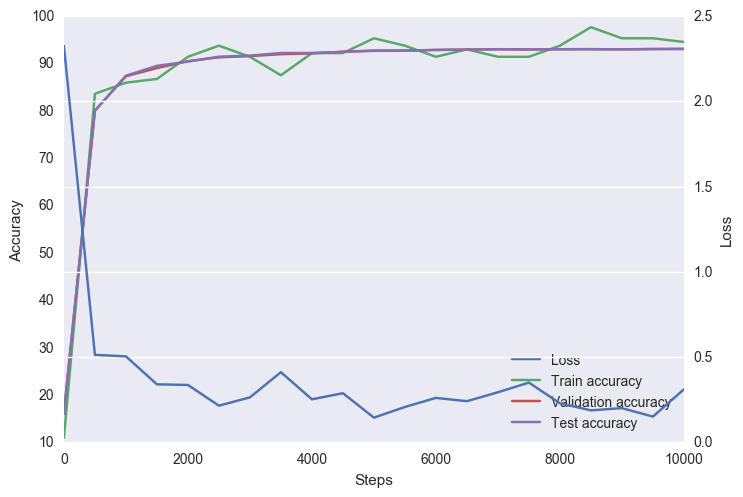

In [15]:
num_steps = 10001
step_steps = 500

results_df = pd.DataFrame(
    index = np.arange(0, num_steps, step_steps),
    columns = ['Loss', 'Train accuracy', 'Validation accuracy', 'Test accuracy'])

num_h1nodes = 2048
num_h2nodes = 512

weights1_stdev = 1.0/image_size
weights2_stdev = 1.0/sqrt(num_h1nodes)
weights_stdev  = 1.0/sqrt(num_h2nodes)

initial_learning_rate = 0.12
decay_steps = 1000
decay_rate = 0.6

graph = tf.Graph()
with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    h1_weights = tf.Variable(tf.truncated_normal([image_size * image_size, num_h1nodes], 0.0, weights1_stdev))
    h1_biases  = tf.Variable(tf.zeros([num_h1nodes]))
    h2_weights = tf.Variable(tf.truncated_normal([num_h1nodes, num_h2nodes], 0.0, weights2_stdev))
    h2_biases  = tf.Variable(tf.zeros([num_h2nodes]))
    weights    = tf.Variable(tf.truncated_normal([num_h2nodes, num_labels], 0.0, weights_stdev))
    biases     = tf.Variable(tf.zeros([num_labels]))

    # Training computation.
    h1_layer = tf.nn.relu(tf.matmul(tf_train_dataset, h1_weights) + h1_biases)
    h2_layer = tf.nn.relu(tf.matmul(h1_layer, h2_weights) + h2_biases)

    logits = tf.matmul(h2_layer, weights) + biases
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))

    # Optimizer.
    global_step   = tf.Variable(0)  # count the number of steps taken.
    # decayed_learning_rate = learning_rate * decay_rate ^ (global_step / decay_steps)
    learning_rate = tf.train.exponential_decay( initial_learning_rate,
                                                global_step,
                                                decay_steps,
                                                decay_rate,
                                                staircase=True )
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(tf.matmul(tf.nn.relu(
                                     tf.matmul(tf.nn.relu(
                                     tf.matmul(tf_valid_dataset, h1_weights) + h1_biases),
                                                                 h2_weights) + h2_biases),
                                                                    weights) + biases)
    test_prediction = tf.nn.softmax(tf.matmul(tf.nn.relu(
                                    tf.matmul(tf.nn.relu(
                                    tf.matmul(tf_test_dataset, h1_weights) + h1_biases),
                                                               h2_weights) + h2_biases),
                                                                  weights) + biases)
    
    model_saver = tf.train.Saver()

    tf.add_to_collection('h1w', h1_weights)
    tf.add_to_collection('h2w', h2_weights)
    tf.add_to_collection('w',      weights)

    tf.add_to_collection('h1b', h1_biases)
    tf.add_to_collection('h2b', h2_biases)
    tf.add_to_collection('b',      biases)
    
with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized")
    t1 = time.time()
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.

        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % step_steps == 0):
            results_df['Loss'               ][step]= l
            results_df['Train accuracy'     ][step] = accuracy(predictions, batch_labels)
            results_df['Validation accuracy'][step] = accuracy(valid_prediction.eval(), valid_labels)
            results_df['Test accuracy'      ][step] = accuracy( test_prediction.eval(), test_labels)
            t2 = time.time()
            print('step', step, 'calculated, time =', t2-t1)

    save_path = model_saver.save(session, "3Layer32x32Model")

display(results_df)

plt.figure()
ax = results_df.plot(secondary_y=['Loss'], mark_right=False)
ax.set(xlabel='Steps', ylabel='Accuracy')
ax.right_ax.set_ylabel('Loss')
savefig('Figures/three_layerNN')

### 2.4.3 Four-Layer (Three Hidden) Neural Network

With our three layer Network we've achieved 93% accuracy, a gain of 3% by adding a layer with minimal effort. It doesn't look like we have an issue with overfitting so in the hope of increasing accuracy further we add another hidden layer in our neural network.

Initialized
step 0 calculated, time = 12.6906399727
step 500 calculated, time = 69.0123960972
step 1000 calculated, time = 126.494092941
step 1500 calculated, time = 182.715450048
step 2000 calculated, time = 233.893316031
step 2500 calculated, time = 284.867053986
step 3000 calculated, time = 344.332742929
step 3500 calculated, time = 398.680459023
step 4000 calculated, time = 450.861897945
step 4500 calculated, time = 509.060837984
step 5000 calculated, time = 568.280739069
step 5500 calculated, time = 628.875930071
step 6000 calculated, time = 693.430160046


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,2.33256,7.8125,15.7479,15.7667
500,0.551724,83.5938,79.5752,79.4886
1000,0.513686,87.5,87.4605,87.5621
1500,0.318318,91.4062,89.091,89.3696
2000,0.364384,89.8438,90.7817,90.6424
2500,0.22752,93.75,91.5349,91.6704
3000,0.219955,92.9688,91.998,92.0847
3500,0.377602,89.0625,92.4725,92.7135
4000,0.22252,92.9688,92.3934,92.593
4500,0.249655,92.9688,92.8528,92.8415


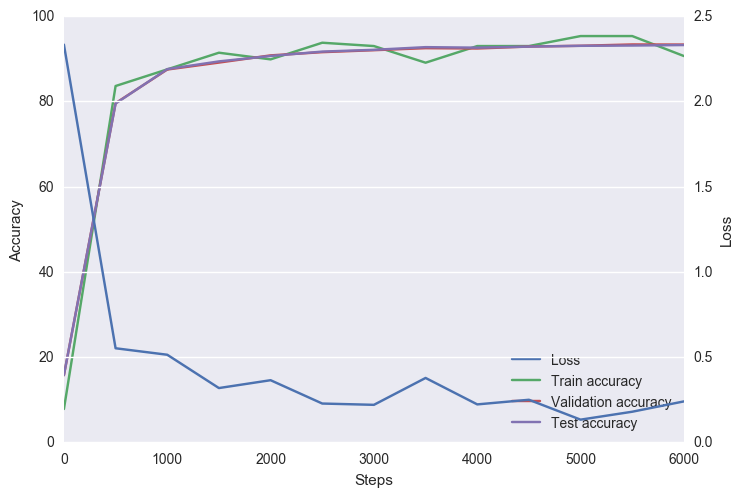

In [54]:
num_steps = 6001
step_steps = 500

results_df = pd.DataFrame(
    index = np.arange(0, num_steps, step_steps),
    columns = ['Loss', 'Train accuracy', 'Validation accuracy', 'Test accuracy'])

num_h1nodes = 2048
num_h2nodes = 1024
num_h3nodes = 512

weights1_stdev = 1.0/image_size
weights2_stdev = 1.0/sqrt(num_h1nodes)
weights3_stdev = 1.0/sqrt(num_h2nodes)
weights_stdev  = 1.0/sqrt(num_h3nodes)

initial_learning_rate = 0.12
decay_steps = 1000
decay_rate = 0.6

graph = tf.Graph()
with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    h1_weights = tf.Variable(tf.truncated_normal([image_size * image_size, num_h1nodes], 0.0, weights1_stdev))
    h1_biases  = tf.Variable(tf.zeros([num_h1nodes]))
    h2_weights = tf.Variable(tf.truncated_normal([num_h1nodes, num_h2nodes], 0.0, weights2_stdev))
    h2_biases  = tf.Variable(tf.zeros([num_h2nodes]))
    h3_weights = tf.Variable(tf.truncated_normal([num_h2nodes, num_h3nodes], 0.0, weights3_stdev))
    h3_biases  = tf.Variable(tf.zeros([num_h3nodes]))
    weights    = tf.Variable(tf.truncated_normal([num_h3nodes, num_labels], 0.0, weights_stdev))
    biases     = tf.Variable(tf.zeros([num_labels]))

    # Training computation.
    h1_layer = tf.nn.relu(tf.matmul(tf_train_dataset, h1_weights) + h1_biases)
    h2_layer = tf.nn.relu(tf.matmul(h1_layer, h2_weights) + h2_biases)
    h3_layer = tf.nn.relu(tf.matmul(h2_layer, h3_weights) + h3_biases)

    logits = tf.matmul(h3_layer, weights) + biases
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))

    # Optimizer.
    global_step   = tf.Variable(0)  # count the number of steps taken.
    # decayed_learning_rate = learning_rate * decay_rate ^ (global_step / decay_steps)
    learning_rate = tf.train.exponential_decay( initial_learning_rate,
                                                global_step,
                                                decay_steps,
                                                decay_rate,
                                                staircase=True )
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(tf.matmul(tf.nn.relu(
                                     tf.matmul(tf.nn.relu(
                                     tf.matmul(tf.nn.relu(
                                     tf.matmul(tf_valid_dataset, h1_weights) + h1_biases),
                                                                 h2_weights) + h2_biases),
                                                                 h3_weights) + h3_biases),
                                                                    weights) + biases)
    test_prediction = tf.nn.softmax(tf.matmul(tf.nn.relu(
                                    tf.matmul(tf.nn.relu(
                                    tf.matmul(tf.nn.relu(
                                    tf.matmul(tf_test_dataset, h1_weights) + h1_biases),
                                                               h2_weights) + h2_biases),
                                                               h3_weights) + h3_biases),
                                                                  weights) + biases)
    
with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized")
    t1 = time.time()
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.

        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % step_steps == 0):
            results_df['Loss'               ][step]= l
            results_df['Train accuracy'     ][step] = accuracy(predictions, batch_labels)
            results_df['Validation accuracy'][step] = accuracy(valid_prediction.eval(), valid_labels)
            results_df['Test accuracy'      ][step] = accuracy( test_prediction.eval(), test_labels)
            t2 = time.time()
            print('step', step, 'calculated, time =', t2-t1)

display(results_df)

plt.figure()
ax = results_df.plot(secondary_y=['Loss'], mark_right=False)
ax.set(xlabel='Steps', ylabel='Accuracy')
ax.right_ax.set_ylabel('Loss')
savefig('Figures/four_layerNN')

### 2.4.4 Four-Layer (Three Hidden) Neural Network with L2 Regularisation

In going from two to three layers we were able to go from 90% accuracy on our test set to 93% accuracy but the gain when we added another layer was much smaller, at around 0.5%. It doesn't look like we have an issue with overfitting but let's see if we can improve the accuracy using L2 regularisation. Maybe we can force the Network to learn a different solution?

Initialized
step 0 calculated, time = 12.2522749901
step 500 calculated, time = 69.7754621506
step 1000 calculated, time = 129.749330044
step 1500 calculated, time = 186.865059137
step 2000 calculated, time = 245.759502172
step 2500 calculated, time = 302.252995014
step 3000 calculated, time = 362.722969055
step 3500 calculated, time = 421.497606993
step 4000 calculated, time = 481.536867142
step 4500 calculated, time = 539.255330086
step 5000 calculated, time = 597.0029881
step 5500 calculated, time = 653.769222021
step 6000 calculated, time = 711.687031984


,Loss,Train accuracy,Validation accuracy,Test accuracy
0,16.214,10.9375,15.8872,15.3487
500,5.1586,82.8125,76.7887,76.4535
1000,2.3631,80.4688,83.066,83.0434
1500,1.57979,82.8125,83.8718,84.3802
2000,1.21347,85.9375,86.0069,86.199
2500,1.04048,90.625,87.5847,87.8897
3000,0.995326,89.0625,88.0215,88.0441
3500,1.13206,84.375,88.7558,89.1814
4000,0.896409,89.8438,89.3094,89.5617
4500,0.898137,91.4062,90.1491,90.3035


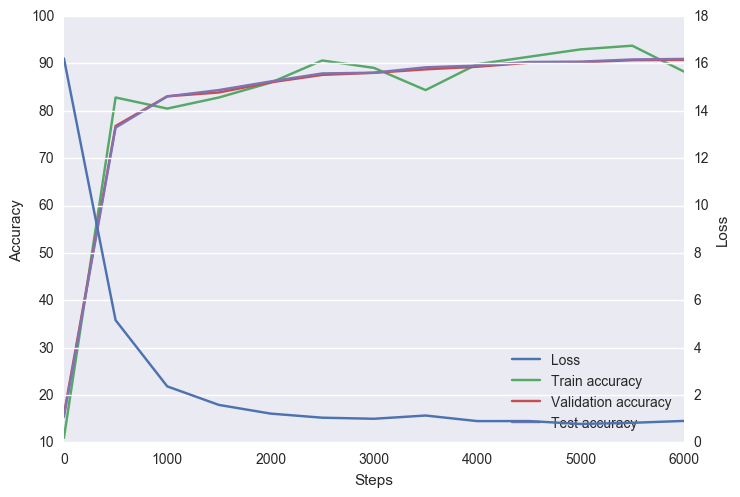

In [58]:
num_steps = 6001
step_steps = 500

results_df = pd.DataFrame(
    index = np.arange(0, num_steps, step_steps),
    columns = ['Loss', 'Train accuracy', 'Validation accuracy', 'Test accuracy'])

l2reg_beta = 0.000001

num_h1nodes = 2048
num_h2nodes = 1024
num_h3nodes = 512

weights1_stdev = 1.0/image_size
weights2_stdev = 1.0/sqrt(num_h1nodes)
weights3_stdev = 1.0/sqrt(num_h2nodes)
weights_stdev  = 1.0/sqrt(num_h3nodes)

initial_learning_rate = 0.12
decay_steps = 1000
decay_rate = 0.6

graph = tf.Graph()
with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    h1_weights = tf.Variable(tf.truncated_normal([image_size * image_size, num_h1nodes], 0.0, weights1_stdev))
    h1_biases  = tf.Variable(tf.zeros([num_h1nodes]))
    h2_weights = tf.Variable(tf.truncated_normal([num_h1nodes, num_h2nodes], 0.0, weights2_stdev))
    h2_biases  = tf.Variable(tf.zeros([num_h2nodes]))
    h3_weights = tf.Variable(tf.truncated_normal([num_h2nodes, num_h3nodes], 0.0, weights3_stdev))
    h3_biases  = tf.Variable(tf.zeros([num_h3nodes]))
    weights    = tf.Variable(tf.truncated_normal([num_h3nodes, num_labels], 0.0, weights_stdev))
    biases     = tf.Variable(tf.zeros([num_labels]))

    # Training computation.
    h1_layer = tf.nn.relu(tf.matmul(tf_train_dataset, h1_weights) + h1_biases)
    h2_layer = tf.nn.relu(tf.matmul(h1_layer, h2_weights) + h2_biases)
    h3_layer = tf.nn.relu(tf.matmul(h2_layer, h3_weights) + h3_biases)

    logits = tf.matmul(h3_layer, weights) + biases
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)
                          + l2reg_beta*tf.nn.l2_loss(h1_weights)
                          + l2reg_beta*tf.nn.l2_loss(h2_weights)
                          + l2reg_beta*tf.nn.l2_loss(h3_weights)
                          + l2reg_beta*tf.nn.l2_loss(   weights))

    # Optimizer.
    global_step   = tf.Variable(0)  # count the number of steps taken.
    # decayed_learning_rate = learning_rate * decay_rate ^ (global_step / decay_steps)
    learning_rate = tf.train.exponential_decay( initial_learning_rate,
                                                global_step,
                                                decay_steps,
                                                decay_rate,
                                                staircase=True )
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(tf.matmul(tf.nn.relu(
                                     tf.matmul(tf.nn.relu(
                                     tf.matmul(tf.nn.relu(
                                     tf.matmul(tf_valid_dataset, h1_weights) + h1_biases),
                                                                 h2_weights) + h2_biases),
                                                                 h3_weights) + h3_biases),
                                                                    weights) + biases)
    test_prediction = tf.nn.softmax(tf.matmul(tf.nn.relu(
                                    tf.matmul(tf.nn.relu(
                                    tf.matmul(tf.nn.relu(
                                    tf.matmul(tf_test_dataset, h1_weights) + h1_biases),
                                                               h2_weights) + h2_biases),
                                                               h3_weights) + h3_biases),
                                                                  weights) + biases)
    
with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized")
    t1 = time.time()
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.

        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % step_steps == 0):
            results_df['Loss'               ][step]= l
            results_df['Train accuracy'     ][step] = accuracy(predictions, batch_labels)
            results_df['Validation accuracy'][step] = accuracy(valid_prediction.eval(), valid_labels)
            results_df['Test accuracy'      ][step] = accuracy( test_prediction.eval(), test_labels)
            t2 = time.time()
            print('step', step, 'calculated, time =', t2-t1)                

display(results_df)

plt.figure()
ax = results_df.plot(secondary_y=['Loss'], mark_right=False)
ax.set(xlabel='Steps', ylabel='Accuracy')
ax.right_ax.set_ylabel('Loss')
savefig('Figures/four_layerNN_L2reg')

### 2.4.5 Four-Layer (Three Hidden) Neural Network with Dropout

In going from two to three layers we were able to go from 90% accuracy on our test set to 93% accuracy but the gain when we added another layer was much smaller, at around 0.4%. It doesn't look like we have an issue with overfitting so we don't expect adding dropout will help but we give it a go anyway.

In [ ]:
#### num_steps = 6001
step_steps = 500

results_df = pd.DataFrame(
    index = np.arange(0, num_steps, step_steps),
    columns = ['Loss', 'Train accuracy', 'Validation accuracy', 'Test accuracy'])

l2reg_beta = 0.0

keep_prob = 0.9

num_h1nodes = 2048
num_h2nodes = 1024
num_h3nodes = 512

weights1_stdev = 1.0/image_size/keep_prob
weights2_stdev = 1.0/sqrt(num_h1nodes)/keep_prob
weights3_stdev = 1.0/sqrt(num_h2nodes)/keep_prob
weights_stdev  = 1.0/sqrt(num_h3nodes)/keep_prob

initial_learning_rate = 0.12
decay_steps = 1000
decay_rate = 0.6

graph = tf.Graph()
with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    h1_weights = tf.Variable(tf.truncated_normal([image_size * image_size, num_h1nodes], 0.0, weights1_stdev))
    h1_biases  = tf.Variable(tf.zeros([num_h1nodes]))
    h2_weights = tf.Variable(tf.truncated_normal([num_h1nodes, num_h2nodes], 0.0, weights2_stdev))
    h2_biases  = tf.Variable(tf.zeros([num_h2nodes]))
    h3_weights = tf.Variable(tf.truncated_normal([num_h2nodes, num_h3nodes], 0.0, weights3_stdev))
    h3_biases  = tf.Variable(tf.zeros([num_h3nodes]))
    weights    = tf.Variable(tf.truncated_normal([num_h3nodes, num_labels], 0.0, weights_stdev))
    biases     = tf.Variable(tf.zeros([num_labels]))

    # Training computation.
    h1_layer = tf.nn.relu(tf.matmul(tf_train_dataset, h1_weights) + h1_biases)
    h1_layer_drop = tf.nn.dropout(h1_layer, keep_prob)
    h2_layer = tf.nn.relu(tf.matmul(h1_layer_drop, h2_weights) + h2_biases)
    h2_layer_drop = tf.nn.dropout(h2_layer, keep_prob)
    h3_layer = tf.nn.relu(tf.matmul(h2_layer_drop, h3_weights) + h3_biases)
    h3_layer_drop = tf.nn.dropout(h3_layer, keep_prob)

    logits = tf.matmul(h3_layer_drop, weights) + biases
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)
                          + l2reg_beta*tf.nn.l2_loss(h1_weights)
                          + l2reg_beta*tf.nn.l2_loss(h2_weights)
                          + l2reg_beta*tf.nn.l2_loss(h3_weights)
                          + l2reg_beta*tf.nn.l2_loss(   weights))

    # Optimizer.
    global_step   = tf.Variable(0)  # count the number of steps taken.
    # decayed_learning_rate = learning_rate * decay_rate ^ (global_step / decay_steps)
    learning_rate = tf.train.exponential_decay( initial_learning_rate,
                                                global_step,
                                                decay_steps,
                                                decay_rate,
                                                staircase=True )
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(tf.matmul(tf.nn.relu(
                                     tf.matmul(tf.nn.relu(
                                     tf.matmul(tf.nn.relu(
                                     tf.matmul(tf_valid_dataset, h1_weights) + h1_biases),
                                                                 h2_weights) + h2_biases),
                                                                 h3_weights) + h3_biases),
                                                                    weights) + biases)
    test_prediction = tf.nn.softmax(tf.matmul(tf.nn.relu(
                                    tf.matmul(tf.nn.relu(
                                    tf.matmul(tf.nn.relu(
                                    tf.matmul(tf_test_dataset, h1_weights) + h1_biases),
                                                               h2_weights) + h2_biases),
                                                               h3_weights) + h3_biases),
                                                                  weights) + biases)
    
with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized")
    t1 = time.time()
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.

        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % step_steps == 0):
            results_df['Loss'               ][step]= l
            results_df['Train accuracy'     ][step] = accuracy(predictions, batch_labels)
            results_df['Validation accuracy'][step] = accuracy(valid_prediction.eval(), valid_labels)
            results_df['Test accuracy'      ][step] = accuracy( test_prediction.eval(), test_labels)
            t2 = time.time()
            print('step', step, 'calculated, time =', t2-t1)                

display(results_df)

plt.figure()
ax = results_df.plot(secondary_y=['Loss'], mark_right=False)
ax.set(xlabel='Steps', ylabel='Accuracy')
ax.right_ax.set_ylabel('Loss')
savefig('Figures/four_layerNN_L2regDrop')